In [1]:
import sys
src_dir = '/Users/palmerio/Science_projects/GRB_population_model/grbpop/'
sys.path.insert(0, src_dir)

# GRB pop module imports
from GRB_population import GRBPopulation
import physics as ph
import stats as st
import io_grb_pop as io
import miscellaneous as msc
import plotting_functions as pf
from cosmology import init_cosmology
from ECLAIRs import init_ECLAIRs

# General imports
import yaml
import logging
import corner
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# specific imports
from scipy.stats import ks_2samp
from scipy.stats import mstats
from itertools import product

log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG,
                    format='%(asctime)s.%(msecs)03d [%(levelname)s] %(message)s',
                    datefmt='%H:%M:%S')
logging.getLogger('matplotlib').setLevel(logging.WARNING)

plt.style.use('paper')

In [2]:
paths_to_dir, paths_to_files = io.generate_paths(conf_fname='config_best_populations.yml')

14:51:47.180 [DEBUG] Root directory is /Users/palmerio/Science_projects/GRB_population_model
14:51:47.181 [DEBUG] Directory paths :
    'root'    : /Users/palmerio/Science_projects/GRB_population_model
    'obs'     : /Users/palmerio/Science_projects/GRB_population_model/observational_constraints
    'init'    : /Users/palmerio/Science_projects/GRB_population_model/init
    'output'  : /Users/palmerio/Science_projects/GRB_population_model/model_outputs
    'data'    : /Users/palmerio/Science_projects/GRB_population_model/data
    'cosmo'   : /Users/palmerio/Science_projects/GRB_population_model/data/cosmology
    'ECLAIRs' : /Users/palmerio/Science_projects/GRB_population_model/data/ECLAIRs
14:51:47.182 [DEBUG] File paths :
    'config'          : /Users/palmerio/Science_projects/GRB_population_model/init/config_best_populations.yml
    'param'           : /Users/palmerio/Science_projects/GRB_population_model/init/parameters.yml
    'instrum'         : /Users/palmerio/Science_projects/

In [3]:
config, params, instruments, samples, obs_constraints = io.read_init_files(paths_to_files)
paths_to_dir['output'] = '/Users/palmerio/Science_projects/GRB_population_model/model_outputs_non-dockerized/best_populations'
cosmo = init_cosmology(paths_to_dir['cosmo'])
ECLAIRs_prop = init_ECLAIRs(ECLAIRs_dir=paths_to_dir['ECLAIRs'],
                            Emin=instruments['ECLAIRs']['Emin'],
                            Emax=instruments['ECLAIRs']['Emax'],
                            n_sigma=instruments['ECLAIRs']['n_sigma'])
samples['ECLAIRs']['pflx_min'] = ECLAIRs_prop['bkg_total']

Nb_GRBs = int(1e6)

incl_samples, incl_instruments, incl_constraints = io.create_config(config,
                                                                     samples,
                                                                     instruments,
                                                                     obs_constraints)

14:51:48.575 [DEBUG] Input configuration:
Nb_GRBs: 1e6
constraints:
- Stern
- EpGBM
- eBAT6
output_dir: best_populations
samples:
- Stern
- EpGBM
- eBAT6
- Swift
- ECLAIRs
- SHOALS
- GBM_sample
- BATSE_5B_sample
- ECLAIRsS
- THESEUS
- HETE2_FRE
- HETE2_WXM
- HETE2_WXML
- BAT2
- BAT3

14:51:48.578 [DEBUG] Input parameters:
Cvar_distribution:
    correl_slope: -0.413
    mu: 0.04
    sigma: 0.22
luminosity_function:
    k_evol: 1.0
    logLbreak: 52.56
    logLmax: 53.0
    logLmin: 49.6989700043
    model: ES
    slope: 1.41
peak_energy_distribution:
    Ep0: 690
    L0: 1.6e52
    alpha_amati: 0.3
    model: LN
    sigmaEp: 0.45
redshift_distribution:
    a: 0.94
    b: -0.52
    model: BExp
    zm: 2.18
    zmax: 20
spectral_shape:
    alpha: 0.6
    beta: 2.5
    model: GBM
    shape: Band
t90obs_distribution:
    mu: 1.45
    sigma: 0.47

14:51:48.589 [DEBUG] Read cosmology from directory /Users/palmerio/Science_projects/GRB_population_model/data/cosmology: [0.3, 0.7, 0.7]
14:51:48.

In [4]:
# Generate the populations for the best model in each scenario or load the populations from files
# WARNING : this takes a long time to compute (at least 30 min with Nb_GRBs = 1e6)
##################

load_files = False

##################


np.random.seed(1)
model_names = ['kF_LN_nSFR',
               'k0_LN_nF', 
               'k05_LN_nF', 
               'k1_LN_nF', 
               'k2_LN_nF', 
               'kF_A_nSFR',
               'k0_A_nF', 
               'k05_A_nF',
#                'k05_A_nF_2',
               'k1_A_nF', 
#                'k1_A_nF_2', 
               'k2_A_nF']

model_names_ks = ['k0_LN_nF', 'k2_LN_nF', 'k0_A_nF', 'k2_A_nF']
# colors = ['#225ea8', '#41b6c4', '#ae017e', '#f768a1']
colors = ['#225ea8', '#41b6c4', '#d94801', '#fd8d3c']

parameters = {}
dfs = {}
results = {}
for mod in model_names:
    if load_files:
        print(f'Loading {mod}... ', end='')
        dfs[mod] = io.load_GRBPopulation_from(f'../model_outputs_non-dockerized/best_populations/population_{mod}_old.pkl')
        print('Done')
    else:
        print(f'Calculating {mod}... ')
        with open(paths_to_files['param'].parent / f'parameters_{mod}.yml', 'r') as f:
            parameters[mod] = yaml.safe_load(f)

        dfs[mod] = GRBPopulation(Nb_GRBs, output_dir=paths_to_dir['output'])
        dfs[mod].draw_GRB_properties(cosmo=cosmo, params=parameters[mod], run_mode=None)
        dfs[mod].calculate_quantities(instruments=incl_instruments, samples=incl_samples,
                                      ECLAIRs_prop=ECLAIRs_prop, calc_pdet=False)
        dfs[mod].create_mock_constraints(constraints=incl_constraints)
        dfs[mod].compare_to_observational_constraints(constraints=incl_constraints)
        dfs[mod].normalize_to_Stern()
         

Calculating kF_LN_nSFR... 
14:52:10.114 [INFO] Starting calculations of peak photon fluxes...
14:52:10.115 [DEBUG] For BATSE instrument [50, 300 keV]:
14:52:20.873 [DEBUG] Done in 10.758 s
14:52:21.080 [INFO] Starting calculations of peak photon fluxes...
14:52:21.081 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
14:52:32.275 [DEBUG] Done in 11.193 s
14:52:32.275 [DEBUG] For ECLAIRs instrument [4.0, 150.0 keV]:
14:52:51.971 [DEBUG] Done in 19.695 s
14:52:51.971 [DEBUG] For GBM instrument [10.0, 1000.0 keV]:
14:53:02.508 [DEBUG] Done in 10.536 s
14:53:02.509 [DEBUG] For BATSE_5B instrument [20.0, 2000.0 keV]:
14:53:13.437 [DEBUG] Done in 10.928 s
14:53:13.438 [DEBUG] For ECLAIRsS instrument [4.0, 120.0 keV]:
14:53:23.938 [DEBUG] Done in 10.500 s
14:53:23.939 [DEBUG] For THESEUS instrument [2.0, 30.0 keV]:
14:53:34.781 [DEBUG] Done in 10.841 s
14:53:34.782 [DEBUG] For FREGATE instrument [30.0, 400.0 keV]:
14:53:45.629 [DEBUG] Done in 10.847 s
14:53:45.630 [DEBUG] For WXM instrument [2.0,

15:06:51.484 [DEBUG] Done in 0.063 s
15:06:51.484 [DEBUG] Starting calculations of energy fluences...
15:06:51.547 [DEBUG] Done in 0.063 s
Calculating k1_LN_nF... 
15:06:52.852 [INFO] Starting calculations of peak photon fluxes...
15:06:52.853 [DEBUG] For BATSE instrument [50, 300 keV]:
15:07:04.863 [DEBUG] Done in 12.009 s
15:07:05.051 [INFO] Starting calculations of peak photon fluxes...
15:07:05.051 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
15:07:16.625 [DEBUG] Done in 11.573 s
15:07:16.625 [DEBUG] For ECLAIRs instrument [4.0, 150.0 keV]:
15:07:37.783 [DEBUG] Done in 21.157 s
15:07:37.783 [DEBUG] For GBM instrument [10.0, 1000.0 keV]:
15:07:49.968 [DEBUG] Done in 12.184 s
15:07:49.969 [DEBUG] For BATSE_5B instrument [20.0, 2000.0 keV]:
15:08:02.779 [DEBUG] Done in 12.810 s
15:08:02.780 [DEBUG] For ECLAIRsS instrument [4.0, 120.0 keV]:
15:08:14.519 [DEBUG] Done in 11.739 s
15:08:14.520 [DEBUG] For THESEUS instrument [2.0, 30.0 keV]:
15:08:26.309 [DEBUG] Done in 11.788 s
15:08:26.

15:21:26.216 [DEBUG] For BAT3 instrument [50.0, 100.0 keV]:
15:21:37.448 [DEBUG] Done in 11.231 s
15:21:37.449 [DEBUG] Starting calculations of photon fluences...
15:21:37.507 [DEBUG] Done in 0.057 s
15:21:37.507 [DEBUG] Starting calculations of energy fluences...
15:21:37.566 [DEBUG] Done in 0.058 s
Calculating k0_A_nF... 
15:21:38.891 [INFO] Starting calculations of peak photon fluxes...
15:21:38.892 [DEBUG] For BATSE instrument [50, 300 keV]:
15:21:50.143 [DEBUG] Done in 11.251 s
15:21:50.342 [INFO] Starting calculations of peak photon fluxes...
15:21:50.343 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
15:22:01.599 [DEBUG] Done in 11.255 s
15:22:01.600 [DEBUG] For ECLAIRs instrument [4.0, 150.0 keV]:
15:22:22.067 [DEBUG] Done in 20.467 s
15:22:22.068 [DEBUG] For GBM instrument [10.0, 1000.0 keV]:
15:22:33.409 [DEBUG] Done in 11.341 s
15:22:33.410 [DEBUG] For BATSE_5B instrument [20.0, 2000.0 keV]:
15:22:44.553 [DEBUG] Done in 11.143 s
15:22:44.554 [DEBUG] For ECLAIRsS instrument [4

15:35:43.325 [DEBUG] Done in 11.082 s
15:35:43.326 [DEBUG] For BAT2 instrument [25.0, 50.0 keV]:
15:35:54.374 [DEBUG] Done in 11.048 s
15:35:54.375 [DEBUG] For BAT3 instrument [50.0, 100.0 keV]:
15:36:05.434 [DEBUG] Done in 11.059 s
15:36:05.434 [DEBUG] Starting calculations of photon fluences...
15:36:05.495 [DEBUG] Done in 0.060 s
15:36:05.495 [DEBUG] Starting calculations of energy fluences...
15:36:05.551 [DEBUG] Done in 0.055 s
Calculating k2_A_nF... 
15:36:06.796 [INFO] Starting calculations of peak photon fluxes...
15:36:06.796 [DEBUG] For BATSE instrument [50, 300 keV]:
15:36:18.052 [DEBUG] Done in 11.256 s
15:36:18.260 [INFO] Starting calculations of peak photon fluxes...
15:36:18.261 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
15:36:29.411 [DEBUG] Done in 11.149 s
15:36:29.412 [DEBUG] For ECLAIRs instrument [4.0, 150.0 keV]:
15:36:49.722 [DEBUG] Done in 20.310 s
15:36:49.723 [DEBUG] For GBM instrument [10.0, 1000.0 keV]:
15:37:00.767 [DEBUG] Done in 11.043 s
15:37:00.767 [D

In [46]:
mod = 'k2_A_nF'
Sterns = {}
EpGBMs = {}
eBAT6s = {}
N_models = 100
Nb_GRBs = 5e5
N_Stern = len(obs_constraints['Stern']['hist'])
N_EpGBM = len(obs_constraints['EpGBM']['hist'])
N_eBAT6 = len(obs_constraints['eBAT6']['hist'])

for mod in model_names:
    print(f'Calculating {mod}... ')
    
    df = pd.read_pickle(f'../model_outputs_non-dockerized/best_populations/params_from_MCMC_{mod}.gzip')
    Sterns[mod] = np.zeros((N_models, N_Stern))
    EpGBMs[mod] = np.zeros((N_models, N_EpGBM))
    eBAT6s[mod] = np.zeros((N_models, N_eBAT6))
    delta_bin_Stern = np.log10(obs_constraints['Stern']['bins'][1:]/obs_constraints['Stern']['bins'][:-1])
    delta_bin_EpGBM = np.log10(obs_constraints['EpGBM']['bins'][1:]/obs_constraints['EpGBM']['bins'][:-1])
    delta_bin_eBAT6 = obs_constraints['eBAT6']['bins'][1:]-obs_constraints['eBAT6']['bins'][:-1]
    nec_instr = io.included_instruments(['BATSE', 'BAT'], instruments)

    for i in range(N_models):
        log.info('Starting for model {} of {} ({:.1f}%)'.format(i, N_models, 100.*float(i)/N_models))
        params['luminosity_function']={'model':'ES',
                                      'logLbreak':np.log10(df['Lbreak'].iloc[i]),
                                      'slope':df['slope'].iloc[i],
                                      'logLmin':49.6989700043,
                                      'k_evol':df['k_evol'].iloc[i]}
        params['redshift_distribution']={'model':'BExp',
                                        'zm':df['zm'].iloc[i],
                                        'a':df['a'].iloc[i],
                                        'b':df['b'].iloc[i]}
        params['peak_energy_distribution']={'model':mod.split('_')[1],
                                            'Ep0':df['Ep0'].iloc[i],
                                            'sigmaEp':df['sigma_Ep'].iloc[i],
                                            'alpha_amati':df['alpha_amati'].iloc[i],
                                            'L0': 1.6e52}
        params['spectral_shape']={'model':'GBM',
                                  'shape':'Band'}

        gp = GRBPopulation(Nb_GRBs=Nb_GRBs)
        gp.draw_GRB_properties_for_MCMC(cosmo, params, nec_instr)
        gp.calc_peak_photon_flux(nec_instr)
        gp.create_mock_constraints()
        gp.compare_to_observational_constraints(constraints=incl_constraints)
        gp.normalize_to_Stern()
        Sterns[mod][i] = gp.mock_constraints['Stern']['hist_unnormed']/(delta_bin_Stern * gp.normalization['T_sim'])
        EpGBMs[mod][i] = gp.mock_constraints['EpGBM']['hist_unnormed']/(np.sum(gp.mock_constraints['EpGBM']['hist_unnormed']) * delta_bin_EpGBM)
        eBAT6s[mod][i] = gp.mock_constraints['eBAT6']['hist_unnormed']/(np.sum(gp.mock_constraints['eBAT6']['hist_unnormed']) * delta_bin_eBAT6)


Calculating kF_LN_nSFR... 
17:35:16.272 [INFO] Including instruments: ['BATSE', 'BAT']
17:35:16.273 [DEBUG] Including instruments:
BAT:
    Emax: 150.0
    Emin: 15.0
BATSE:
    Emax: 300.0
    Emin: 50.0

17:35:16.274 [INFO] Starting for model 0 of 100 (0.0%)
17:35:16.673 [INFO] Starting calculations of peak photon fluxes...
17:35:16.673 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
17:35:21.364 [DEBUG] Done in 4.690 s
17:35:21.364 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:35:25.391 [DEBUG] Done in 4.026 s
17:35:25.392 [INFO] Starting calculations of peak photon fluxes...
17:35:25.392 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:35:29.425 [DEBUG] Done in 4.032 s
17:35:29.552 [INFO] Starting for model 1 of 100 (1.0%)
17:35:29.912 [INFO] Starting calculations of peak photon fluxes...
17:35:29.913 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
17:35:34.101 [DEBUG] Done in 4.188 s
17:35:34.102 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:35:38.188 [DEBUG] Done in 4.085 s

17:38:43.937 [INFO] Starting calculations of peak photon fluxes...
17:38:43.937 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:38:47.857 [DEBUG] Done in 3.919 s
17:38:47.934 [INFO] Starting for model 17 of 100 (17.0%)
17:38:48.376 [INFO] Starting calculations of peak photon fluxes...
17:38:48.377 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
17:38:52.364 [DEBUG] Done in 3.986 s
17:38:52.364 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:38:56.343 [DEBUG] Done in 3.978 s
17:38:56.344 [INFO] Starting calculations of peak photon fluxes...
17:38:56.344 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:39:00.284 [DEBUG] Done in 3.940 s
17:39:00.368 [INFO] Starting for model 18 of 100 (18.0%)
17:39:00.711 [INFO] Starting calculations of peak photon fluxes...
17:39:00.712 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
17:39:04.753 [DEBUG] Done in 4.040 s
17:39:04.753 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:39:08.698 [DEBUG] Done in 3.944 s
17:39:08.699 [INFO] Starting calculati

17:42:13.679 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:42:17.678 [DEBUG] Done in 3.999 s
17:42:17.755 [INFO] Starting for model 34 of 100 (34.0%)
17:42:18.093 [INFO] Starting calculations of peak photon fluxes...
17:42:18.093 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
17:42:22.118 [DEBUG] Done in 4.025 s
17:42:22.119 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:42:26.239 [DEBUG] Done in 4.119 s
17:42:26.239 [INFO] Starting calculations of peak photon fluxes...
17:42:26.240 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:42:30.227 [DEBUG] Done in 3.987 s
17:42:30.321 [INFO] Starting for model 35 of 100 (35.0%)
17:42:30.675 [INFO] Starting calculations of peak photon fluxes...
17:42:30.676 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
17:42:34.779 [DEBUG] Done in 4.103 s
17:42:34.780 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:42:38.745 [DEBUG] Done in 3.964 s
17:42:38.746 [INFO] Starting calculations of peak photon fluxes...
17:42:38.746 [DEBUG] For BAT instrumen

17:45:47.452 [DEBUG] Done in 3.907 s
17:45:47.540 [INFO] Starting for model 51 of 100 (51.0%)
17:45:47.890 [INFO] Starting calculations of peak photon fluxes...
17:45:47.891 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
17:45:51.946 [DEBUG] Done in 4.054 s
17:45:51.947 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:45:55.911 [DEBUG] Done in 3.964 s
17:45:55.912 [INFO] Starting calculations of peak photon fluxes...
17:45:55.913 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:45:59.816 [DEBUG] Done in 3.902 s
17:45:59.903 [INFO] Starting for model 52 of 100 (52.0%)
17:46:00.244 [INFO] Starting calculations of peak photon fluxes...
17:46:00.245 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
17:46:04.238 [DEBUG] Done in 3.993 s
17:46:04.239 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:46:08.140 [DEBUG] Done in 3.900 s
17:46:08.140 [INFO] Starting calculations of peak photon fluxes...
17:46:08.141 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:46:12.085 [DEBUG] Done in 3.944 s
1

17:49:16.294 [INFO] Starting for model 68 of 100 (68.0%)
17:49:16.659 [INFO] Starting calculations of peak photon fluxes...
17:49:16.660 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
17:49:20.650 [DEBUG] Done in 3.990 s
17:49:20.651 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:49:24.604 [DEBUG] Done in 3.952 s
17:49:24.605 [INFO] Starting calculations of peak photon fluxes...
17:49:24.606 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:49:28.504 [DEBUG] Done in 3.898 s
17:49:28.590 [INFO] Starting for model 69 of 100 (69.0%)
17:49:28.924 [INFO] Starting calculations of peak photon fluxes...
17:49:28.925 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
17:49:32.847 [DEBUG] Done in 3.921 s
17:49:32.847 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:49:36.823 [DEBUG] Done in 3.976 s
17:49:36.824 [INFO] Starting calculations of peak photon fluxes...
17:49:36.824 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:49:40.716 [DEBUG] Done in 3.891 s
17:49:40.802 [INFO] Starting for model

17:52:44.687 [INFO] Starting calculations of peak photon fluxes...
17:52:44.687 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
17:52:48.642 [DEBUG] Done in 3.954 s
17:52:48.643 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:52:52.541 [DEBUG] Done in 3.898 s
17:52:52.542 [INFO] Starting calculations of peak photon fluxes...
17:52:52.543 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:52:56.480 [DEBUG] Done in 3.937 s
17:52:56.558 [INFO] Starting for model 86 of 100 (86.0%)
17:52:56.893 [INFO] Starting calculations of peak photon fluxes...
17:52:56.894 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
17:53:00.822 [DEBUG] Done in 3.928 s
17:53:00.823 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:53:04.810 [DEBUG] Done in 3.986 s
17:53:04.811 [INFO] Starting calculations of peak photon fluxes...
17:53:04.811 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:53:08.712 [DEBUG] Done in 3.901 s
17:53:08.793 [INFO] Starting for model 87 of 100 (87.0%)
17:53:09.134 [INFO] Starting calculati

17:56:07.833 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:56:11.730 [DEBUG] Done in 3.897 s
17:56:11.784 [INFO] Starting for model 2 of 100 (2.0%)
17:56:12.136 [INFO] Starting calculations of peak photon fluxes...
17:56:12.137 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
17:56:16.039 [DEBUG] Done in 3.902 s
17:56:16.040 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:56:19.996 [DEBUG] Done in 3.956 s
17:56:19.997 [INFO] Starting calculations of peak photon fluxes...
17:56:19.998 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:56:23.955 [DEBUG] Done in 3.957 s
17:56:24.009 [INFO] Starting for model 3 of 100 (3.0%)
17:56:24.363 [INFO] Starting calculations of peak photon fluxes...
17:56:24.364 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
17:56:28.294 [DEBUG] Done in 3.929 s
17:56:28.294 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:56:32.202 [DEBUG] Done in 3.907 s
17:56:32.203 [INFO] Starting calculations of peak photon fluxes...
17:56:32.204 [DEBUG] For BAT instrument [1

17:59:38.779 [DEBUG] Done in 3.910 s
17:59:38.839 [INFO] Starting for model 19 of 100 (19.0%)
17:59:39.183 [INFO] Starting calculations of peak photon fluxes...
17:59:39.184 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
17:59:43.111 [DEBUG] Done in 3.927 s
17:59:43.112 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:59:46.988 [DEBUG] Done in 3.876 s
17:59:46.989 [INFO] Starting calculations of peak photon fluxes...
17:59:46.989 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:59:50.953 [DEBUG] Done in 3.963 s
17:59:51.001 [INFO] Starting for model 20 of 100 (20.0%)
17:59:51.335 [INFO] Starting calculations of peak photon fluxes...
17:59:51.335 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
17:59:55.359 [DEBUG] Done in 4.024 s
17:59:55.360 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
17:59:59.256 [DEBUG] Done in 3.895 s
17:59:59.257 [INFO] Starting calculations of peak photon fluxes...
17:59:59.257 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:00:03.162 [DEBUG] Done in 3.904 s
1

18:03:06.288 [INFO] Starting for model 36 of 100 (36.0%)
18:03:06.619 [INFO] Starting calculations of peak photon fluxes...
18:03:06.620 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:03:10.591 [DEBUG] Done in 3.971 s
18:03:10.592 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:03:14.502 [DEBUG] Done in 3.910 s
18:03:14.503 [INFO] Starting calculations of peak photon fluxes...
18:03:14.503 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:03:18.390 [DEBUG] Done in 3.886 s
18:03:18.447 [INFO] Starting for model 37 of 100 (37.0%)
18:03:18.817 [INFO] Starting calculations of peak photon fluxes...
18:03:18.817 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:03:22.792 [DEBUG] Done in 3.974 s
18:03:22.793 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:03:26.726 [DEBUG] Done in 3.933 s
18:03:26.727 [INFO] Starting calculations of peak photon fluxes...
18:03:26.728 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:03:30.652 [DEBUG] Done in 3.924 s
18:03:30.699 [INFO] Starting for model

18:06:33.755 [INFO] Starting calculations of peak photon fluxes...
18:06:33.756 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:06:37.727 [DEBUG] Done in 3.971 s
18:06:37.728 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:06:41.626 [DEBUG] Done in 3.897 s
18:06:41.626 [INFO] Starting calculations of peak photon fluxes...
18:06:41.627 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:06:45.515 [DEBUG] Done in 3.887 s
18:06:45.574 [INFO] Starting for model 54 of 100 (54.0%)
18:06:45.909 [INFO] Starting calculations of peak photon fluxes...
18:06:45.910 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:06:49.922 [DEBUG] Done in 4.011 s
18:06:49.922 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:06:53.894 [DEBUG] Done in 3.971 s
18:06:53.895 [INFO] Starting calculations of peak photon fluxes...
18:06:53.895 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:06:57.814 [DEBUG] Done in 3.918 s
18:06:57.866 [INFO] Starting for model 55 of 100 (55.0%)
18:06:58.202 [INFO] Starting calculati

18:10:02.049 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:10:06.067 [DEBUG] Done in 4.017 s
18:10:06.068 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:10:09.986 [DEBUG] Done in 3.918 s
18:10:09.987 [INFO] Starting calculations of peak photon fluxes...
18:10:09.987 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:10:13.886 [DEBUG] Done in 3.899 s
18:10:13.949 [INFO] Starting for model 71 of 100 (71.0%)
18:10:14.285 [INFO] Starting calculations of peak photon fluxes...
18:10:14.286 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:10:18.223 [DEBUG] Done in 3.937 s
18:10:18.224 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:10:22.197 [DEBUG] Done in 3.972 s
18:10:22.197 [INFO] Starting calculations of peak photon fluxes...
18:10:22.198 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:10:26.142 [DEBUG] Done in 3.944 s
18:10:26.194 [INFO] Starting for model 72 of 100 (72.0%)
18:10:26.528 [INFO] Starting calculations of peak photon fluxes...
18:10:26.528 [DEBUG] For BATSE instrum

18:13:33.193 [DEBUG] Done in 3.921 s
18:13:33.193 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:13:37.164 [DEBUG] Done in 3.971 s
18:13:37.165 [INFO] Starting calculations of peak photon fluxes...
18:13:37.166 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:13:41.041 [DEBUG] Done in 3.874 s
18:13:41.089 [INFO] Starting for model 88 of 100 (88.0%)
18:13:41.431 [INFO] Starting calculations of peak photon fluxes...
18:13:41.432 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:13:45.361 [DEBUG] Done in 3.929 s
18:13:45.362 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:13:49.343 [DEBUG] Done in 3.981 s
18:13:49.344 [INFO] Starting calculations of peak photon fluxes...
18:13:49.345 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:13:53.253 [DEBUG] Done in 3.908 s
18:13:53.303 [INFO] Starting for model 89 of 100 (89.0%)
18:13:53.643 [INFO] Starting calculations of peak photon fluxes...
18:13:53.643 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:13:57.574 [DEBUG] Done in 3.930 s
1

18:16:56.603 [INFO] Starting calculations of peak photon fluxes...
18:16:56.604 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:17:00.506 [DEBUG] Done in 3.902 s
18:17:00.507 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:17:04.455 [DEBUG] Done in 3.948 s
18:17:04.456 [INFO] Starting calculations of peak photon fluxes...
18:17:04.457 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:17:08.336 [DEBUG] Done in 3.879 s
18:17:08.404 [INFO] Starting for model 5 of 100 (5.0%)
18:17:08.739 [INFO] Starting calculations of peak photon fluxes...
18:17:08.740 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:17:12.636 [DEBUG] Done in 3.895 s
18:17:12.636 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:17:16.513 [DEBUG] Done in 3.876 s
18:17:16.514 [INFO] Starting calculations of peak photon fluxes...
18:17:16.515 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:17:20.486 [DEBUG] Done in 3.971 s
18:17:20.551 [INFO] Starting for model 6 of 100 (6.0%)
18:17:20.894 [INFO] Starting calculations 

18:20:23.850 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:20:27.781 [DEBUG] Done in 3.931 s
18:20:27.782 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:20:31.671 [DEBUG] Done in 3.888 s
18:20:31.671 [INFO] Starting calculations of peak photon fluxes...
18:20:31.672 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:20:35.653 [DEBUG] Done in 3.981 s
18:20:35.710 [INFO] Starting for model 22 of 100 (22.0%)
18:20:36.045 [INFO] Starting calculations of peak photon fluxes...
18:20:36.045 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:20:39.974 [DEBUG] Done in 3.929 s
18:20:39.975 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:20:43.884 [DEBUG] Done in 3.909 s
18:20:43.885 [INFO] Starting calculations of peak photon fluxes...
18:20:43.886 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:20:47.772 [DEBUG] Done in 3.886 s
18:20:47.837 [INFO] Starting for model 23 of 100 (23.0%)
18:20:48.174 [INFO] Starting calculations of peak photon fluxes...
18:20:48.174 [DEBUG] For BATSE instrum

18:23:54.772 [DEBUG] Done in 3.919 s
18:23:54.773 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:23:58.678 [DEBUG] Done in 3.905 s
18:23:58.679 [INFO] Starting calculations of peak photon fluxes...
18:23:58.680 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:24:02.584 [DEBUG] Done in 3.904 s
18:24:02.640 [INFO] Starting for model 39 of 100 (39.0%)
18:24:02.972 [INFO] Starting calculations of peak photon fluxes...
18:24:02.973 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:24:06.966 [DEBUG] Done in 3.993 s
18:24:06.967 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:24:10.842 [DEBUG] Done in 3.875 s
18:24:10.843 [INFO] Starting calculations of peak photon fluxes...
18:24:10.844 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:24:14.736 [DEBUG] Done in 3.892 s
18:24:14.791 [INFO] Starting for model 40 of 100 (40.0%)
18:24:15.124 [INFO] Starting calculations of peak photon fluxes...
18:24:15.125 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:24:19.122 [DEBUG] Done in 3.997 s
1

18:27:21.715 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:27:25.605 [DEBUG] Done in 3.889 s
18:27:25.605 [INFO] Starting calculations of peak photon fluxes...
18:27:25.606 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:27:29.498 [DEBUG] Done in 3.891 s
18:27:29.563 [INFO] Starting for model 56 of 100 (56.0%)
18:27:29.899 [INFO] Starting calculations of peak photon fluxes...
18:27:29.899 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:27:33.847 [DEBUG] Done in 3.948 s
18:27:33.848 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:27:37.726 [DEBUG] Done in 3.878 s
18:27:37.727 [INFO] Starting calculations of peak photon fluxes...
18:27:37.728 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:27:41.608 [DEBUG] Done in 3.880 s
18:27:41.675 [INFO] Starting for model 57 of 100 (57.0%)
18:27:42.020 [INFO] Starting calculations of peak photon fluxes...
18:27:42.021 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:27:45.921 [DEBUG] Done in 3.900 s
18:27:45.922 [DEBUG] For BAT instrumen

18:30:52.471 [DEBUG] Done in 3.915 s
18:30:52.471 [INFO] Starting calculations of peak photon fluxes...
18:30:52.472 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:30:56.390 [DEBUG] Done in 3.918 s
18:30:56.447 [INFO] Starting for model 73 of 100 (73.0%)
18:30:56.776 [INFO] Starting calculations of peak photon fluxes...
18:30:56.777 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:31:00.710 [DEBUG] Done in 3.933 s
18:31:00.711 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:31:04.673 [DEBUG] Done in 3.961 s
18:31:04.674 [INFO] Starting calculations of peak photon fluxes...
18:31:04.674 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:31:08.581 [DEBUG] Done in 3.907 s
18:31:08.637 [INFO] Starting for model 74 of 100 (74.0%)
18:31:08.966 [INFO] Starting calculations of peak photon fluxes...
18:31:08.967 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:31:12.863 [DEBUG] Done in 3.896 s
18:31:12.863 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:31:16.765 [DEBUG] Done in 3.901 s
1

18:34:19.478 [INFO] Starting calculations of peak photon fluxes...
18:34:19.479 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:34:23.381 [DEBUG] Done in 3.902 s
18:34:23.437 [INFO] Starting for model 90 of 100 (90.0%)
18:34:23.769 [INFO] Starting calculations of peak photon fluxes...
18:34:23.770 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:34:27.690 [DEBUG] Done in 3.920 s
18:34:27.691 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:34:31.610 [DEBUG] Done in 3.919 s
18:34:31.611 [INFO] Starting calculations of peak photon fluxes...
18:34:31.611 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:34:35.563 [DEBUG] Done in 3.951 s
18:34:35.621 [INFO] Starting for model 91 of 100 (91.0%)
18:34:35.961 [INFO] Starting calculations of peak photon fluxes...
18:34:35.961 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:34:39.878 [DEBUG] Done in 3.916 s
18:34:39.878 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:34:43.755 [DEBUG] Done in 3.877 s
18:34:43.756 [INFO] Starting calculati

18:37:41.919 [DEBUG] Done in 3.916 s
18:37:41.919 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:37:45.804 [DEBUG] Done in 3.884 s
18:37:45.805 [INFO] Starting calculations of peak photon fluxes...
18:37:45.806 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:37:49.759 [DEBUG] Done in 3.953 s
18:37:49.826 [INFO] Starting for model 7 of 100 (7.0%)
18:37:50.151 [INFO] Starting calculations of peak photon fluxes...
18:37:50.152 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:37:54.114 [DEBUG] Done in 3.962 s
18:37:54.115 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:37:57.987 [DEBUG] Done in 3.872 s
18:37:57.988 [INFO] Starting calculations of peak photon fluxes...
18:37:57.989 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:38:01.907 [DEBUG] Done in 3.918 s
18:38:01.971 [INFO] Starting for model 8 of 100 (8.0%)
18:38:02.299 [INFO] Starting calculations of peak photon fluxes...
18:38:02.300 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:38:06.296 [DEBUG] Done in 3.995 s
18:38

18:41:08.284 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:41:12.147 [DEBUG] Done in 3.863 s
18:41:12.148 [INFO] Starting calculations of peak photon fluxes...
18:41:12.148 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:41:16.030 [DEBUG] Done in 3.881 s
18:41:16.094 [INFO] Starting for model 24 of 100 (24.0%)
18:41:16.426 [INFO] Starting calculations of peak photon fluxes...
18:41:16.427 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:41:20.398 [DEBUG] Done in 3.970 s
18:41:20.399 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:41:24.342 [DEBUG] Done in 3.943 s
18:41:24.343 [INFO] Starting calculations of peak photon fluxes...
18:41:24.344 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:41:28.207 [DEBUG] Done in 3.863 s
18:41:28.283 [INFO] Starting for model 25 of 100 (25.0%)
18:41:28.626 [INFO] Starting calculations of peak photon fluxes...
18:41:28.627 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:41:32.540 [DEBUG] Done in 3.913 s
18:41:32.541 [DEBUG] For BAT instrumen

18:44:38.908 [DEBUG] Done in 3.898 s
18:44:38.909 [INFO] Starting calculations of peak photon fluxes...
18:44:38.910 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:44:42.806 [DEBUG] Done in 3.896 s
18:44:42.877 [INFO] Starting for model 41 of 100 (41.0%)
18:44:43.214 [INFO] Starting calculations of peak photon fluxes...
18:44:43.214 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:44:47.122 [DEBUG] Done in 3.908 s
18:44:47.123 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:44:51.128 [DEBUG] Done in 4.004 s
18:44:51.129 [INFO] Starting calculations of peak photon fluxes...
18:44:51.129 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:44:55.019 [DEBUG] Done in 3.889 s
18:44:55.083 [INFO] Starting for model 42 of 100 (42.0%)
18:44:55.414 [INFO] Starting calculations of peak photon fluxes...
18:44:55.414 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:44:59.312 [DEBUG] Done in 3.897 s
18:44:59.312 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:45:03.180 [DEBUG] Done in 3.867 s
1

18:48:05.579 [INFO] Starting calculations of peak photon fluxes...
18:48:05.579 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:48:09.447 [DEBUG] Done in 3.867 s
18:48:09.511 [INFO] Starting for model 58 of 100 (58.0%)
18:48:09.835 [INFO] Starting calculations of peak photon fluxes...
18:48:09.835 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:48:13.721 [DEBUG] Done in 3.885 s
18:48:13.721 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:48:17.602 [DEBUG] Done in 3.880 s
18:48:17.603 [INFO] Starting calculations of peak photon fluxes...
18:48:17.603 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:48:21.599 [DEBUG] Done in 3.996 s
18:48:21.664 [INFO] Starting for model 59 of 100 (59.0%)
18:48:21.987 [INFO] Starting calculations of peak photon fluxes...
18:48:21.987 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:48:25.910 [DEBUG] Done in 3.922 s
18:48:25.910 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:48:29.794 [DEBUG] Done in 3.883 s
18:48:29.794 [INFO] Starting calculati

18:51:31.809 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:51:35.864 [DEBUG] Done in 4.055 s
18:51:35.938 [INFO] Starting for model 75 of 100 (75.0%)
18:51:36.273 [INFO] Starting calculations of peak photon fluxes...
18:51:36.273 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:51:40.180 [DEBUG] Done in 3.906 s
18:51:40.181 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:51:44.085 [DEBUG] Done in 3.903 s
18:51:44.085 [INFO] Starting calculations of peak photon fluxes...
18:51:44.086 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:51:47.966 [DEBUG] Done in 3.879 s
18:51:48.034 [INFO] Starting for model 76 of 100 (76.0%)
18:51:48.459 [INFO] Starting calculations of peak photon fluxes...
18:51:48.459 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:51:52.375 [DEBUG] Done in 3.915 s
18:51:52.376 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:51:56.267 [DEBUG] Done in 3.891 s
18:51:56.268 [INFO] Starting calculations of peak photon fluxes...
18:51:56.268 [DEBUG] For BAT instrumen

18:55:02.562 [DEBUG] Done in 3.874 s
18:55:02.630 [INFO] Starting for model 92 of 100 (92.0%)
18:55:02.971 [INFO] Starting calculations of peak photon fluxes...
18:55:02.972 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:55:06.942 [DEBUG] Done in 3.970 s
18:55:06.943 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:55:10.815 [DEBUG] Done in 3.872 s
18:55:10.816 [INFO] Starting calculations of peak photon fluxes...
18:55:10.817 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:55:14.695 [DEBUG] Done in 3.878 s
18:55:14.766 [INFO] Starting for model 93 of 100 (93.0%)
18:55:15.093 [INFO] Starting calculations of peak photon fluxes...
18:55:15.094 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:55:19.062 [DEBUG] Done in 3.968 s
18:55:19.063 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:55:22.978 [DEBUG] Done in 3.915 s
18:55:22.979 [INFO] Starting calculations of peak photon fluxes...
18:55:22.979 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:55:26.898 [DEBUG] Done in 3.918 s
1

18:58:25.896 [DEBUG] Done in 3.921 s
18:58:25.897 [INFO] Starting calculations of peak photon fluxes...
18:58:25.897 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:58:29.760 [DEBUG] Done in 3.862 s
18:58:29.849 [INFO] Starting for model 9 of 100 (9.0%)
18:58:30.171 [INFO] Starting calculations of peak photon fluxes...
18:58:30.172 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:58:34.178 [DEBUG] Done in 4.005 s
18:58:34.179 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:58:38.081 [DEBUG] Done in 3.901 s
18:58:38.081 [INFO] Starting calculations of peak photon fluxes...
18:58:38.082 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:58:41.960 [DEBUG] Done in 3.877 s
18:58:42.047 [INFO] Starting for model 10 of 100 (10.0%)
18:58:42.371 [INFO] Starting calculations of peak photon fluxes...
18:58:42.372 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
18:58:46.270 [DEBUG] Done in 3.897 s
18:58:46.270 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
18:58:50.200 [DEBUG] Done in 3.929 s
18:

19:01:52.451 [INFO] Starting calculations of peak photon fluxes...
19:01:52.452 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:01:56.352 [DEBUG] Done in 3.899 s
19:01:56.440 [INFO] Starting for model 26 of 100 (26.0%)
19:01:56.764 [INFO] Starting calculations of peak photon fluxes...
19:01:56.765 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:02:00.672 [DEBUG] Done in 3.907 s
19:02:00.672 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:02:04.671 [DEBUG] Done in 3.997 s
19:02:04.671 [INFO] Starting calculations of peak photon fluxes...
19:02:04.672 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:02:08.567 [DEBUG] Done in 3.895 s
19:02:08.656 [INFO] Starting for model 27 of 100 (27.0%)
19:02:08.975 [INFO] Starting calculations of peak photon fluxes...
19:02:08.975 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:02:12.879 [DEBUG] Done in 3.904 s
19:02:12.880 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:02:16.768 [DEBUG] Done in 3.887 s
19:02:16.769 [INFO] Starting calculati

19:05:19.520 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:05:23.403 [DEBUG] Done in 3.882 s
19:05:23.495 [INFO] Starting for model 43 of 100 (43.0%)
19:05:23.824 [INFO] Starting calculations of peak photon fluxes...
19:05:23.825 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:05:27.716 [DEBUG] Done in 3.890 s
19:05:27.717 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:05:31.597 [DEBUG] Done in 3.880 s
19:05:31.598 [INFO] Starting calculations of peak photon fluxes...
19:05:31.598 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:05:35.527 [DEBUG] Done in 3.928 s
19:05:35.619 [INFO] Starting for model 44 of 100 (44.0%)
19:05:35.947 [INFO] Starting calculations of peak photon fluxes...
19:05:35.947 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:05:39.854 [DEBUG] Done in 3.906 s
19:05:39.854 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:05:43.715 [DEBUG] Done in 3.861 s
19:05:43.716 [INFO] Starting calculations of peak photon fluxes...
19:05:43.717 [DEBUG] For BAT instrumen

19:08:50.011 [DEBUG] Done in 3.931 s
19:08:50.103 [INFO] Starting for model 60 of 100 (60.0%)
19:08:50.425 [INFO] Starting calculations of peak photon fluxes...
19:08:50.426 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:08:54.358 [DEBUG] Done in 3.931 s
19:08:54.358 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:08:58.226 [DEBUG] Done in 3.867 s
19:08:58.227 [INFO] Starting calculations of peak photon fluxes...
19:08:58.227 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:09:02.113 [DEBUG] Done in 3.885 s
19:09:02.202 [INFO] Starting for model 61 of 100 (61.0%)
19:09:02.526 [INFO] Starting calculations of peak photon fluxes...
19:09:02.526 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:09:06.537 [DEBUG] Done in 4.010 s
19:09:06.538 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:09:10.405 [DEBUG] Done in 3.867 s
19:09:10.406 [INFO] Starting calculations of peak photon fluxes...
19:09:10.406 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:09:14.305 [DEBUG] Done in 3.898 s
1

19:12:16.776 [INFO] Starting for model 77 of 100 (77.0%)
19:12:17.103 [INFO] Starting calculations of peak photon fluxes...
19:12:17.104 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:12:21.077 [DEBUG] Done in 3.973 s
19:12:21.078 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:12:24.979 [DEBUG] Done in 3.900 s
19:12:24.979 [INFO] Starting calculations of peak photon fluxes...
19:12:24.980 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:12:28.892 [DEBUG] Done in 3.912 s
19:12:28.980 [INFO] Starting for model 78 of 100 (78.0%)
19:12:29.319 [INFO] Starting calculations of peak photon fluxes...
19:12:29.320 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:12:33.261 [DEBUG] Done in 3.940 s
19:12:33.261 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:12:37.199 [DEBUG] Done in 3.937 s
19:12:37.200 [INFO] Starting calculations of peak photon fluxes...
19:12:37.200 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:12:41.067 [DEBUG] Done in 3.866 s
19:12:41.162 [INFO] Starting for model

19:15:43.722 [INFO] Starting calculations of peak photon fluxes...
19:15:43.722 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:15:47.625 [DEBUG] Done in 3.902 s
19:15:47.625 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:15:51.597 [DEBUG] Done in 3.971 s
19:15:51.598 [INFO] Starting calculations of peak photon fluxes...
19:15:51.598 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:15:55.509 [DEBUG] Done in 3.909 s
19:15:55.598 [INFO] Starting for model 95 of 100 (95.0%)
19:15:55.921 [INFO] Starting calculations of peak photon fluxes...
19:15:55.922 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:15:59.806 [DEBUG] Done in 3.884 s
19:15:59.807 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:16:03.703 [DEBUG] Done in 3.895 s
19:16:03.703 [INFO] Starting calculations of peak photon fluxes...
19:16:03.704 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:16:07.625 [DEBUG] Done in 3.921 s
19:16:07.717 [INFO] Starting for model 96 of 100 (96.0%)
19:16:08.045 [INFO] Starting calculati

19:19:07.001 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:19:10.887 [DEBUG] Done in 3.885 s
19:19:10.983 [INFO] Starting for model 11 of 100 (11.0%)
19:19:11.324 [INFO] Starting calculations of peak photon fluxes...
19:19:11.325 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:19:15.239 [DEBUG] Done in 3.913 s
19:19:15.239 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:19:19.212 [DEBUG] Done in 3.973 s
19:19:19.213 [INFO] Starting calculations of peak photon fluxes...
19:19:19.214 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:19:23.129 [DEBUG] Done in 3.915 s
19:19:23.229 [INFO] Starting for model 12 of 100 (12.0%)
19:19:23.585 [INFO] Starting calculations of peak photon fluxes...
19:19:23.585 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:19:27.551 [DEBUG] Done in 3.965 s
19:19:27.552 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:19:31.450 [DEBUG] Done in 3.897 s
19:19:31.451 [INFO] Starting calculations of peak photon fluxes...
19:19:31.451 [DEBUG] For BAT instrumen

19:22:39.358 [DEBUG] Done in 3.964 s
19:22:39.456 [INFO] Starting for model 28 of 100 (28.0%)
19:22:39.795 [INFO] Starting calculations of peak photon fluxes...
19:22:39.795 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:22:43.717 [DEBUG] Done in 3.921 s
19:22:43.718 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:22:47.611 [DEBUG] Done in 3.892 s
19:22:47.612 [INFO] Starting calculations of peak photon fluxes...
19:22:47.612 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:22:51.613 [DEBUG] Done in 4.000 s
19:22:51.707 [INFO] Starting for model 29 of 100 (29.0%)
19:22:52.046 [INFO] Starting calculations of peak photon fluxes...
19:22:52.047 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:22:55.986 [DEBUG] Done in 3.939 s
19:22:55.987 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:22:59.861 [DEBUG] Done in 3.874 s
19:22:59.862 [INFO] Starting calculations of peak photon fluxes...
19:22:59.862 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:23:03.793 [DEBUG] Done in 3.930 s
1

19:26:07.432 [INFO] Starting for model 45 of 100 (45.0%)
19:26:07.778 [INFO] Starting calculations of peak photon fluxes...
19:26:07.779 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:26:11.700 [DEBUG] Done in 3.920 s
19:26:11.700 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:26:15.597 [DEBUG] Done in 3.896 s
19:26:15.598 [INFO] Starting calculations of peak photon fluxes...
19:26:15.599 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:26:19.569 [DEBUG] Done in 3.969 s
19:26:19.671 [INFO] Starting for model 46 of 100 (46.0%)
19:26:20.009 [INFO] Starting calculations of peak photon fluxes...
19:26:20.009 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:26:23.972 [DEBUG] Done in 3.962 s
19:26:23.973 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:26:27.884 [DEBUG] Done in 3.911 s
19:26:27.885 [INFO] Starting calculations of peak photon fluxes...
19:26:27.886 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:26:31.814 [DEBUG] Done in 3.927 s
19:26:31.917 [INFO] Starting for model

19:29:36.051 [INFO] Starting calculations of peak photon fluxes...
19:29:36.052 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:29:39.978 [DEBUG] Done in 3.925 s
19:29:39.978 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:29:43.891 [DEBUG] Done in 3.912 s
19:29:43.892 [INFO] Starting calculations of peak photon fluxes...
19:29:43.892 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:29:47.788 [DEBUG] Done in 3.895 s
19:29:47.892 [INFO] Starting for model 63 of 100 (63.0%)
19:29:48.263 [INFO] Starting calculations of peak photon fluxes...
19:29:48.263 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:29:52.228 [DEBUG] Done in 3.964 s
19:29:52.229 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:29:56.213 [DEBUG] Done in 3.984 s
19:29:56.214 [INFO] Starting calculations of peak photon fluxes...
19:29:56.215 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:30:00.104 [DEBUG] Done in 3.889 s
19:30:00.200 [INFO] Starting for model 64 of 100 (64.0%)
19:30:00.539 [INFO] Starting calculati

19:33:04.368 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:33:08.282 [DEBUG] Done in 3.914 s
19:33:08.283 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:33:12.176 [DEBUG] Done in 3.893 s
19:33:12.177 [INFO] Starting calculations of peak photon fluxes...
19:33:12.178 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:33:16.076 [DEBUG] Done in 3.898 s
19:33:16.171 [INFO] Starting for model 80 of 100 (80.0%)
19:33:16.524 [INFO] Starting calculations of peak photon fluxes...
19:33:16.524 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:33:20.494 [DEBUG] Done in 3.969 s
19:33:20.495 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:33:24.406 [DEBUG] Done in 3.911 s
19:33:24.407 [INFO] Starting calculations of peak photon fluxes...
19:33:24.408 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:33:28.304 [DEBUG] Done in 3.895 s
19:33:28.405 [INFO] Starting for model 81 of 100 (81.0%)
19:33:28.744 [INFO] Starting calculations of peak photon fluxes...
19:33:28.745 [DEBUG] For BATSE instrum

19:36:36.350 [DEBUG] Done in 4.023 s
19:36:36.351 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:36:40.265 [DEBUG] Done in 3.914 s
19:36:40.266 [INFO] Starting calculations of peak photon fluxes...
19:36:40.266 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:36:44.188 [DEBUG] Done in 3.921 s
19:36:44.292 [INFO] Starting for model 97 of 100 (97.0%)
19:36:44.636 [INFO] Starting calculations of peak photon fluxes...
19:36:44.636 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:36:48.587 [DEBUG] Done in 3.950 s
19:36:48.587 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:36:52.497 [DEBUG] Done in 3.909 s
19:36:52.498 [INFO] Starting calculations of peak photon fluxes...
19:36:52.498 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:36:56.413 [DEBUG] Done in 3.914 s
19:36:56.527 [INFO] Starting for model 98 of 100 (98.0%)
19:36:56.865 [INFO] Starting calculations of peak photon fluxes...
19:36:56.866 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:37:00.784 [DEBUG] Done in 3.918 s
1

19:40:00.865 [INFO] Starting calculations of peak photon fluxes...
19:40:00.865 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:40:04.869 [DEBUG] Done in 4.003 s
19:40:04.869 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:40:08.818 [DEBUG] Done in 3.948 s
19:40:08.818 [INFO] Starting calculations of peak photon fluxes...
19:40:08.819 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:40:12.744 [DEBUG] Done in 3.925 s
19:40:12.792 [INFO] Starting for model 14 of 100 (14.0%)
19:40:13.132 [INFO] Starting calculations of peak photon fluxes...
19:40:13.133 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:40:17.039 [DEBUG] Done in 3.905 s
19:40:17.040 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:40:21.053 [DEBUG] Done in 4.012 s
19:40:21.054 [INFO] Starting calculations of peak photon fluxes...
19:40:21.054 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:40:25.016 [DEBUG] Done in 3.961 s
19:40:25.063 [INFO] Starting for model 15 of 100 (15.0%)
19:40:25.402 [INFO] Starting calculati

19:43:29.333 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:43:33.247 [DEBUG] Done in 3.913 s
19:43:33.248 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:43:37.247 [DEBUG] Done in 3.999 s
19:43:37.248 [INFO] Starting calculations of peak photon fluxes...
19:43:37.249 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:43:41.215 [DEBUG] Done in 3.966 s
19:43:41.267 [INFO] Starting for model 31 of 100 (31.0%)
19:43:41.645 [INFO] Starting calculations of peak photon fluxes...
19:43:41.645 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:43:45.590 [DEBUG] Done in 3.944 s
19:43:45.591 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:43:49.581 [DEBUG] Done in 3.990 s
19:43:49.582 [INFO] Starting calculations of peak photon fluxes...
19:43:49.583 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:43:53.521 [DEBUG] Done in 3.937 s
19:43:53.572 [INFO] Starting for model 32 of 100 (32.0%)
19:43:53.920 [INFO] Starting calculations of peak photon fluxes...
19:43:53.921 [DEBUG] For BATSE instrum

19:47:01.920 [DEBUG] Done in 3.923 s
19:47:01.921 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:47:05.925 [DEBUG] Done in 4.004 s
19:47:05.926 [INFO] Starting calculations of peak photon fluxes...
19:47:05.926 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:47:09.874 [DEBUG] Done in 3.947 s
19:47:09.922 [INFO] Starting for model 48 of 100 (48.0%)
19:47:10.268 [INFO] Starting calculations of peak photon fluxes...
19:47:10.269 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:47:14.176 [DEBUG] Done in 3.907 s
19:47:14.177 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:47:18.125 [DEBUG] Done in 3.947 s
19:47:18.126 [INFO] Starting calculations of peak photon fluxes...
19:47:18.126 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:47:22.181 [DEBUG] Done in 4.054 s
19:47:22.237 [INFO] Starting for model 49 of 100 (49.0%)
19:47:22.577 [INFO] Starting calculations of peak photon fluxes...
19:47:22.578 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:47:26.513 [DEBUG] Done in 3.936 s
1

19:50:30.288 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:50:34.299 [DEBUG] Done in 4.011 s
19:50:34.300 [INFO] Starting calculations of peak photon fluxes...
19:50:34.300 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:50:38.234 [DEBUG] Done in 3.933 s
19:50:38.280 [INFO] Starting for model 65 of 100 (65.0%)
19:50:38.621 [INFO] Starting calculations of peak photon fluxes...
19:50:38.621 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:50:42.534 [DEBUG] Done in 3.912 s
19:50:42.535 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:50:46.478 [DEBUG] Done in 3.942 s
19:50:46.478 [INFO] Starting calculations of peak photon fluxes...
19:50:46.479 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:50:50.483 [DEBUG] Done in 4.004 s
19:50:50.530 [INFO] Starting for model 66 of 100 (66.0%)
19:50:50.877 [INFO] Starting calculations of peak photon fluxes...
19:50:50.877 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:50:54.775 [DEBUG] Done in 3.897 s
19:50:54.776 [DEBUG] For BAT instrumen

19:54:02.168 [DEBUG] Done in 3.931 s
19:54:02.168 [INFO] Starting calculations of peak photon fluxes...
19:54:02.169 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:54:06.181 [DEBUG] Done in 4.011 s
19:54:06.231 [INFO] Starting for model 82 of 100 (82.0%)
19:54:06.577 [INFO] Starting calculations of peak photon fluxes...
19:54:06.578 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:54:10.491 [DEBUG] Done in 3.912 s
19:54:10.491 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:54:14.439 [DEBUG] Done in 3.946 s
19:54:14.439 [INFO] Starting calculations of peak photon fluxes...
19:54:14.440 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:54:18.401 [DEBUG] Done in 3.960 s
19:54:18.454 [INFO] Starting for model 83 of 100 (83.0%)
19:54:18.809 [INFO] Starting calculations of peak photon fluxes...
19:54:18.810 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:54:22.733 [DEBUG] Done in 3.923 s
19:54:22.733 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:54:26.712 [DEBUG] Done in 3.979 s
1

19:57:30.065 [INFO] Starting calculations of peak photon fluxes...
19:57:30.065 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:57:34.083 [DEBUG] Done in 4.017 s
19:57:34.134 [INFO] Starting for model 99 of 100 (99.0%)
19:57:34.475 [INFO] Starting calculations of peak photon fluxes...
19:57:34.475 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
19:57:38.390 [DEBUG] Done in 3.914 s
19:57:38.390 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:57:42.319 [DEBUG] Done in 3.928 s
19:57:42.320 [INFO] Starting calculations of peak photon fluxes...
19:57:42.320 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
19:57:46.253 [DEBUG] Done in 3.932 s
Calculating k05_A_nF... 
19:57:46.308 [INFO] Including instruments: ['BATSE', 'BAT']
19:57:46.309 [DEBUG] Including instruments:
BAT:
    Emax: 150.0
    Emin: 15.0
BATSE:
    Emax: 300.0
    Emin: 50.0

19:57:46.310 [INFO] Starting for model 0 of 100 (0.0%)
19:57:46.662 [INFO] Starting calculations of peak photon fluxes...
19:57:46.662 [DEBUG] For BATSE

20:00:54.664 [DEBUG] Done in 3.953 s
20:00:54.665 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:00:58.607 [DEBUG] Done in 3.942 s
20:00:58.608 [INFO] Starting calculations of peak photon fluxes...
20:00:58.609 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:01:02.540 [DEBUG] Done in 3.930 s
20:01:02.597 [INFO] Starting for model 16 of 100 (16.0%)
20:01:02.945 [INFO] Starting calculations of peak photon fluxes...
20:01:02.946 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:01:06.944 [DEBUG] Done in 3.998 s
20:01:06.945 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:01:10.859 [DEBUG] Done in 3.914 s
20:01:10.860 [INFO] Starting calculations of peak photon fluxes...
20:01:10.861 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:01:14.772 [DEBUG] Done in 3.911 s
20:01:14.838 [INFO] Starting for model 17 of 100 (17.0%)
20:01:15.187 [INFO] Starting calculations of peak photon fluxes...
20:01:15.187 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:01:19.192 [DEBUG] Done in 4.005 s
2

20:04:23.531 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:04:27.471 [DEBUG] Done in 3.939 s
20:04:27.472 [INFO] Starting calculations of peak photon fluxes...
20:04:27.472 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:04:31.382 [DEBUG] Done in 3.909 s
20:04:31.434 [INFO] Starting for model 33 of 100 (33.0%)
20:04:31.775 [INFO] Starting calculations of peak photon fluxes...
20:04:31.775 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:04:35.751 [DEBUG] Done in 3.975 s
20:04:35.752 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:04:39.660 [DEBUG] Done in 3.908 s
20:04:39.661 [INFO] Starting calculations of peak photon fluxes...
20:04:39.662 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:04:43.582 [DEBUG] Done in 3.920 s
20:04:43.633 [INFO] Starting for model 34 of 100 (34.0%)
20:04:43.975 [INFO] Starting calculations of peak photon fluxes...
20:04:43.976 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:04:47.907 [DEBUG] Done in 3.931 s
20:04:47.908 [DEBUG] For BAT instrumen

20:07:55.630 [DEBUG] Done in 3.935 s
20:07:55.631 [INFO] Starting calculations of peak photon fluxes...
20:07:55.631 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:07:59.554 [DEBUG] Done in 3.922 s
20:07:59.627 [INFO] Starting for model 50 of 100 (50.0%)
20:07:59.970 [INFO] Starting calculations of peak photon fluxes...
20:07:59.970 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:08:03.900 [DEBUG] Done in 3.929 s
20:08:03.901 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:08:07.821 [DEBUG] Done in 3.919 s
20:08:07.821 [INFO] Starting calculations of peak photon fluxes...
20:08:07.822 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:08:11.738 [DEBUG] Done in 3.916 s
20:08:11.797 [INFO] Starting for model 51 of 100 (51.0%)
20:08:12.159 [INFO] Starting calculations of peak photon fluxes...
20:08:12.160 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:08:16.100 [DEBUG] Done in 3.940 s
20:08:16.101 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:08:20.082 [DEBUG] Done in 3.981 s
2

20:11:24.340 [INFO] Starting calculations of peak photon fluxes...
20:11:24.341 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:11:28.281 [DEBUG] Done in 3.939 s
20:11:28.333 [INFO] Starting for model 67 of 100 (67.0%)
20:11:28.695 [INFO] Starting calculations of peak photon fluxes...
20:11:28.695 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:11:32.610 [DEBUG] Done in 3.914 s
20:11:32.611 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:11:36.603 [DEBUG] Done in 3.992 s
20:11:36.604 [INFO] Starting calculations of peak photon fluxes...
20:11:36.605 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:11:40.573 [DEBUG] Done in 3.967 s
20:11:40.633 [INFO] Starting for model 68 of 100 (68.0%)
20:11:40.985 [INFO] Starting calculations of peak photon fluxes...
20:11:40.985 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:11:44.895 [DEBUG] Done in 3.910 s
20:11:44.896 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:11:48.861 [DEBUG] Done in 3.965 s
20:11:48.862 [INFO] Starting calculati

20:14:52.512 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:14:56.455 [DEBUG] Done in 3.942 s
20:14:56.519 [INFO] Starting for model 84 of 100 (84.0%)
20:14:56.867 [INFO] Starting calculations of peak photon fluxes...
20:14:56.868 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:15:00.764 [DEBUG] Done in 3.895 s
20:15:00.764 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:15:04.768 [DEBUG] Done in 4.004 s
20:15:04.769 [INFO] Starting calculations of peak photon fluxes...
20:15:04.770 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:15:08.676 [DEBUG] Done in 3.905 s
20:15:08.733 [INFO] Starting for model 85 of 100 (85.0%)
20:15:09.094 [INFO] Starting calculations of peak photon fluxes...
20:15:09.095 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:15:12.999 [DEBUG] Done in 3.903 s
20:15:13.000 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:15:16.904 [DEBUG] Done in 3.904 s
20:15:16.905 [INFO] Starting calculations of peak photon fluxes...
20:15:16.906 [DEBUG] For BAT instrumen

20:18:16.513 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:18:20.492 [DEBUG] Done in 3.979 s
20:18:20.493 [INFO] Starting calculations of peak photon fluxes...
20:18:20.493 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:18:24.414 [DEBUG] Done in 3.921 s
20:18:24.479 [INFO] Starting for model 1 of 100 (1.0%)
20:18:24.833 [INFO] Starting calculations of peak photon fluxes...
20:18:24.834 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:18:28.744 [DEBUG] Done in 3.910 s
20:18:28.745 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:18:32.673 [DEBUG] Done in 3.928 s
20:18:32.674 [INFO] Starting calculations of peak photon fluxes...
20:18:32.675 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:18:36.676 [DEBUG] Done in 4.000 s
20:18:36.740 [INFO] Starting for model 2 of 100 (2.0%)
20:18:37.081 [INFO] Starting calculations of peak photon fluxes...
20:18:37.082 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:18:40.997 [DEBUG] Done in 3.914 s
20:18:40.997 [DEBUG] For BAT instrument [1

20:21:49.226 [DEBUG] Done in 4.022 s
20:21:49.227 [INFO] Starting calculations of peak photon fluxes...
20:21:49.227 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:21:53.195 [DEBUG] Done in 3.967 s
20:21:53.279 [INFO] Starting for model 18 of 100 (18.0%)
20:21:53.625 [INFO] Starting calculations of peak photon fluxes...
20:21:53.626 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:21:57.548 [DEBUG] Done in 3.922 s
20:21:57.549 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:22:01.495 [DEBUG] Done in 3.945 s
20:22:01.495 [INFO] Starting calculations of peak photon fluxes...
20:22:01.496 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:22:05.553 [DEBUG] Done in 4.056 s
20:22:05.619 [INFO] Starting for model 19 of 100 (19.0%)
20:22:05.959 [INFO] Starting calculations of peak photon fluxes...
20:22:05.960 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:22:09.894 [DEBUG] Done in 3.934 s
20:22:09.895 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:22:13.847 [DEBUG] Done in 3.952 s
2

20:25:18.632 [INFO] Starting calculations of peak photon fluxes...
20:25:18.633 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:25:22.558 [DEBUG] Done in 3.925 s
20:25:22.622 [INFO] Starting for model 35 of 100 (35.0%)
20:25:22.968 [INFO] Starting calculations of peak photon fluxes...
20:25:22.968 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:25:26.930 [DEBUG] Done in 3.961 s
20:25:26.930 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:25:30.871 [DEBUG] Done in 3.940 s
20:25:30.871 [INFO] Starting calculations of peak photon fluxes...
20:25:30.872 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:25:34.933 [DEBUG] Done in 4.060 s
20:25:34.994 [INFO] Starting for model 36 of 100 (36.0%)
20:25:35.340 [INFO] Starting calculations of peak photon fluxes...
20:25:35.340 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:25:39.290 [DEBUG] Done in 3.949 s
20:25:39.290 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:25:43.233 [DEBUG] Done in 3.942 s
20:25:43.234 [INFO] Starting calculati

20:28:46.900 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:28:50.928 [DEBUG] Done in 4.027 s
20:28:50.990 [INFO] Starting for model 52 of 100 (52.0%)
20:28:51.342 [INFO] Starting calculations of peak photon fluxes...
20:28:51.343 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:28:55.289 [DEBUG] Done in 3.945 s
20:28:55.290 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:28:59.191 [DEBUG] Done in 3.901 s
20:28:59.192 [INFO] Starting calculations of peak photon fluxes...
20:28:59.193 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:29:03.118 [DEBUG] Done in 3.924 s
20:29:03.187 [INFO] Starting for model 53 of 100 (53.0%)
20:29:03.615 [INFO] Starting calculations of peak photon fluxes...
20:29:03.615 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:29:07.549 [DEBUG] Done in 3.933 s
20:29:07.549 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:29:11.488 [DEBUG] Done in 3.938 s
20:29:11.489 [INFO] Starting calculations of peak photon fluxes...
20:29:11.490 [DEBUG] For BAT instrumen

20:32:19.541 [DEBUG] Done in 3.985 s
20:32:19.612 [INFO] Starting for model 69 of 100 (69.0%)
20:32:19.948 [INFO] Starting calculations of peak photon fluxes...
20:32:19.949 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:32:23.892 [DEBUG] Done in 3.942 s
20:32:23.892 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:32:27.786 [DEBUG] Done in 3.892 s
20:32:27.786 [INFO] Starting calculations of peak photon fluxes...
20:32:27.787 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:32:31.725 [DEBUG] Done in 3.937 s
20:32:31.797 [INFO] Starting for model 70 of 100 (70.0%)
20:32:32.147 [INFO] Starting calculations of peak photon fluxes...
20:32:32.148 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:32:36.173 [DEBUG] Done in 4.024 s
20:32:36.173 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:32:40.084 [DEBUG] Done in 3.910 s
20:32:40.085 [INFO] Starting calculations of peak photon fluxes...
20:32:40.085 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:32:43.996 [DEBUG] Done in 3.910 s
2

20:35:47.951 [INFO] Starting for model 86 of 100 (86.0%)
20:35:48.326 [INFO] Starting calculations of peak photon fluxes...
20:35:48.326 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:35:52.279 [DEBUG] Done in 3.952 s
20:35:52.279 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:35:56.216 [DEBUG] Done in 3.936 s
20:35:56.216 [INFO] Starting calculations of peak photon fluxes...
20:35:56.217 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:36:00.135 [DEBUG] Done in 3.917 s
20:36:00.198 [INFO] Starting for model 87 of 100 (87.0%)
20:36:00.552 [INFO] Starting calculations of peak photon fluxes...
20:36:00.553 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:36:04.571 [DEBUG] Done in 4.018 s
20:36:04.572 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:36:08.519 [DEBUG] Done in 3.947 s
20:36:08.519 [INFO] Starting calculations of peak photon fluxes...
20:36:08.520 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:36:12.434 [DEBUG] Done in 3.913 s
20:36:12.503 [INFO] Starting for model

20:39:12.355 [INFO] Starting calculations of peak photon fluxes...
20:39:12.355 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:39:16.263 [DEBUG] Done in 3.907 s
20:39:16.356 [INFO] Starting for model 3 of 100 (3.0%)
20:39:16.705 [INFO] Starting calculations of peak photon fluxes...
20:39:16.706 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:39:20.746 [DEBUG] Done in 4.040 s
20:39:20.747 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:39:24.678 [DEBUG] Done in 3.931 s
20:39:24.678 [INFO] Starting calculations of peak photon fluxes...
20:39:24.679 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:39:28.634 [DEBUG] Done in 3.955 s
20:39:28.727 [INFO] Starting for model 4 of 100 (4.0%)
20:39:29.066 [INFO] Starting calculations of peak photon fluxes...
20:39:29.067 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:39:33.012 [DEBUG] Done in 3.945 s
20:39:33.013 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:39:37.001 [DEBUG] Done in 3.988 s
20:39:37.002 [INFO] Starting calculations 

20:42:40.473 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:42:44.368 [DEBUG] Done in 3.895 s
20:42:44.470 [INFO] Starting for model 20 of 100 (20.0%)
20:42:44.803 [INFO] Starting calculations of peak photon fluxes...
20:42:44.804 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:42:48.800 [DEBUG] Done in 3.996 s
20:42:48.801 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:42:52.759 [DEBUG] Done in 3.957 s
20:42:52.759 [INFO] Starting calculations of peak photon fluxes...
20:42:52.760 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:42:56.782 [DEBUG] Done in 4.021 s
20:42:56.873 [INFO] Starting for model 21 of 100 (21.0%)
20:42:57.203 [INFO] Starting calculations of peak photon fluxes...
20:42:57.204 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:43:01.158 [DEBUG] Done in 3.954 s
20:43:01.159 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:43:05.138 [DEBUG] Done in 3.979 s
20:43:05.139 [INFO] Starting calculations of peak photon fluxes...
20:43:05.140 [DEBUG] For BAT instrumen

20:46:12.954 [DEBUG] Done in 3.907 s
20:46:13.048 [INFO] Starting for model 37 of 100 (37.0%)
20:46:13.383 [INFO] Starting calculations of peak photon fluxes...
20:46:13.384 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:46:17.317 [DEBUG] Done in 3.933 s
20:46:17.318 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:46:21.366 [DEBUG] Done in 4.047 s
20:46:21.366 [INFO] Starting calculations of peak photon fluxes...
20:46:21.367 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:46:25.317 [DEBUG] Done in 3.949 s
20:46:25.414 [INFO] Starting for model 38 of 100 (38.0%)
20:46:25.759 [INFO] Starting calculations of peak photon fluxes...
20:46:25.759 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:46:29.665 [DEBUG] Done in 3.905 s
20:46:29.666 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:46:33.562 [DEBUG] Done in 3.895 s
20:46:33.563 [INFO] Starting calculations of peak photon fluxes...
20:46:33.563 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:46:37.517 [DEBUG] Done in 3.953 s
2

20:49:41.421 [INFO] Starting for model 54 of 100 (54.0%)
20:49:41.751 [INFO] Starting calculations of peak photon fluxes...
20:49:41.751 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:49:45.663 [DEBUG] Done in 3.911 s
20:49:45.663 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:49:49.632 [DEBUG] Done in 3.968 s
20:49:49.632 [INFO] Starting calculations of peak photon fluxes...
20:49:49.633 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:49:53.573 [DEBUG] Done in 3.940 s
20:49:53.666 [INFO] Starting for model 55 of 100 (55.0%)
20:49:54.009 [INFO] Starting calculations of peak photon fluxes...
20:49:54.010 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:49:58.032 [DEBUG] Done in 4.022 s
20:49:58.033 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:50:01.946 [DEBUG] Done in 3.913 s
20:50:01.947 [INFO] Starting calculations of peak photon fluxes...
20:50:01.948 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:50:05.929 [DEBUG] Done in 3.980 s
20:50:06.030 [INFO] Starting for model

20:53:10.386 [INFO] Starting calculations of peak photon fluxes...
20:53:10.387 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:53:14.316 [DEBUG] Done in 3.928 s
20:53:14.316 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:53:18.239 [DEBUG] Done in 3.922 s
20:53:18.240 [INFO] Starting calculations of peak photon fluxes...
20:53:18.240 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:53:22.222 [DEBUG] Done in 3.981 s
20:53:22.316 [INFO] Starting for model 72 of 100 (72.0%)
20:53:22.647 [INFO] Starting calculations of peak photon fluxes...
20:53:22.647 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:53:26.599 [DEBUG] Done in 3.951 s
20:53:26.599 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:53:30.493 [DEBUG] Done in 3.893 s
20:53:30.493 [INFO] Starting calculations of peak photon fluxes...
20:53:30.494 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:53:34.484 [DEBUG] Done in 3.990 s
20:53:34.585 [INFO] Starting for model 73 of 100 (73.0%)
20:53:34.916 [INFO] Starting calculati

20:56:38.797 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:56:42.727 [DEBUG] Done in 3.929 s
20:56:42.728 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:56:46.628 [DEBUG] Done in 3.899 s
20:56:46.629 [INFO] Starting calculations of peak photon fluxes...
20:56:46.629 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:56:50.584 [DEBUG] Done in 3.954 s
20:56:50.694 [INFO] Starting for model 89 of 100 (89.0%)
20:56:51.039 [INFO] Starting calculations of peak photon fluxes...
20:56:51.039 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
20:56:54.987 [DEBUG] Done in 3.947 s
20:56:54.988 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:56:58.903 [DEBUG] Done in 3.915 s
20:56:58.904 [INFO] Starting calculations of peak photon fluxes...
20:56:58.904 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
20:57:02.810 [DEBUG] Done in 3.906 s
20:57:02.912 [INFO] Starting for model 90 of 100 (90.0%)
20:57:03.245 [INFO] Starting calculations of peak photon fluxes...
20:57:03.246 [DEBUG] For BATSE instrum

################# kF_LN_nSFR ################
Sample size :1313
Sample size :82


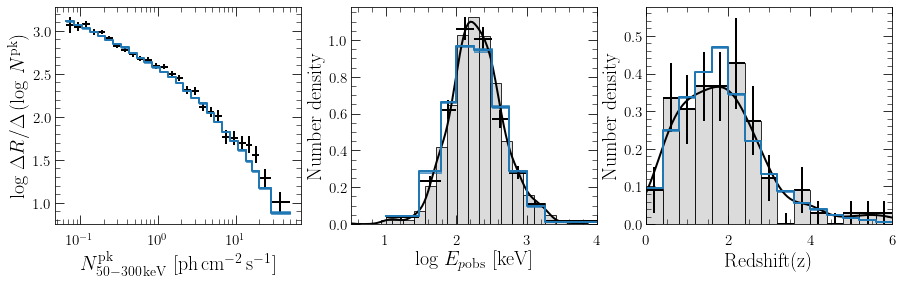

################## k0_LN_nF #################
Sample size :1313
Sample size :82


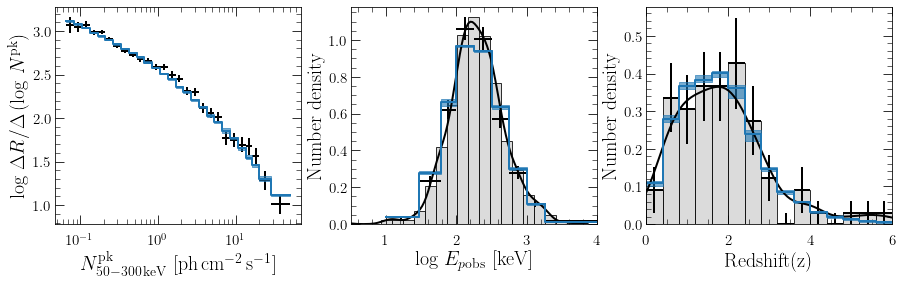

################# k05_LN_nF #################
Sample size :1313
Sample size :82


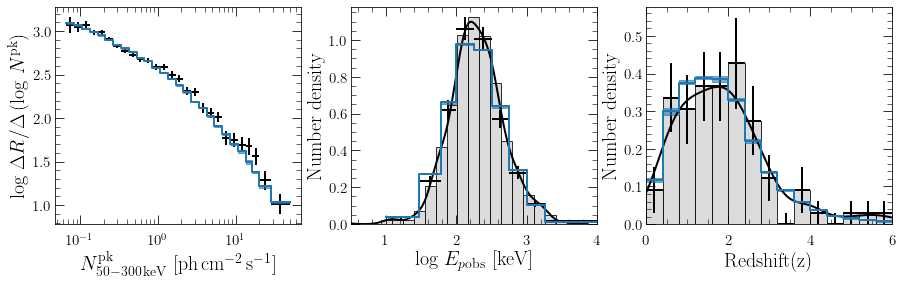

################## k1_LN_nF #################
Sample size :1313
Sample size :82


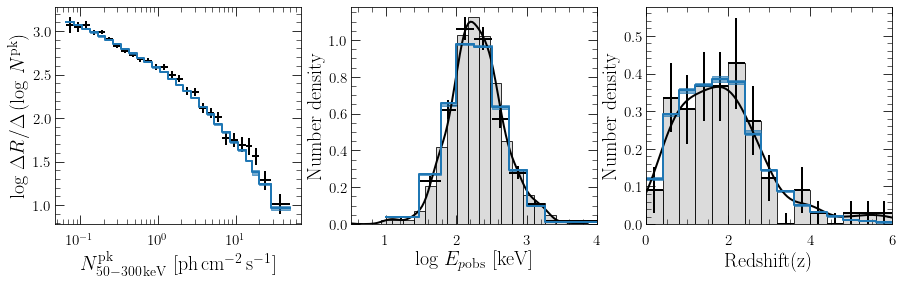

################## k2_LN_nF #################
Sample size :1313
Sample size :82


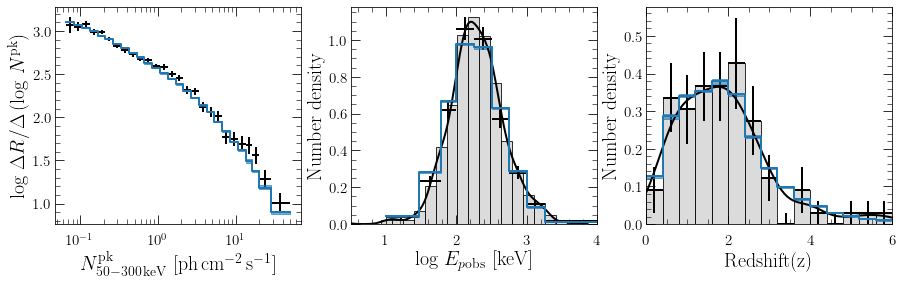

################# kF_A_nSFR #################
Sample size :1313
Sample size :82


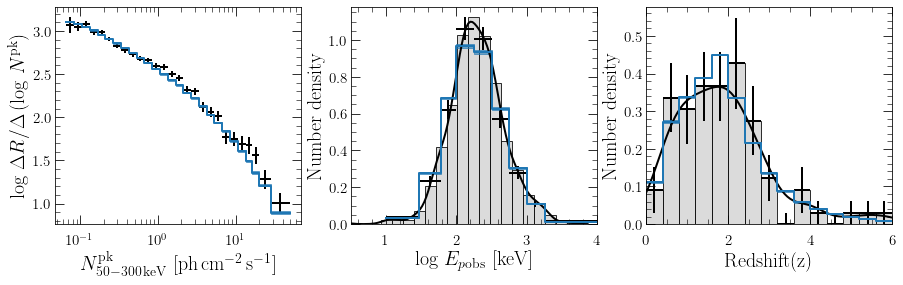

################## k0_A_nF ##################
Sample size :1313
Sample size :82


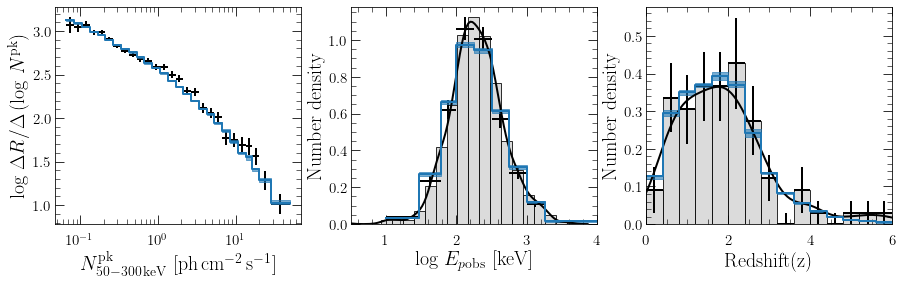

################## k05_A_nF #################
Sample size :1313
Sample size :82


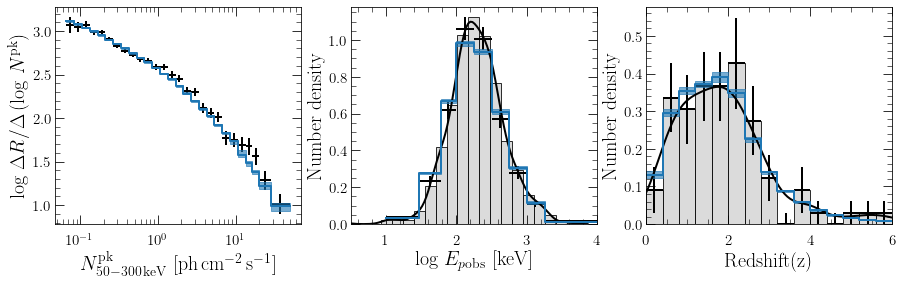

################## k1_A_nF ##################
Sample size :1313
Sample size :82


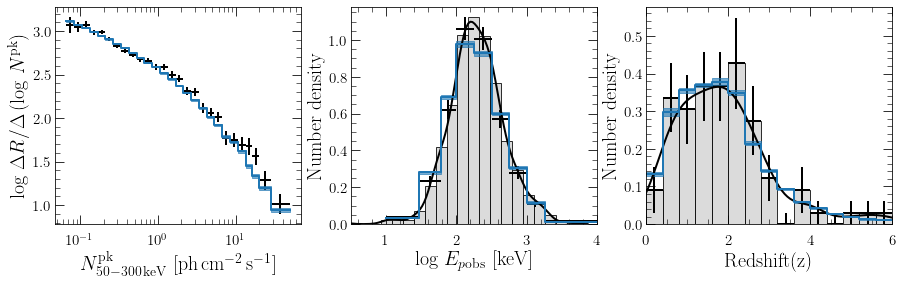

################## k2_A_nF ##################
Sample size :1313
Sample size :82


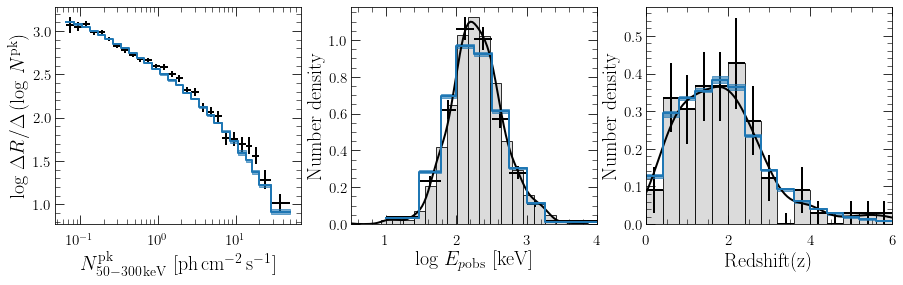

In [48]:
plt.style.use('presentation')
for mod in model_names:
    print(f" {mod} ".center(45, '#'))
    # print(f"Chi2 : {dfs[mod].likelihood_params['chi2_tot']:.1f}")
    # print(f"lnL : {dfs[mod].likelihood_params['lnL_tot']:.1f}")
    fig, axes = plt.subplots(1,3, figsize=(15,4), tight_layout=False)
    # Intensity Constraint
    pf.plot_intensity_constraint(ax=axes[0], pop=None, plot_obs=True)
    q_Stern = mstats.mquantiles(Sterns[mod], prob=[0.16, 0.5, 0.84], axis=0)
    q_Stern = np.log10(q_Stern)
    x_plottable, y_mod_plottable = pf.plottable_hist(obs_constraints['Stern']['bins'][:-1],
                                                  q_Stern[1],
                                                  last_bin_edge=obs_constraints['Stern']['bins'][-1])
    y_mod_errm_plottable = pf.double_array(q_Stern[0])
    y_mod_errp_plottable = pf.double_array(q_Stern[2])
    art, = axes[0].plot(x_plottable, y_mod_plottable)
    axes[0].fill_between(x_plottable,
                         y_mod_errm_plottable,
                         y_mod_errp_plottable,
                         alpha=0.6, color=plt.getp(art,'color'), zorder=plt.getp(art,'zorder'))

    #Spectral Constraint
    pf.plot_spectral_constraint(ax=axes[1], pop=None, plot_obs=True)
    q_EpGBM = mstats.mquantiles(EpGBMs[mod], prob=[0.16, 0.5, 0.84], axis=0)
    x_plottable, y_mod_plottable = pf.plottable_hist(np.log10(obs_constraints['EpGBM']['bins'][:-1]),
                                                  q_EpGBM[1],
                                                  last_bin_edge=np.log10(obs_constraints['EpGBM']['bins'][-1]))
    y_mod_errm_plottable = pf.double_array(q_EpGBM[0])
    y_mod_errp_plottable = pf.double_array(q_EpGBM[2])
    art, = axes[1].plot(x_plottable, y_mod_plottable)
    axes[1].fill_between(x_plottable,
                         y_mod_errm_plottable,
                         y_mod_errp_plottable,
                         alpha=0.6, color=plt.getp(art,'color'), zorder=plt.getp(art,'zorder'))
    # Redshift constraint
    pf.plot_redshift_constraint(ax=axes[2], pop=None, plot_obs=True)
    q_eBAT6 = mstats.mquantiles(eBAT6s[mod], prob=[0.16, 0.5, 0.84], axis=0)
    x_plottable, y_mod_plottable = pf.plottable_hist(obs_constraints['eBAT6']['bins'][:-1],
                                                  q_eBAT6[1],
                                                  last_bin_edge=obs_constraints['eBAT6']['bins'][-1])
    y_mod_errm_plottable = pf.double_array(q_eBAT6[0])
    y_mod_errp_plottable = pf.double_array(q_eBAT6[2])
    art, = axes[2].plot(x_plottable, y_mod_plottable)
    axes[2].fill_between(x_plottable,
                         y_mod_errm_plottable,
                         y_mod_errp_plottable,
                         alpha=0.6, color=plt.getp(art,'color'), zorder=plt.getp(art,'zorder'))

    plt.show()

In [5]:
samp_ECLAIRs = {'ECLAIRs': incl_samples['ECLAIRs'] }
for mod in model_names:
    print(f" {mod} ".center(45, '#'))
    dfs[mod].calc_det_prob(samp_ECLAIRs, **ECLAIRs_prop)

################# kF_LN_nSFR ################
15:57:24.695 [INFO] Starting calculations of detection probability...
15:57:24.696 [DEBUG] ECLAIRs sample:
15:58:13.352 [DEBUG] Done in 48.655 s
################## k0_LN_nF #################
15:58:13.352 [INFO] Starting calculations of detection probability...
15:58:13.353 [DEBUG] ECLAIRs sample:
15:59:02.540 [DEBUG] Done in 49.186 s
################# k05_LN_nF #################
15:59:02.540 [INFO] Starting calculations of detection probability...
15:59:02.541 [DEBUG] ECLAIRs sample:
15:59:51.753 [DEBUG] Done in 49.211 s
################## k1_LN_nF #################
15:59:51.754 [INFO] Starting calculations of detection probability...
15:59:51.754 [DEBUG] ECLAIRs sample:
16:00:41.437 [DEBUG] Done in 49.683 s
################## k2_LN_nF #################
16:00:41.438 [INFO] Starting calculations of detection probability...
16:00:41.439 [DEBUG] ECLAIRs sample:
16:01:30.809 [DEBUG] Done in 49.370 s
################# kF_A_nSFR #################

################# kF_LN_nSFR ################
Chi2 : 48.4
lnL : -38.9
Sample size :1313
Sample size :82


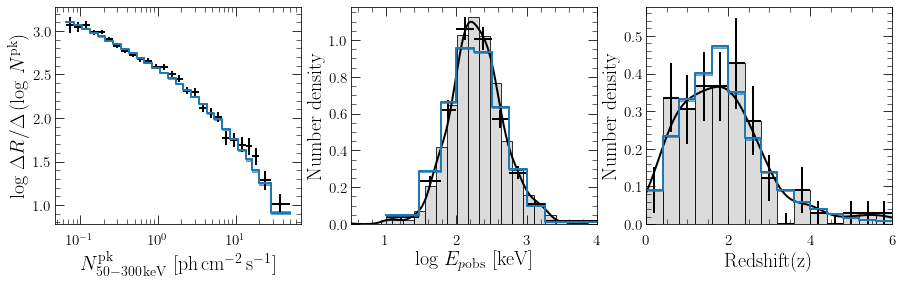

################## k0_LN_nF #################
Chi2 : 48.4
lnL : -44.0
Sample size :1313
Sample size :82


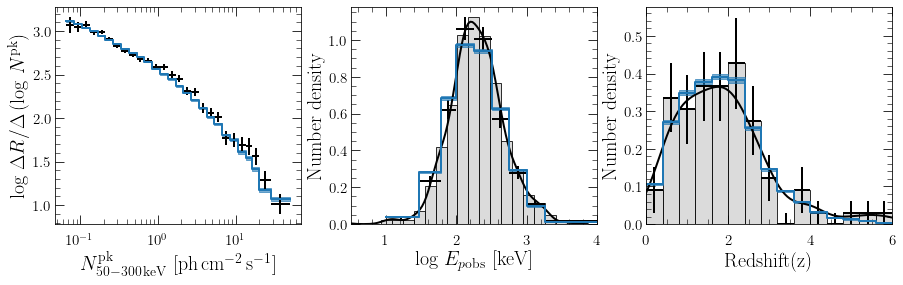

################# k05_LN_nF #################
Chi2 : 45.9
lnL : -38.5
Sample size :1313
Sample size :82


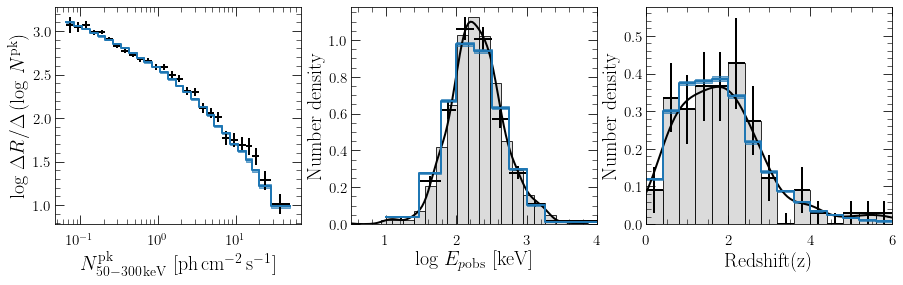

################## k1_LN_nF #################
Chi2 : 41.3
lnL : -32.6
Sample size :1313
Sample size :82


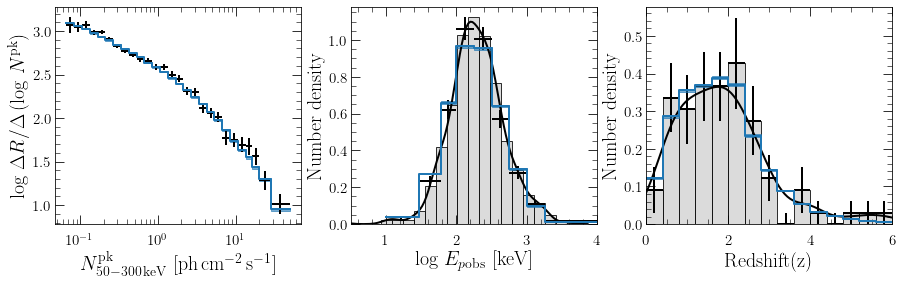

################## k2_LN_nF #################
Chi2 : 53.0
lnL : -46.1
Sample size :1313
Sample size :82


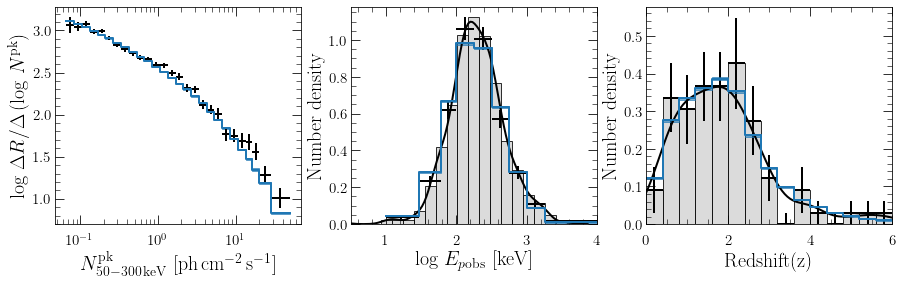

################# kF_A_nSFR #################
Chi2 : 49.3
lnL : -41.7
Sample size :1313
Sample size :82


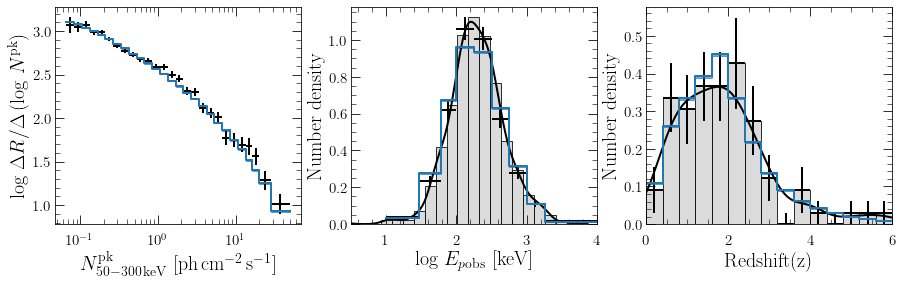

################## k0_A_nF ##################
Chi2 : 53.8
lnL : -56.3
Sample size :1313
Sample size :82


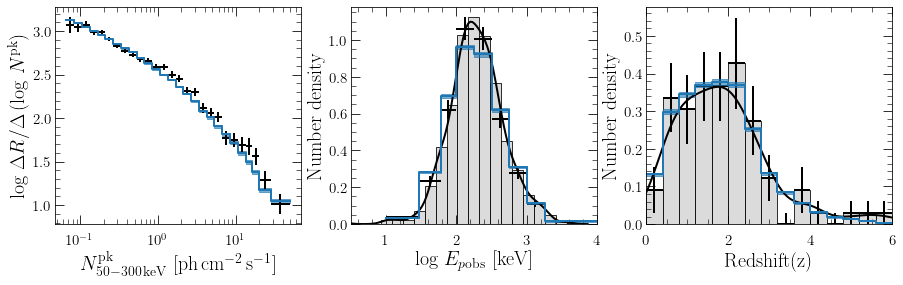

################## k05_A_nF #################
Chi2 : 48.6
lnL : -45.4
Sample size :1313
Sample size :82


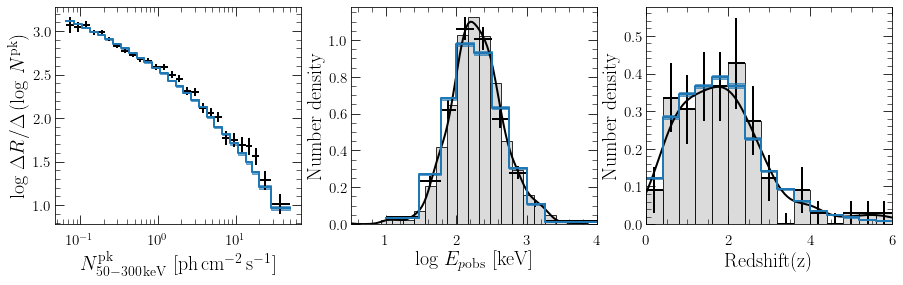

################## k1_A_nF ##################
Chi2 : 51.6
lnL : -47.0
Sample size :1313
Sample size :82


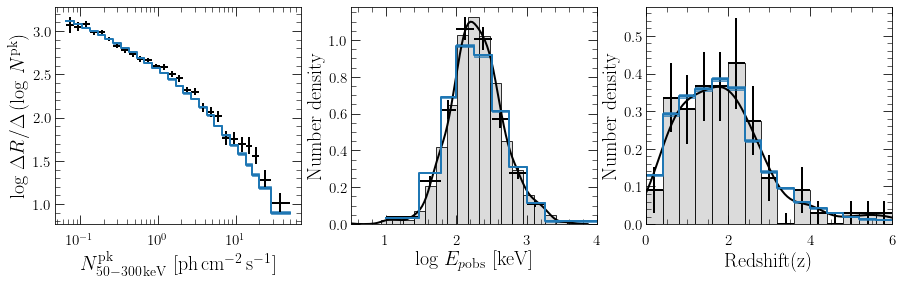

################## k2_A_nF ##################
Chi2 : 47.4
lnL : -39.6
Sample size :1313
Sample size :82


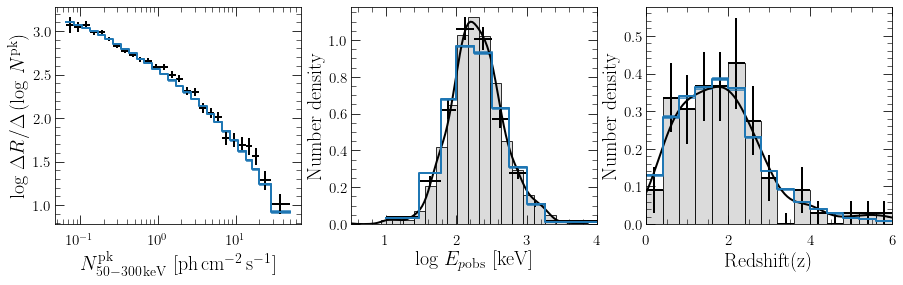

In [11]:
for mod in model_names:
    plt.style.use('presentation')
    print(f" {mod} ".center(45, '#'))
    print(f"Chi2 : {dfs[mod].likelihood_params['chi2_tot']:.1f}")
    print(f"lnL : {dfs[mod].likelihood_params['lnL_tot']:.1f}")
    fig, axes = plt.subplots(1,3, figsize=(15,4), tight_layout=False)
    # Intensity Constraint
    pf.plot_intensity_constraint(ax=axes[0], pop=dfs[mod], plot_obs=True)
    # Spectral Constraint
    pf.plot_spectral_constraint(ax=axes[1], pop=dfs[mod], plot_obs=True)
    # Redshift constraint
    pf.plot_redshift_constraint(ax=axes[2], pop=dfs[mod], plot_obs=True)

    plt.show()

In [6]:
# Calculate HETE2 frac
for mod in model_names:
    print(f" {mod} ".center(45, '#'))
#     instr_HETE2 = {'FREGATE':{'Emin':30.0, 'Emax':400.0},
#                    'WXM':{'Emin':2.0, 'Emax':10.0},
#                    'WXML':{'Emin':2.0, 'Emax':30.0}}
#     ph.calc_peak_photon_flux(GRB_prop=dfs[mod].properties,
#                             instruments=instr_HETE2)
#     ph.calc_peak_energy_flux(GRB_prop=dfs[mod].properties,
#                             instruments=instr_HETE2)
#     _cond_WXM = (dfs[mod].properties['pht_pflx_WXM'] >= 1)
#     _cond_FRE = (dfs[mod].properties['pht_pflx_FREGATE'] >= 1)
    pdet_HETE2 = np.where(_cond_WXM | _cond_FRE,
                          np.ones(dfs[mod].Nb_GRBs),
                          np.zeros(dfs[mod].Nb_GRBs))
    dfs[mod].properties['pdet_HETE2'] = pdet_HETE2
#     softness = dfs[mod].properties['erg_pflx_WXML']/dfs[mod].properties['erg_pflx_FREGATE']
#     dfs[mod].properties['softness'] = softness
    cond = (dfs[mod].properties['pdet_HETE2'] == 1) & (dfs[mod].properties['softness'] >= 1)
    frac_XRF = len(dfs[mod].properties[cond])/len(dfs[mod].properties[(dfs[mod].properties['pdet_HETE2'] == 1)])
    print('Fraction of XRF: {}'.format(frac_XRF))

################# kF_LN_nSFR ################
12:10:46.608 [INFO] Starting calculations of peak photon fluxes...
12:10:46.609 [DEBUG] For FREGATE instrument [30.0, 400.0 keV]:
12:10:58.264 [DEBUG] Done in 11.654 s
12:10:58.264 [DEBUG] For WXM instrument [2.0, 10.0 keV]:
12:11:09.333 [DEBUG] Done in 11.068 s
12:11:09.334 [DEBUG] For WXML instrument [2.0, 30.0 keV]:
12:11:20.410 [DEBUG] Done in 11.076 s
12:11:20.411 [INFO] Starting calculations of peak energy fluxes...
12:11:20.411 [DEBUG] For FREGATE instrument [30.0, 400.0 keV]:
12:11:31.938 [DEBUG] Done in 11.526 s
12:11:31.939 [DEBUG] For WXM instrument [2.0, 10.0 keV]:
12:11:43.113 [DEBUG] Done in 11.174 s
12:11:43.113 [DEBUG] For WXML instrument [2.0, 30.0 keV]:
12:11:53.979 [DEBUG] Done in 10.865 s
Fraction of XRF: 0.08767172664640491
################## k0_LN_nF #################
12:11:54.503 [INFO] Starting calculations of peak photon fluxes...
12:11:54.504 [DEBUG] For FREGATE instrument [30.0, 400.0 keV]:
12:12:06.197 [DEBUG] Do

12:22:22.120 [DEBUG] For WXM instrument [2.0, 10.0 keV]:
12:22:33.177 [DEBUG] Done in 11.056 s
12:22:33.178 [DEBUG] For WXML instrument [2.0, 30.0 keV]:
12:22:44.249 [DEBUG] Done in 11.071 s
12:22:44.250 [INFO] Starting calculations of peak energy fluxes...
12:22:44.251 [DEBUG] For FREGATE instrument [30.0, 400.0 keV]:
12:22:55.362 [DEBUG] Done in 11.111 s
12:22:55.363 [DEBUG] For WXM instrument [2.0, 10.0 keV]:
12:23:06.368 [DEBUG] Done in 11.004 s
12:23:06.369 [DEBUG] For WXML instrument [2.0, 30.0 keV]:
12:23:17.485 [DEBUG] Done in 11.116 s
Fraction of XRF: 0.3167151060998669
################## k2_A_nF ##################
12:23:17.894 [INFO] Starting calculations of peak photon fluxes...
12:23:17.894 [DEBUG] For FREGATE instrument [30.0, 400.0 keV]:
12:23:29.322 [DEBUG] Done in 11.427 s
12:23:29.323 [DEBUG] For WXM instrument [2.0, 10.0 keV]:
12:23:40.426 [DEBUG] Done in 11.103 s
12:23:40.427 [DEBUG] For WXML instrument [2.0, 30.0 keV]:
12:23:51.413 [DEBUG] Done in 10.986 s
12:23:51.

In [59]:
# Calculate HETE2 frac
for mod in model_names:
    print(f" {mod} ".center(45, '#'))
#     instr_HETE2 = {'FREGATE':{'Emin':30.0, 'Emax':400.0},
#                    'WXM':{'Emin':2.0, 'Emax':10.0},
#                    'WXML':{'Emin':2.0, 'Emax':30.0}}
#     ph.calc_peak_photon_flux(GRB_prop=dfs[mod].properties,
#                             instruments=instr_HETE2)
#     ph.calc_peak_energy_flux(GRB_prop=dfs[mod].properties,
#                             instruments=instr_HETE2)
    _cond_WXM = (dfs[mod].properties['pht_pflx_WXM'] >= 1)
    _cond_FRE = (dfs[mod].properties['pht_pflx_FREGATE'] >= 1)
    pdet_HETE2 = np.where(_cond_WXM | _cond_FRE,
                          np.ones(dfs[mod].Nb_GRBs),
                          np.zeros(dfs[mod].Nb_GRBs))
    dfs[mod].properties['pdet_HETE2'] = pdet_HETE2
    softness = dfs[mod].properties['erg_pflx_WXML']/dfs[mod].properties['erg_pflx_FREGATE']
    dfs[mod].properties['softness'] = softness
    cond = (dfs[mod].properties['pdet_HETE2'] == 1) & (dfs[mod].properties['softness'] >= 1)
    frac_XRF = len(dfs[mod].properties[cond])/len(dfs[mod].properties[(dfs[mod].properties['pdet_HETE2'] == 1)])
    print('Fraction of XRF: {}'.format(frac_XRF))

################# kF_LN_nSFR ################
Fraction of XRF: 0.08623094123238256
################## k0_LN_nF #################
Fraction of XRF: 0.09605115974757815
################# k05_LN_nF #################
Fraction of XRF: 0.09716443431176973
################## k1_LN_nF #################
Fraction of XRF: 0.0780516067622654
################## k2_LN_nF #################
Fraction of XRF: 0.08136233368131977
################# kF_A_nSFR #################
Fraction of XRF: 0.1594936460043048
################## k0_A_nF ##################
Fraction of XRF: 0.19352977381135558
################## k05_A_nF #################
Fraction of XRF: 0.16185089833479405
################## k1_A_nF ##################
Fraction of XRF: 0.21733976722263185
################## k2_A_nF ##################
Fraction of XRF: 0.15958181638768718


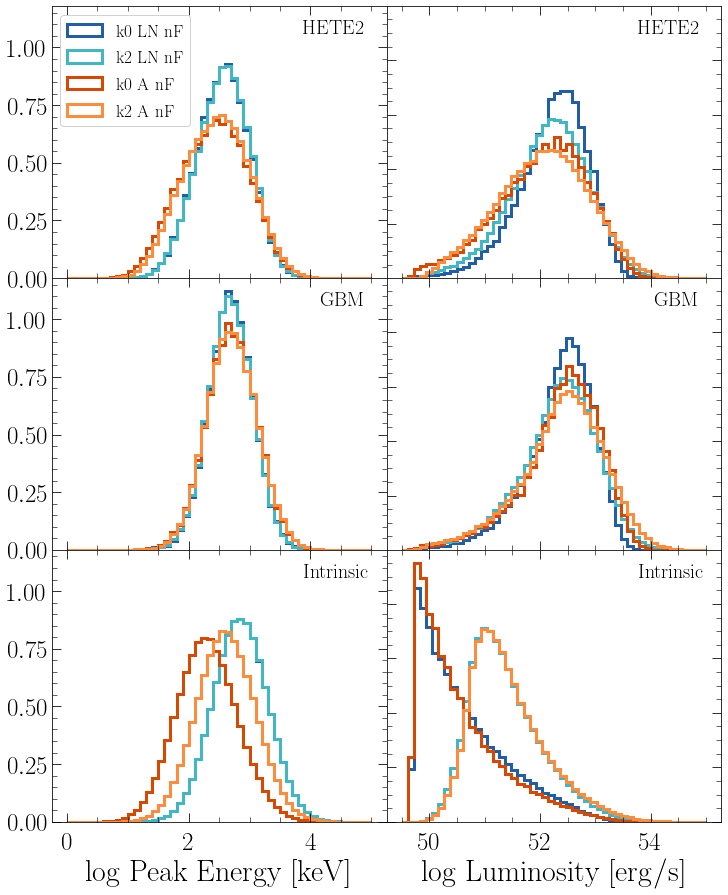

In [61]:
# Look at Ep and L histograms
fig, axes = plt.subplots(3,2, figsize=(12,15), sharex='col', sharey='col', tight_layout=False)
fig.subplots_adjust(hspace=0, wspace=0)
bins_Ep = np.linspace(0, 5, 51)
bins_L = np.linspace(49.5, 55, 51)
for i, mod in enumerate(model_names_ks):
# i=0
    HETE2_cond = dfs[mod].properties['pdet_HETE2'] == 1
    GBM_cond = dfs[mod].properties['pht_pflx_BATSE'] >= 0.9
    axes[0,0].hist(np.log10(dfs[mod].properties[HETE2_cond]['Ep']), bins=bins_Ep,
                   histtype='step', color=colors[i], density=True, linewidth=3, label=mod.replace('_',' '))
    axes[1,0].hist(np.log10(dfs[mod].properties[GBM_cond]['Ep']), bins=bins_Ep,
                   histtype='step', color=colors[i], density=True, linewidth=3, label=mod.replace('_',' '))
    axes[0,1].hist(np.log10(dfs[mod].properties[HETE2_cond]['L']), bins=bins_L,
                   histtype='step', color=colors[i], density=True, linewidth=3, label=mod.replace('_',' '))
    axes[1,1].hist(np.log10(dfs[mod].properties[GBM_cond]['L']), bins=bins_L,
                   histtype='step', color=colors[i], density=True, linewidth=3, label=mod.replace('_',' '))
    axes[2,0].hist(np.log10(dfs[mod].properties['Ep']), bins=bins_Ep,
                   histtype='step', color=colors[i], density=True, linewidth=3, label=mod.replace('_',' '))
    axes[2,1].hist(np.log10(dfs[mod].properties['L']), bins=bins_L,
                   histtype='step', color=colors[i], density=True, linewidth=3, label=mod.replace('_',' '))

axes[0,1].tick_params(axis='both', which='both', labelleft=False, labelbottom=False)
axes[1,1].tick_params(axis='y', which='both', labelleft=False)
axes[2,1].tick_params(axis='y', which='both', labelleft=False)
axes[0,0].legend(loc='upper left')
axes[2,0].set_xlabel(r'log Peak Energy $\rm{[keV]}$')
axes[2,1].set_xlabel(r'log Luminosity $\rm{[erg/s]}$')
axes[0,0].text(0.75, 0.9, 'HETE2', transform=axes[0,0].transAxes, **{'size':20})
axes[0,1].text(0.75, 0.9, 'HETE2', transform=axes[0,1].transAxes, **{'size':20})
axes[1,0].text(0.8, 0.9, 'GBM', transform=axes[1,0].transAxes, **{'size':20})
axes[1,1].text(0.8, 0.9, 'GBM', transform=axes[1,1].transAxes, **{'size':20})
axes[2,0].text(0.75, 0.9, 'Intrinsic', transform=axes[2,0].transAxes, **{'size':20})
axes[2,1].text(0.75, 0.9, 'Intrinsic', transform=axes[2,1].transAxes, **{'size':20})
plt.show()

# fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/HETE2_GBM_Ep_L_dist.pdf', bbox_inches='tight')


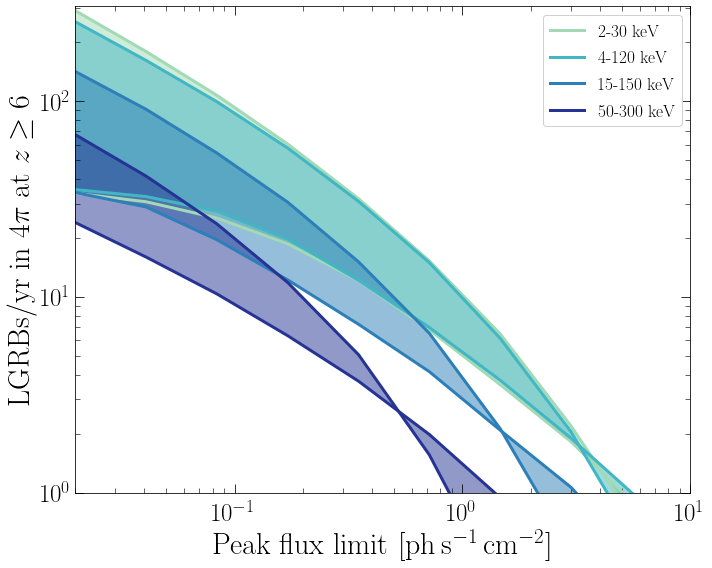

In [9]:
# Look at the predicted number of high-z bursts

z_cut = 6
# mod = 'k0_LN_nF'
pflx_cuts = np.logspace(-1.7,1.41, 11)
_instrum = ['THESEUS', 'ECLAIRsS', 'BAT', 'BATSE']
instrum_highz = pd.DataFrame(io.included_instruments(_instrum, instruments))
_colors = ['#a1dab4','#41b6c4','#2c7fb8','#253494']
R_highz = {}

plt.style.use('paper')
fig, ax = plt.subplots(figsize=(10,8))
    
# for k, mod in enumerate(model_names_ks):
#     print(f" {mod} ".center(45, '#'))

#     R_highz[mod] = np.zeros((len(pflx_cuts),len(_instrum)))
#     for j, ins in enumerate(_instrum):
#         for i, pflx_cut in enumerate(pflx_cuts):
#             cond = (dfs[mod].properties[f'pht_pflx_{ins}'] >= pflx_cut) & (dfs[mod].properties['z'] >= z_cut)
#             R_highz[mod][i,j] = len(dfs[mod].properties[cond])/dfs[mod].normalization['T_sim']
#         ax.fill_between(pflx_cuts,
#                         R_highz['k0_A_nF'][:,j],
#                         R_highz['k2_A_nF'][:,j],
#                         color=_colors[j],
#                         alpha=0.5)
#         ax.plot(pflx_cuts, R_highz['k0_A_nF'][:,j], color=_colors[j])
#         ax.plot(pflx_cuts, R_highz['k2_A_nF'][:,j], label=f'{_Emin[j]:.0f}-{_Emax[j]:.0f} keV', color=_colors[j])

ax.legend()
ax.set_xlim(xmin=2e-2, xmax=10)
ax.set_ylim(ymin=1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Peak flux limit $[\rm ph\,s^{-1}\,cm^{-2}]$')
ax.set_ylabel(r'LGRBs/yr in $4\pi~{\rm at}~z\geq6$')
fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/High_z_rate.pdf', bbox_inches='tight')
plt.show()

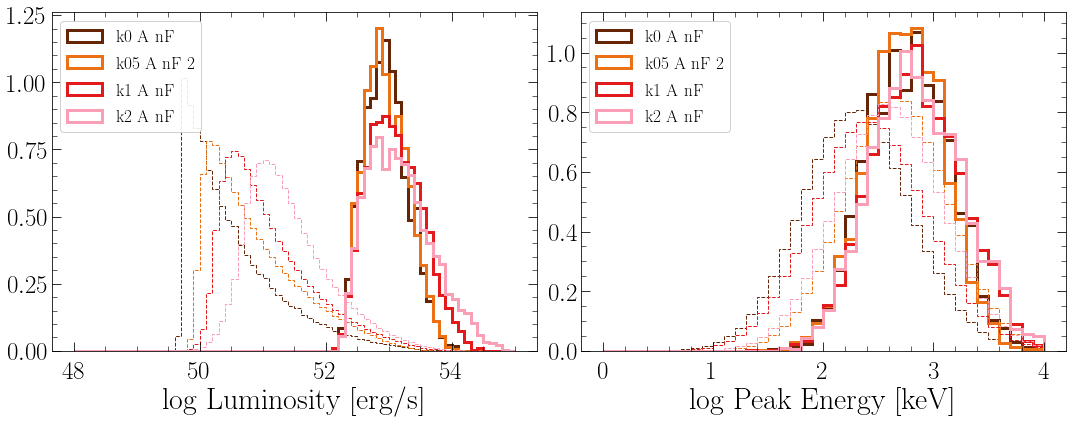

In [46]:
# Look at hist of Ep and L for z>6 GRBs above 0.3 ph/s/cm2
pflx_lim = 0.4 # ph/s/cm2 in 15-150 keV
z_lim = 6
_colors = ['#081d58','#225ea8', '#1d91c0','#7fcdbb']
_colors = ['#662506', '#ec7014', '#e31a1c','#fa9fb5']

fig, axes = plt.subplots(1,2, figsize=(15,6))
ax1 = axes[0]
ax2 = axes[1]
for k, mod in enumerate(['k0_A_nF', 'k05_A_nF_2', 'k1_A_nF', 'k2_A_nF']):
    cond = (dfs[mod].properties['z'] >= z_lim) & (dfs[mod].properties['pht_pflx_BAT'] >= pflx_lim)
    ax1.hist(np.log10(dfs[mod].properties[cond]['L']), density=True, bins=np.linspace(48, 55, 71),
             histtype='step', color=_colors[k], lw=3, label=mod.replace('_', ' '))
    ax2.hist(np.log10(dfs[mod].properties[cond]['Ep']), density=True, bins=np.linspace(0, 4, 41),
             histtype='step', color=_colors[k], lw=3, label=mod.replace('_', ' '))
    ax1.hist(np.log10(dfs[mod].properties['L']), density=True, bins=np.linspace(48, 55, 71),
             histtype='step', color=_colors[k], lw=1, ls='--')
    ax2.hist(np.log10(dfs[mod].properties['Ep']), density=True, bins=np.linspace(0, 4, 41),
             histtype='step', color=_colors[k], lw=1, ls='--')  

ax1.set_xlabel('log Luminosity [erg/s]')
ax2.set_xlabel('log Peak Energy [keV]')
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

10:33:45.811 [WARNING] No handles with labels found to put in legend.


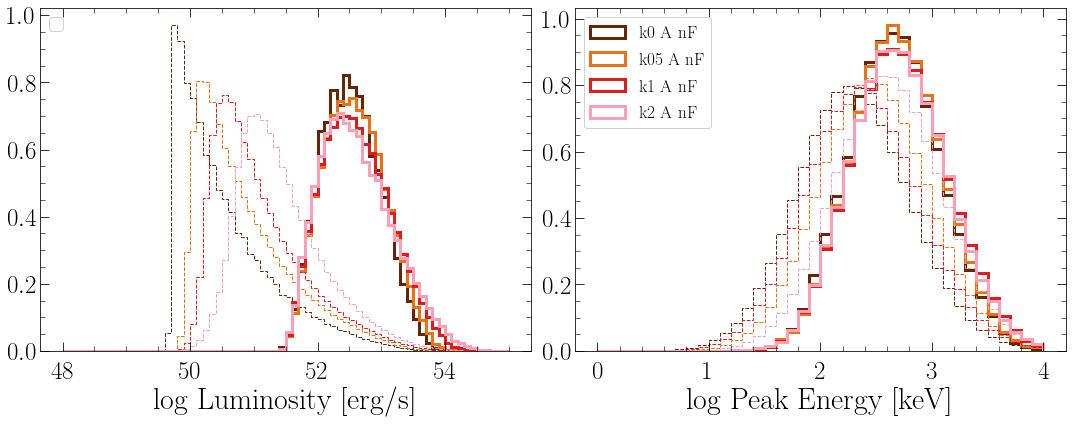

In [54]:
# Look at hist of Ep and L for z>3 GRBs above 0.3 ph/s/cm2
plt.style.use('paper')
pflx_lim = 0.4 # ph/s/cm2 in 15-150 keV
z_lim = 3
_colors = ['#081d58','#225ea8', '#1d91c0','#7fcdbb']
_colors = ['#662506', '#ec7014', '#e31a1c','#fa9fb5']

fig, axes = plt.subplots(1,2, figsize=(15,6))
ax1 = axes[0]
ax2 = axes[1]
for k, mod in enumerate(['k0_A_nF', 'k05_A_nF', 'k1_A_nF', 'k2_A_nF']):
    cond = (dfs[mod].properties['z'] >= z_lim) & (dfs[mod].properties['pht_pflx_BAT'] >= pflx_lim)
    ax1.hist(np.log10(dfs[mod].properties[cond]['L']), density=True, bins=np.linspace(48, 55, 71),
             histtype='step', color=_colors[k], lw=3)
    ax2.hist(np.log10(dfs[mod].properties[cond]['Ep']), density=True, bins=np.linspace(0, 4, 41),
             histtype='step', color=_colors[k], lw=3, label=mod.replace('_', ' '))
    ax1.hist(np.log10(dfs[mod].properties['L']), density=True, bins=np.linspace(48, 55, 71),
             histtype='step', color=_colors[k], lw=1, ls='--')
    ax2.hist(np.log10(dfs[mod].properties['Ep']), density=True, bins=np.linspace(0, 4, 41),
             histtype='step', color=_colors[k], lw=1, ls='--')  

ax1.set_xlabel('log Luminosity [erg/s]')
ax2.set_xlabel('log Peak Energy [keV]')
ax2.legend(loc='upper left')

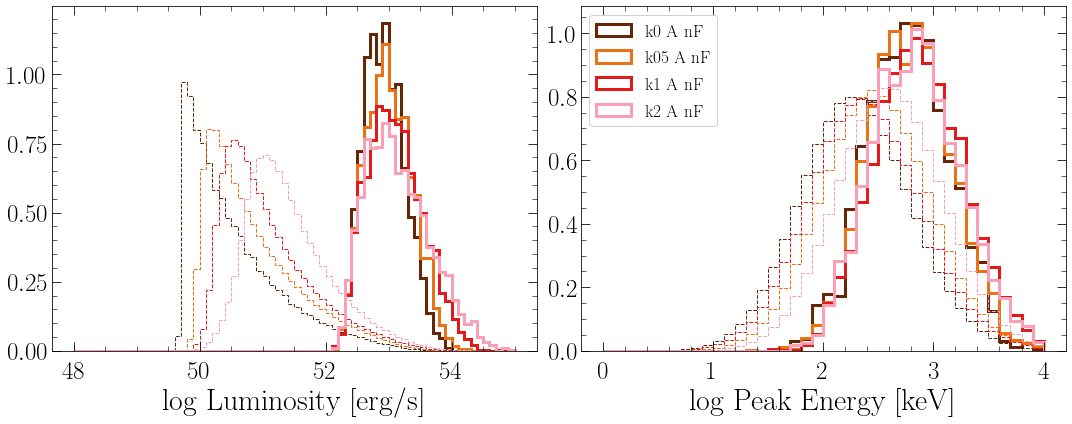

In [67]:
# Look at hist of Ep and L for z>6 GRBs above 0.3 ph/s/cm2
plt.style.use('paper')
pflx_lim = 0.4 # ph/s/cm2 in 15-150 keV
z_lim = 6
_colors = ['#081d58','#225ea8', '#1d91c0','#7fcdbb']
_colors = ['#662506', '#ec7014', '#e31a1c','#fa9fb5']

fig, axes = plt.subplots(1,2, figsize=(15,6))
ax1 = axes[0]
ax2 = axes[1]
for k, mod in enumerate(['k0_A_nF', 'k05_A_nF', 'k1_A_nF', 'k2_A_nF']):
    cond = (dfs[mod].properties['z'] >= z_lim) & (dfs[mod].properties['pht_pflx_BAT'] >= pflx_lim)
    ax1.hist(np.log10(dfs[mod].properties[cond]['L']), density=True, bins=np.linspace(48, 55, 71),
             histtype='step', color=_colors[k], lw=3)
    ax2.hist(np.log10(dfs[mod].properties[cond]['Ep']), density=True, bins=np.linspace(0, 4, 41),
             histtype='step', color=_colors[k], lw=3, label=mod.replace('_', ' '))
    ax1.hist(np.log10(dfs[mod].properties['L']), density=True, bins=np.linspace(48, 55, 71),
             histtype='step', color=_colors[k], lw=1, ls='--')
    ax2.hist(np.log10(dfs[mod].properties['Ep']), density=True, bins=np.linspace(0, 4, 41),
             histtype='step', color=_colors[k], lw=1, ls='--')  

ax1.set_xlabel('log Luminosity [erg/s]')
ax2.set_xlabel('log Peak Energy [keV]')
ax2.legend(loc='upper left')

################## k0_A_nF ##################
8.483439834659605e-10
################# k1_A_nF_2 #################
7.592792364161508e-10
################## k2_A_nF ##################
8.643391266920359e-10


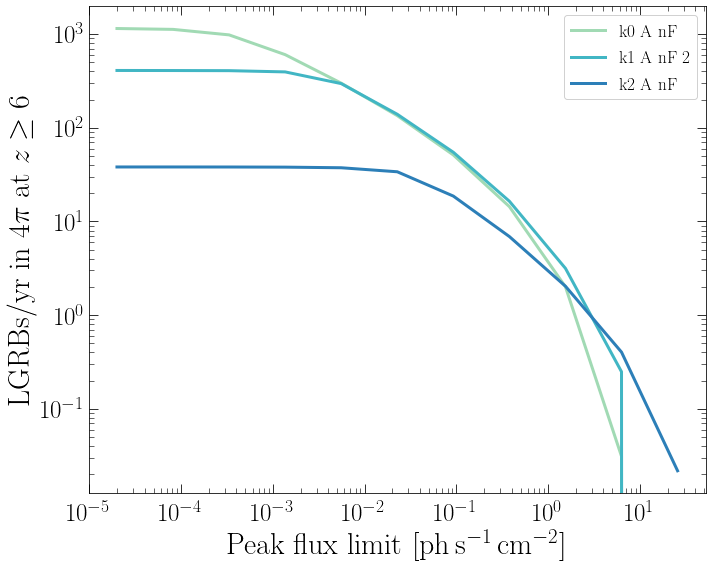

In [131]:
# Look at the predicted number of high-z bursts

z_cut = 6
# mod = 'k0_LN_nF'
pflx_cuts = np.logspace(-4.7,1.41, 11)
_instrum = ['THESEUS', 'ECLAIRsS', 'BAT', 'BATSE']
instrum_highz = ['THESEUS', 'ECLAIRsS', 'BAT', 'BATSE']#pd.DataFrame(io.included_instruments(_instrum, instruments))
_colors = ['#a1dab4','#41b6c4','#2c7fb8','#253494']
R_highz = {}

plt.style.use('paper')
fig, ax = plt.subplots(figsize=(10,8))
    
for k, mod in enumerate(['k0_A_nF', 'k1_A_nF_2', 'k2_A_nF']):
    print(f" {mod} ".center(45, '#'))

    R_highz[mod] = np.zeros((len(pflx_cuts),len(_instrum)))
    for j, ins in enumerate(_instrum):
        for i, pflx_cut in enumerate(pflx_cuts):
            cond = (dfs[mod].properties[f'pht_pflx_{ins}'] >= pflx_cut) & (dfs[mod].properties['z'] >= z_cut)
            R_highz[mod][i,j] = len(dfs[mod].properties[cond])/dfs[mod].normalization['T_sim']
#         ax.fill_between(pflx_cuts,
#                         R_highz['k0_A_nF'][:,j],
#                         R_highz['k2_A_nF'][:,j],
#                         color=_colors[j],
#                         alpha=0.5)
    ax.plot(pflx_cuts, R_highz[mod][:,2],#/len(dfs[mod].properties[(dfs[mod].properties['z'] >= z_cut)]),
            color=_colors[k], label=mod.replace('_',' '))
#     ax.plot(pflx_cuts, R_highz['k1_A_nF'][:,j], color=_colors[k])
#     ax.plot(pflx_cuts, R_highz['k2_A_nF'][:,j], label=f'{_Emin[j]:.0f}-{_Emax[j]:.0f} keV', color=_colors[j])
    print(dfs[mod].normalization['nGRB0'])
ax.legend()
# ax.set_xlim(xmin=2e-2, xmax=10)
# ax.set_ylim(ymin=1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Peak flux limit $[\rm ph\,s^{-1}\,cm^{-2}]$')
ax.set_ylabel(r'LGRBs/yr in $4\pi~{\rm at}~z\geq6$')
# ax.set_ylabel(r'Fraction of LGRBs in $4\pi~{\rm at}~z\geq6$')
fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/High_z_rate.pdf', bbox_inches='tight')
plt.show()

################## k0_LN_nF #################
Size SHOALS sample: 30860
Size eBAT6 sample: 15504
SHOALS is 1.99 times larger than eBAT6
################## k2_LN_nF #################
Size SHOALS sample: 124762
Size eBAT6 sample: 67750
SHOALS is 1.84 times larger than eBAT6
################## k0_A_nF ##################
Size SHOALS sample: 35997
Size eBAT6 sample: 18975
SHOALS is 1.90 times larger than eBAT6
################## k2_A_nF ##################
Size SHOALS sample: 135448
Size eBAT6 sample: 73262
SHOALS is 1.85 times larger than eBAT6


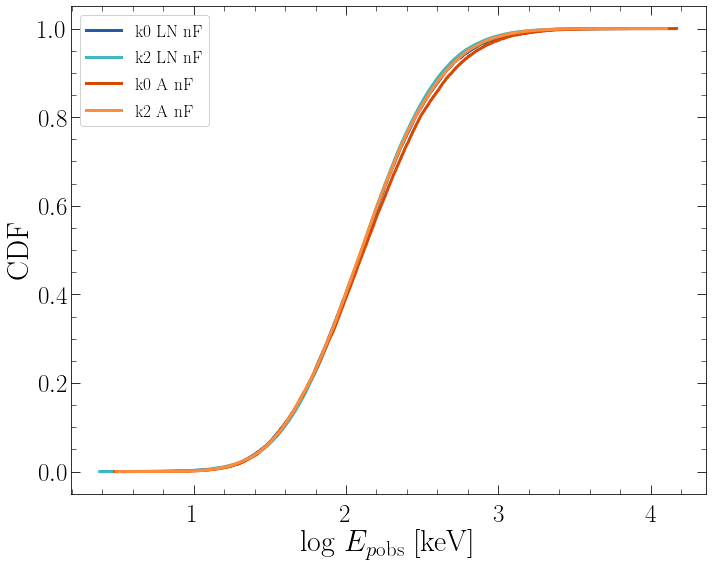

In [63]:
# Look at cumulative distribution of eBAT6
mod = 'k0_A_nF'
i=0
fig, ax = plt.subplots()
for i, mod in enumerate(model_names_ks):
    print(f" {mod} ".center(45, '#'))
    cond_SH = dfs[mod].properties['erg_flnc_BAT'] >= 1e-6
    cond = dfs[mod].properties['pht_pflx_BAT'] >= 2.6
    print("Size SHOALS sample: {}".format(len(dfs[mod].properties[cond_SH])))
    print("Size eBAT6 sample: {}".format(len(dfs[mod].properties[cond])))
    print("SHOALS is {:.2f} times larger than eBAT6".format(len(dfs[mod].properties[cond_SH])/len(dfs[mod].properties[cond])))
    x, y = st.unbinned_empirical_cdf(np.log10(dfs[mod].properties[cond]['Epobs']).to_numpy())
    ax.plot(x, y, color=colors[i], drawstyle='steps-post', label=mod.replace('_',' '))
ax.legend(loc='upper left')
ax.set_ylabel('CDF')
ax.set_xlabel(r'log $E_{p \rm obs}$ [keV]')
plt.show()


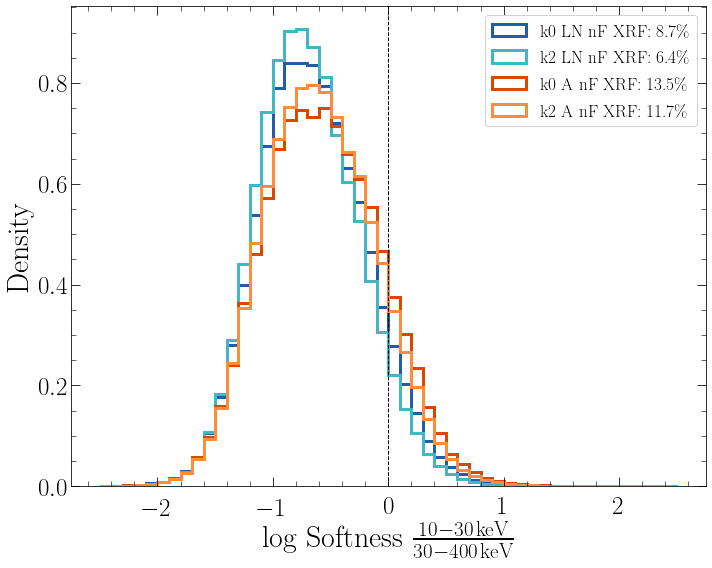

In [137]:
# Softness of SVOM GRBs
fig, ax = plt.subplots()
for i, mod in enumerate(model_names_ks):

    softness = dfs[mod].properties['erg_pflx_WXML']/dfs[mod].properties['erg_pflx_FREGATE']
    cond = softness >= 1
    frac_XRF = np.sum(dfs[mod].properties[cond]['pdet_ECLAIRs_tot'])/np.sum(dfs[mod].properties['pdet_ECLAIRs_tot'])
    ax.hist(np.log10(softness), weights=dfs[mod].properties['pdet_ECLAIRs_tot'], histtype='step',
            bins=np.linspace(-2.5, 2.5, 51), color=colors[i], density=True, linewidth=3,
            label=r'{} XRF: {:.1f}\%'.format(mod.replace('_',' '), 100*frac_XRF))

ax.axvline(0, ls='--', color='k', lw=1)
ax.set_xlabel(r'log Softness $\frac{10-30\,\rm keV}{30-400\,\rm keV}$')
ax.set_ylabel('Density')
ax.legend()
plt.show()
fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/softness_SVOM.pdf', bbox_inches='tight')


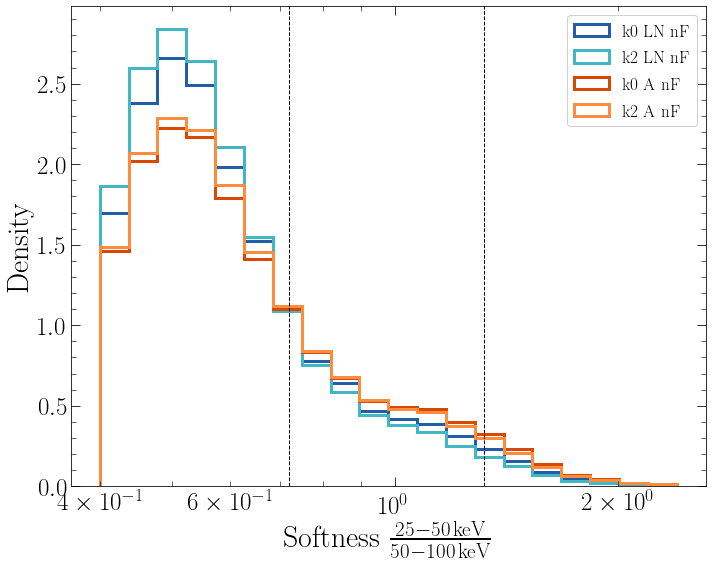

In [159]:
# for mod in model_names:
#     print(f" {mod} ".center(45, '#'))
#     dfs[mod].properties.rename(columns={'softness': 'softness_HETE2'}, inplace=True)
#     instr_BAT = {'BAT2':{'Emin':25.0, 'Emax':50.0},
#                  'BAT3':{'Emin':50.0, 'Emax':100.0},}
#     ph.calc_photon_fluence(GRB_prop=dfs[mod].properties,
#                             instruments=instr_BAT)
#     ph.calc_energy_fluence(GRB_prop=dfs[mod].properties,
#                             instruments=instr_BAT)
#     softness = dfs[mod].properties['erg_flnc_BAT2']/dfs[mod].properties['erg_flnc_BAT3']
#     dfs[mod].properties['softness_Swift'] = softness

# Softness of BAT GRBs
fig, ax = plt.subplots()
for i, mod in enumerate(model_names_ks):
    cond = dfs[mod].properties['pht_pflx_BAT'] > 0.4
    ax.hist(dfs[mod].properties[cond]['softness_Swift'], histtype='step',
            bins=np.logspace(np.log10(0.4), np.log10(2.4), 21), color=colors[i], density=True, linewidth=3,
            label=mod.replace('_',' '))

ax.axvline(1.32, ls='--', color='k', lw=1)
ax.axvline(0.72, ls='--', color='k', lw=1)
ax.set_xlabel(r' Softness $\frac{25-50\,\rm keV}{50-100\,\rm keV}$')
ax.set_ylabel('Density')
ax.set_xscale('log')

ax.legend()

# pf.cool_hist2d(np.log10(dfs[mod].properties['erg_flnc_BAT2']),
#                np.log10(dfs[mod].properties['erg_flnc_BAT3']),
#                c=np.log10(dfs[mod].properties['Ep']),
#                s=10, edgecolor='k', linewidth=0.5,)
plt.show()
# fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/softness_Swift.pdf', bbox_inches='tight')


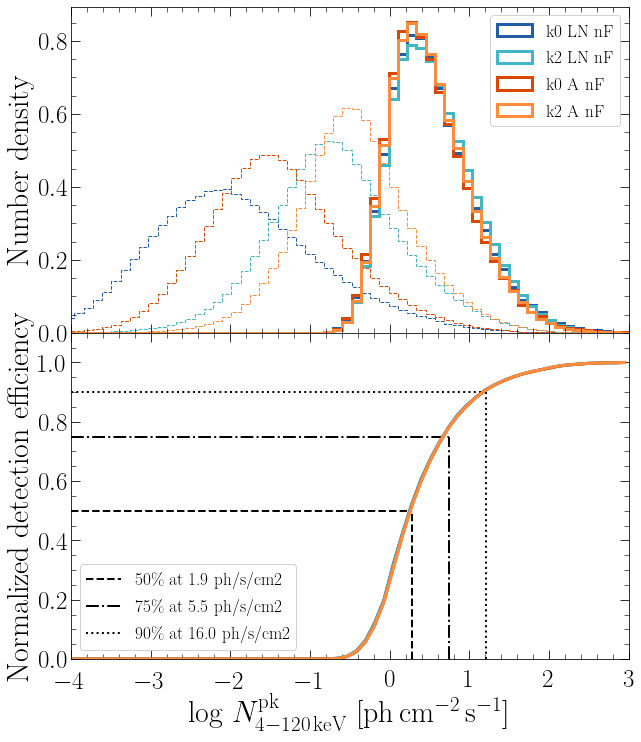

In [103]:
# look at logN logP of SVOM/ECLAIRs in 4-120 keV
from matplotlib.lines import Line2D

fig, axes = plt.subplots(2, figsize=(10,12),tight_layout=False, sharex=True)
for i, mod in enumerate(model_names_ks):
    bins=np.linspace(-5,3,70)
    axes[0].hist(np.log10(dfs[mod].properties['pht_pflx_ECLAIRsS']),
            weights=dfs[mod].properties['pdet_ECLAIRs_tot'], linewidth=3, label=mod.replace('_',' '),
            bins=bins, density=True, histtype='step', color=colors[i])
    axes[0].hist(np.log10(dfs[mod].properties['pht_pflx_ECLAIRsS']),
            linewidth=1, linestyle='--',
            bins=bins, density=True, histtype='step', color=colors[i])
    n_ECL, bins = np.histogram(np.log10(dfs[mod].properties['pht_pflx_ECLAIRsS']),
                               weights=dfs[mod].properties['pdet_ECLAIRs_tot'],
                               bins=bins)
    n_tot, bins = np.histogram(np.log10(dfs[mod].properties['pht_pflx_ECLAIRsS']),
                               bins=bins)
    bins_med = 0.5*(bins[1:]+bins[:-1])
    frac = n_ECL/n_tot
    frac = frac/frac[-1]
    pflx_min_ECLAIRs050 = bins_med[frac.searchsorted(0.5)]
    pflx_min_ECLAIRs075 = bins_med[frac.searchsorted(0.75)]
    pflx_min_ECLAIRs090 = bins_med[frac.searchsorted(0.9)]
#         print(f'{mod} : pflx min: {pflx_min_ECLAIRs}')
    axes[1].plot(bins_med, frac, color=colors[i])
    if i == 0:
        vline050 = Line2D([pflx_min_ECLAIRs050, pflx_min_ECLAIRs050], [0, 0.50],color='k', lw=2, ls='--', label=r'50\% at {:.1f} ph/s/cm2'.format(10**pflx_min_ECLAIRs050))
        vline075 = Line2D([pflx_min_ECLAIRs075, pflx_min_ECLAIRs075], [0, 0.75],color='k', lw=2, ls='-.', label=r'75\% at {:.1f} ph/s/cm2'.format(10**pflx_min_ECLAIRs075))
        vline090 = Line2D([pflx_min_ECLAIRs090, pflx_min_ECLAIRs090], [0, 0.90],color='k', lw=2, ls=':', label=r'90\% at {:.1f} ph/s/cm2'.format(10**pflx_min_ECLAIRs090))
        hline050 = Line2D([-4, pflx_min_ECLAIRs050], [0.50, 0.50], color='k', lw=2, ls='--')
        hline075 = Line2D([-4, pflx_min_ECLAIRs075], [0.75, 0.75], color='k', lw=2, ls='-.')
        hline090 = Line2D([-4, pflx_min_ECLAIRs090], [0.90, 0.90], color='k', lw=2, ls=':')
        
        axes[1].add_line(vline050)
        axes[1].add_line(vline075)
        axes[1].add_line(vline090)
        axes[1].add_line(hline050)
        axes[1].add_line(hline075)
        axes[1].add_line(hline090)

    
#ax.set_xscale('log')
axes[0].legend()
axes[1].legend()
axes[1].set_xlim(-4,3)
axes[1].set_ylim(0,1.1)
axes[0].set_ylabel('Number density')
axes[1].set_ylabel('Normalized detection efficiency')
axes[1].set_xlabel(r'log $N^{\rm pk}_{4-120\,\rm keV}~\rm{[ph\,cm^{-2}\,s^{-1}]}$')
fig.subplots_adjust(hspace=0)
fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/logNlogP_ECLAIRs.pdf', bbox_inches='tight')
plt.show()


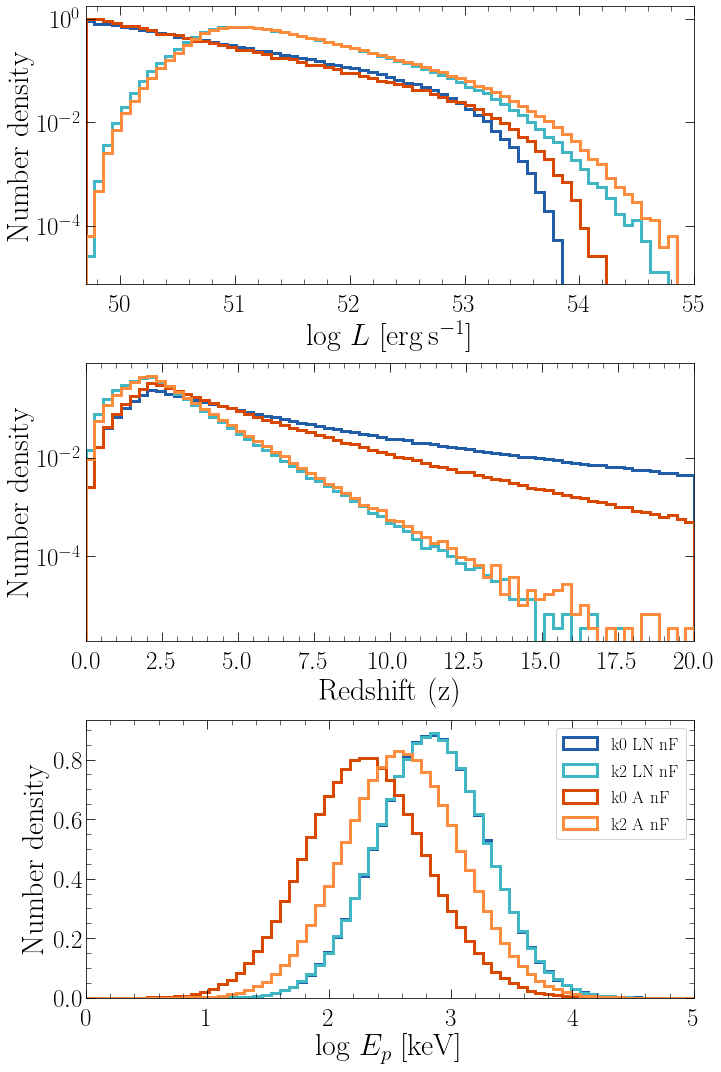

In [112]:
# Look at the distributions of L, z and Ep
fig, axes = plt.subplots(3, figsize=(10,15), tight_layout=True)
bins_z = np.linspace(0,20,70)
bins_L = np.linspace(49.7,55,70)
bins_Ep = np.linspace(0,5,70)
for i, mod in enumerate(model_names_ks):
    axes[0].hist(np.log10(dfs[mod].properties['L']), density=True, color=colors[i], bins=bins_L,
                 label=mod.replace('_',' '), histtype='step', linewidth=3)
    axes[1].hist(dfs[mod].properties['z'], density=True, color=colors[i], bins=bins_z,
                 label=mod.replace('_',' '), histtype='step', linewidth=3)
    axes[2].hist(np.log10(dfs[mod].properties['Ep']), density=True, color=colors[i], bins=bins_Ep,
                 label=mod.replace('_',' '), histtype='step', linewidth=3)
axes[0].set_xlabel(r'log $L~[\rm erg\,s^{-1}]$')
axes[1].set_xlabel(r'Redshift (z)')
axes[2].set_xlabel(r'log $E_p~[\rm keV]$')
axes[0].set_ylabel(r'Number density')
axes[1].set_ylabel(r'Number density')
axes[2].set_ylabel(r'Number density')
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].set_xlim(49.7,55)
axes[1].set_xlim(0,20)
axes[2].set_xlim(0,5)
axes[2].legend()
plt.show()



In [6]:
# Save the best populations to avoid recalculating each time
# if not load_files:
for mod in model_names:
    dfs[mod].save_to(paths_to_dir['output'] + f'/population_{mod}.pkl', save_memory=False)

16:05:36.579 [INFO] Saved GRB population to /Users/palmerio/Science_projects/GRB_population_model/model_outputs_non-dockerized/best_populations/population_kF_LN_nSFR.pkl
16:05:37.056 [INFO] Saved GRB population to /Users/palmerio/Science_projects/GRB_population_model/model_outputs_non-dockerized/best_populations/population_k0_LN_nF.pkl
16:05:37.449 [INFO] Saved GRB population to /Users/palmerio/Science_projects/GRB_population_model/model_outputs_non-dockerized/best_populations/population_k05_LN_nF.pkl
16:05:37.740 [INFO] Saved GRB population to /Users/palmerio/Science_projects/GRB_population_model/model_outputs_non-dockerized/best_populations/population_k1_LN_nF.pkl
16:05:38.028 [INFO] Saved GRB population to /Users/palmerio/Science_projects/GRB_population_model/model_outputs_non-dockerized/best_populations/population_k2_LN_nF.pkl
16:05:38.318 [INFO] Saved GRB population to /Users/palmerio/Science_projects/GRB_population_model/model_outputs_non-dockerized/best_populations/population_kF

In [62]:
# Calculate the predicted rate for SVOM/ECLAIRs
# sky_corr = 1.83/ECLAIRs_prop['omega_ECLAIRs_tot']
frac_T_live_ECLAIRs = 0.53  #  T_live / T_mission
# Antier : 57+/- 8, 43+/-5 pour ECLAIRs
# bonus: 18% sursaut mou (+4+/-1, +10+/-1)

for mod in model_names:
#     print(f" {mod} ".center(45, '#'))
    results[mod] = {}
    results[mod]['nGRB0'] = dfs[mod].normalization['nGRB0']
    results[mod]['nGRB0_err'] = dfs[mod].normalization['nGRB0_err']
    results[mod]['T_sim'] = dfs[mod].normalization['T_sim']
    results[mod]['T_sim_err'] = dfs[mod].normalization['T_sim_err']
    results[mod]['R_intr'] = dfs[mod].normalization['R_intr']
    results[mod]['R_intr_err'] = dfs[mod].normalization['R_intr_err']
    results[mod]['ECLAIRs_cts_rate'] = np.sum(dfs[mod].properties['pdet_ECLAIRs_pht_cts'])* frac_T_live_ECLAIRs / dfs[mod].normalization['T_sim']
    results[mod]['ECLAIRs_flnc_rate'] = np.sum(dfs[mod].properties['pdet_ECLAIRs_pht_flnc'])* frac_T_live_ECLAIRs / dfs[mod].normalization['T_sim']
    results[mod]['ECLAIRs_tot_rate'] = np.sum(dfs[mod].properties['pdet_ECLAIRs_tot'])* frac_T_live_ECLAIRs / dfs[mod].normalization['T_sim']
#     print(45*'#')
    
df_res = pd.DataFrame(results)
df_res

kF_LN_nSFR      k0_LN_nF     k05_LN_nF      k1_LN_nF  \
nGRB0              9.607906e-10  1.017328e-09  1.175836e-09  1.348678e-09   
nGRB0_err          3.462308e-11  3.666046e-11  4.237249e-11  4.860101e-11   
T_sim              3.825975e+02  1.405937e+02  2.059517e+02  2.865246e+02   
T_sim_err          1.378730e+01  5.066440e+00  7.421682e+00  1.032521e+01   
R_intr             2.613713e+03  7.112694e+03  4.855508e+03  3.490102e+03   
R_intr_err         9.418785e+01  2.563133e+02  1.749733e+02  1.257694e+02   
ECLAIRs_cts_rate   1.875930e+01  1.881103e+01  1.887934e+01  1.891333e+01   
ECLAIRs_flnc_rate  2.570614e+01  2.632126e+01  2.637776e+01  2.593942e+01   
ECLAIRs_tot_rate   2.650880e+01  2.712548e+01  2.718556e+01  2.673616e+01   

                       k2_LN_nF     kF_A_nSFR       k0_A_nF      k05_A_nF  \
nGRB0              1.379717e-09  6.853827e-10  8.171212e-10  7.846406e-10   
nGRB0_err          4.971953e-11  2.469848e-11  2.944581e-11  2.827534e-11   
T_sim              4.659636e+02  5.363370e+02  1.309286e+02  1.929999e+02   
T_sim_err          1.679148e+01  1.932746e+01  4.718147e+00  6.954953e+00   
R_intr             2.146090e+03  1.864499e+03  7.637752e+03  5.181349e+03   
R_intr_err         7.733659e+01  6.718917e+01  2.752343e+02  1.867153e+02   
ECLAIRs_cts_rate   1.801567e+01  2.040700e+01  2.085540e+01  2.021706e+01   
ECLAIRs_flnc_rate  2.502686e+01  2.907004e+01  3.055812e+01  2.927885e+01   
ECLAIRs_tot_rate   2.582260e+01  3.003700e+01  3.155154e+01  3.021812e+01   

                        k1_A_nF       k2_A_nF  
nGRB0              7.221825e-10  8.753100e-10  
nGRB0_err          2.602459e-11  3.154270e-11  
T_sim              2.568347e+02  5.059192e+02  
T_sim_err          9.255303e+00  1.823132e+01  
R_intr             3.893555e+03  1.976600e+03  
R_intr_err         1.403083e+02  7.122884e+01  
ECLAIRs_cts_rate   2.144662e+01  2.047786e+01  
ECLAIRs_flnc_rate  3.154096e+01  2.916310e+01  
ECLAIRs_tot_rate   3.258669e+01  3.013243e+01

In [70]:
print("{:.3e}, {:.3e}".format(df_res.T['nGRB0'].min(),df_res.T['nGRB0'].max()))
df_res.T

6.136e-10, 1.454e-09


nGRB0     nGRB0_err       T_sim  T_sim_err       R_intr  \
kF_LN_nSFR  9.864749e-10  3.554864e-11  372.636036  13.428326  2683.583721   
k0_LN_nF    1.065677e-09  3.840278e-11  112.833333   4.066066  8862.629247   
k05_LN_nF   1.136480e-09  4.095423e-11  201.981982   7.278630  4950.936664   
k1_LN_nF    1.285226e-09  4.631444e-11  283.145045  10.203425  3531.758784   
k2_LN_nF    1.453741e-09  5.238706e-11  474.809009  17.110235  2106.109996   
kF_A_nSFR   6.869336e-10  2.475436e-11  535.126126  19.283824  1868.718329   
k0_A_nF     8.302064e-10  2.991735e-11  131.149550   4.726110  7624.883223   
k05_A_nF    6.900519e-10  2.486674e-11  153.003604   5.513643  6535.793775   
k05_A_nF_2  8.075551e-10  2.910108e-11  210.272072   7.577372  4755.743310   
k1_A_nF     6.135684e-10  2.211057e-11  261.000901   9.405438  3831.404400   
k1_A_nF_2   7.355930e-10  2.650786e-11  217.704505   7.845207  4593.382219   
k2_A_nF     8.543919e-10  3.078890e-11  508.929730  18.339810  1964.907809   

            R_intr_err  ECLAIRs_cts_rate  ECLAIRs_flnc_rate  ECLAIRs_tot_rate  
kF_LN_nSFR   96.705720         18.183259          25.137820         25.929533  
k0_LN_nF    319.374027         18.268646          25.960207         26.750051  
k05_LN_nF   178.412132         18.650939          26.230209         27.026727  
k1_LN_nF    127.270587         18.749202          25.800777         26.611816  
k2_LN_nF     75.895856         18.024958          24.993791         25.777491  
kF_A_nSFR    67.341201         20.118209          28.835408         29.795273  
k0_A_nF     274.770567         20.508874          29.913970         30.891738  
k05_A_nF    235.524100         24.076884          36.617018         37.883024  
k05_A_nF_2  171.378137         18.506572          26.369003         27.221131  
k1_A_nF     138.068627         21.591960          31.729025         32.788122  
k1_A_nF_2   165.527287         25.221436          38.436010         39.769353  
k2_A_nF      70.807489         20.117366          28.755647         29.710989

17:54:33.586 [DEBUG] Input configuration:
Nb_GRBs: 1e5
constraints:
- Stern
- EpGBM
- eBAT6
output_dir: debugger
samples:
- Stern
- EpGBM
- eBAT6
- Swift
- ECLAIRs
- SHOALS
- GBM_sample
- BATSE_5B_sample

17:54:33.590 [DEBUG] Input parameters:
Cvar_distribution:
    correl_slope: -0.413
    mu: 0.04
    sigma: 0.22
luminosity_function:
    k_evol: 1.0
    logLbreak: 52.56
    logLmax: 53.0
    logLmin: 49.6989700043
    model: ES
    slope: 1.41
peak_energy_distribution:
    Ep0: 690
    alpha_amati: 0.3
    model: LN
    sigmaEp: 0.45
redshift_distribution:
    a: 0.94
    b: -0.52
    model: BExp
    zeta: null
    zm: 2.18
    zmax: 20
spectral_shape:
    alpha: 0.6
    beta: 2.5
    model: GBM_Band
t90obs_distribution:
    mu: 1.45
    sigma: 0.47

17:54:33.593 [DEBUG] Read cosmology from directory /Users/palmerio/Science_projects/GRB_population_model/data/cosmology: [0.3, 0.7, 0.7]
17:54:33.594 [INFO] Including samples: ['Stern']
17:54:33.595 [DEBUG] Including samples:
Stern:
    

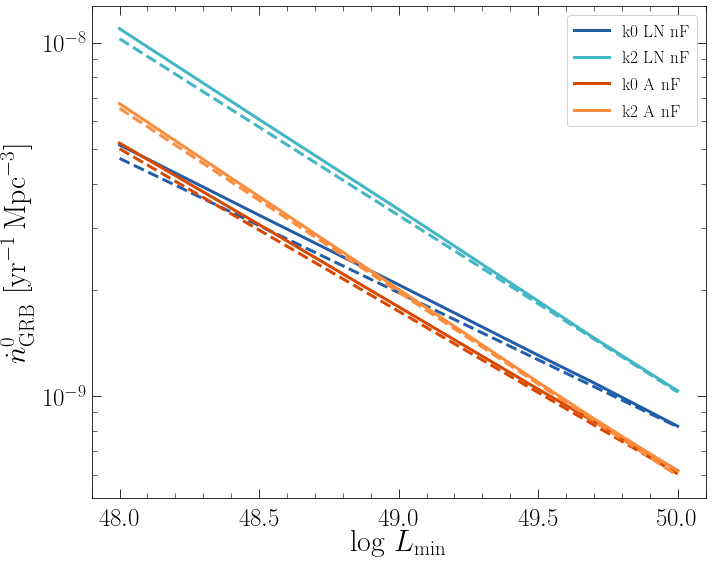

In [35]:
# look at nGRB0 vs Lmin

# nGRB0/nGRB0_ref = (Lmin/Lmin_ref)**(1-p)
def nGRB0_analytical(logLmin, slope, logLmin_ref=49.7, nGRB0_ref=1e-9):
    nGRB0 = nGRB0_ref * 10.**((logLmin-logLmin_ref)*(1.-slope))
    return nGRB0

nGRB0_analytical(49.7, 1.5, nGRB0_ref=3)

logLmin_s = np.asarray([48, 48.5, 49, 49.5, 49.6989700043, 50])
nGRB0_s = np.zeros((len(model_names_ks),logLmin_s.shape[0]))
config, params, instruments, samples, obs_constraints = io.read_init_files(paths_to_files)
cosmo = init_cosmology(paths_to_dir['cosmo'])
config['samples'] = ['Stern']
config['constraints'] = ['Stern']

incl_samples, incl_instruments, incl_constraints = io.create_config(config,
                                                                     samples,
                                                                     instruments,
                                                                     obs_constraints)
fig, ax = plt.subplots(figsize=(10,8))
logLmin_arr = np.linspace(48, 50, 51)
nGRB0_refs = np.asarray([1.066e-09, 1.454e-09, 8.302e-10, 8.544e-10])
for i,mod in enumerate(model_names_ks):
    print(f" {mod} ".center(45, '#'))
    with open(paths_to_files['param'].parent / f'parameters_{mod}.yml', 'r') as f:
            parameters[mod] = yaml.safe_load(f)
    for j,logLmin in enumerate(logLmin_s):
        parameters[mod]['luminosity_function']['logLmin'] = logLmin
        gp = GRBPopulation(Nb_GRBs=int(1e6))
        gp.draw_GRB_properties_for_MCMC(cosmo=cosmo, params=parameters[mod], instruments=incl_instruments)
        gp.create_mock_constraints(constraints=incl_constraints)
        gp.normalize_to_Stern()
        nGRB0_s[i,j] = gp.normalization['nGRB0']
    
    ax.plot(logLmin_s, nGRB0_s[i], label=mod.replace('_',' '), color=colors[i])
    nGRB0_an = nGRB0_analytical(logLmin_arr,
                                slope=gp.parameters['luminosity_function']['slope'],
                                logLmin_ref=49.6989700043,
                                nGRB0_ref=nGRB0_refs[i])
    ax.plot(logLmin_arr, nGRB0_an, color=colors[i], ls='--')

ax.legend()
ax.set_xlabel(r'log $L_{\rm min}$')
ax.set_ylabel(r'$\dot{n}_{\rm GRB}^0~[\rm yr^{-1}\,Mpc^{-3}]$')
ax.set_yscale('log')
fig.savefig('/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/nGRB0_vs_Lmin.pdf', bbox_inches='tight')
plt.show()

10:45:07.489 [INFO] In compute_CDF_bounds_by_MC: initializing...
10:45:07.493 [INFO] In compute_CDF_bounds_by_MC: starting Monte Carlo drawings...
10:45:07.519 [INFO] In compute_CDF_bounds_by_MC: starting bootstraps...
10:45:07.546 [INFO] In compute_CDF_bounds_by_MC: computing CDF...
10:45:08.925 [INFO] In compute_CDF_bounds_by_MC: plotting...
################# k0_LN_nF #####################


KeyError: 'pdet_SHOALS'

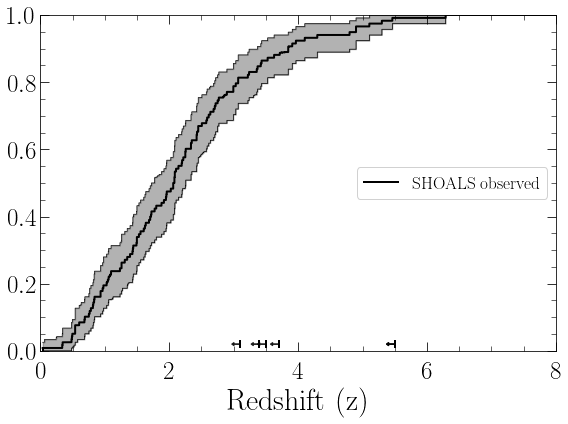

In [64]:
# Plot the redshift distribution expected for SHOALS in the case of k=0 and k=2 for LogNormal and Amati models
# Also compute the KS tests between these redshift distributions and the observed SHOALS redshift distribution
fig, ax = plt.subplots(figsize=(8,6))
df_obs = io.read_SHOALS_file()
pf.plot_SHOALS_z_distr_with_bounds(ax=ax)
for i,mod in enumerate(model_names_ks):
    print(f"################# {mod} #####################")
    cond = dfs[mod].properties['erg_flnc_BAT']>=1e-6
    pf.plot_SHOALS_distr(dfs[mod],
                          key='z',
                          plot_obs=False,
                          cumul=True,
                          ax=ax,
                          mod_color=colors[i],
                          mod_label=mod.replace('_',' '))
    D_stat, p_value = ks_2samp(dfs[mod].properties[cond]['z'], df_obs['z'])
    print("D-stat = {:.3f}  p_value = {:.3f}".format(D_stat, p_value))
ax.set_xlabel('Redshift (z)')
ax.set_xlim(0,8)
# plt.savefig('/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/SHOALS_z_distr.pdf')
plt.show()

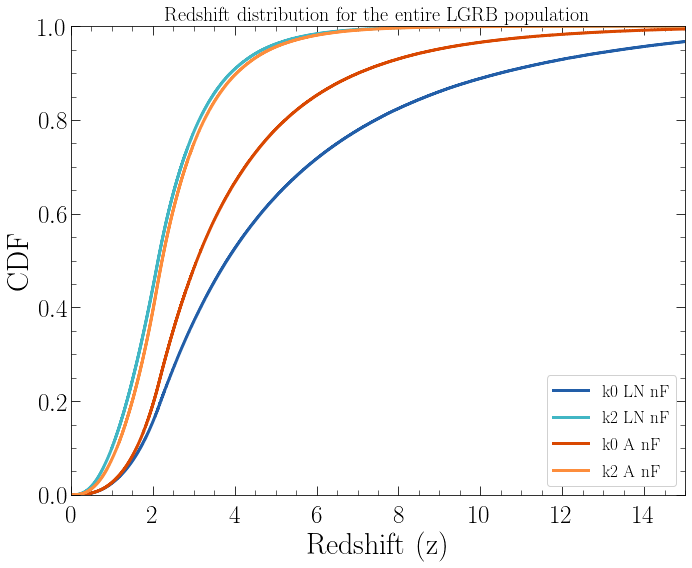

In [18]:
# Since all the redshift distribution of SHOALS look the same, I looked at the redshift distribution
# of the whole LGRB population, which is plotted below
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title('Redshift distribution for the entire LGRB population', **{'size':20})
# colors = ['#225ea8', '#41b6c4', '#ae017e', '#f768a1']
for i,mod in enumerate(model_names_ks):
    x_mod, cdf_mod = st.unbinned_empirical_cdf(dfs[mod].properties['z'])
    ax.plot(x_mod, cdf_mod, color=colors[i], drawstyle='steps-post', label=mod.replace('_',' '))

ax.legend(loc='lower right')
ax.set_ylabel('CDF')
ax.set_ylim(0,1)
ax.set_xlim(0,15)
ax.set_xlabel('Redshift (z)')
plt.show()

21:18:05.082 [INFO] Subsampling done in 1.127 s
21:18:23.711 [INFO] KS calculations done in 18.628 s
21:18:35.080 [INFO] CDF calculation done in 11.369 s


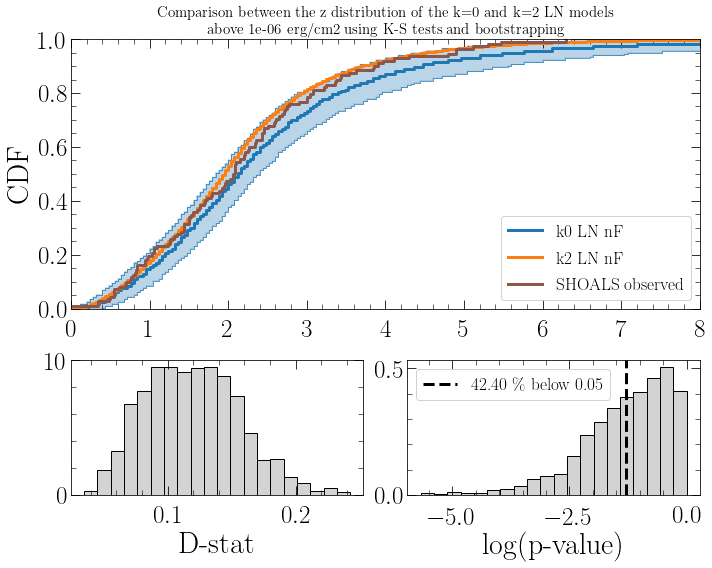

In [19]:
# Clearly the sample size and fluence cut of SHOALS don't allow us to discriminate between k=0 and k=2 models
# What fluence cut and sample size is needed to discriminate between k=0 and k=2 models?
# To answer this we create subsamples of size N_SHOALS=117 from the k=0 redshift distribution and compute
# the K-S test between these subsamples and the entire k=2 sample.
# This is repeated N_bs times (bs stands for bootstrap) to get an idea of how robust the results are.
# For each subsample we compute the K-S test and obtain the D-statistic and the p-value for that realization.
# The resulting distributions of D-statistics and p-values and shown in the bottom panels of the figure
# The top panel shows the CDF and the confidence bounds around it are calculated from the bootstrapping as well.
# The fraction of bootstrap samples that have p-value below 0.05 is shown in the legend of the bottom right panel
N_bs = 1000
N_sub = 117
thrsh = 1e-6
precision=500
st.subsample_and_KS(dfs['k0_LN_nF'].properties[(dfs['k0_LN_nF'].properties['erg_flnc_BAT']>=thrsh)],
                 dfs['k2_LN_nF'].properties[(dfs['k2_LN_nF'].properties['erg_flnc_BAT']>=thrsh)],
                 key='z',
                 precision=precision,
                 bins=np.linspace(0,20,precision+1),
                 N_sub=N_sub,
                 N_bs=N_bs,
                 label1='k0 LN nF',
                 label2='k2 LN nF',
                 show_plot=True, subsample2=False)
fig = plt.gcf()
axes = fig.axes
axes[0].set_xlim(0,8)
df_SHOALS = io.read_SHOALS_file()
z_SHOALS = df_SHOALS['z'].to_numpy()
x_obs, cdf_obs = st.unbinned_empirical_cdf(z_SHOALS)
axes[0].plot(x_obs, cdf_obs, color='C5', drawstyle='steps-post', label='SHOALS observed', lw=3)

axes[0].legend()
axes[0].set_title('Comparison between the z distribution of the k=0 and k=2 LN models\n above\
                  {:.0e} erg/cm2 using K-S tests and bootstrapping'.format(thrsh), **{'size':15})
plt.show()

17:28:04.264 [INFO] Subsampling done in 2.672 s
17:28:07.480 [INFO] KS calculations done in 3.215 s
17:28:09.534 [INFO] CDF calculation done in 2.054 s


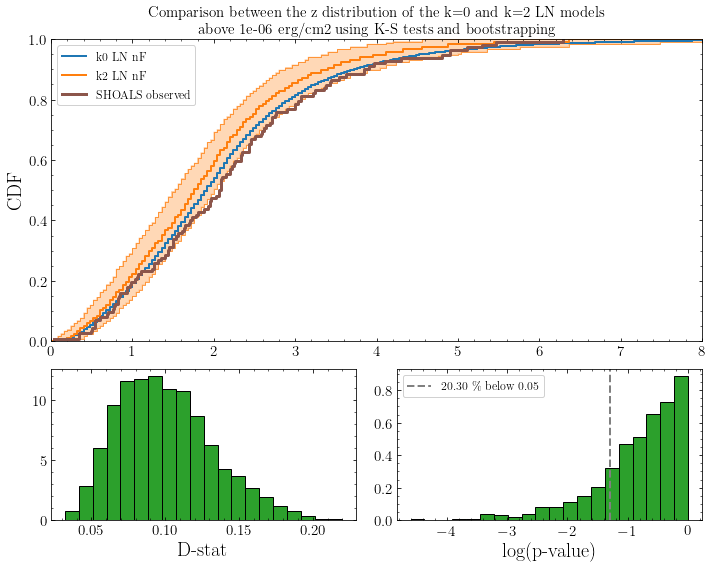

In [12]:
# The following is to show that the results don't change if we subsample from the k=2 scenario instead
# and compare with the entire k=0 redshift distribution.
st.subsample_and_KS(dfs['k0_LN_nF'].properties[(dfs['k0_LN_nF'].properties['erg_flnc_BAT']>=thrsh)],
                 dfs['k2_LN_nF'].properties[(dfs['k2_LN_nF'].properties['erg_flnc_BAT']>=thrsh)],
                 key='z',
                 precision=precision,
                 bins=np.linspace(0,20,precision+1),
                 N_sub=N_sub,
                 N_bs=N_bs,
                 label1='k0 LN nF',
                 label2='k2 LN nF',
                 show_plot=True, subsample1=False)
fig = plt.gcf()
axes = fig.axes
axes[0].set_xlim(0,8)
obs.plot_observed_SHOALS_z_distr(axes[0], color='C5', lw=3, label='SHOALS observed')
axes[0].legend()
axes[0].set_title('Comparison between the z distribution of the k=0 and k=2 LN models\n above\
              {:.0e} erg/cm2 using K-S tests and bootstrapping'.format(thrsh), **{'size':15})
plt.show()

17:29:23.104 [INFO] Subsampling done in 14.481 s
17:29:45.986 [INFO] KS calculations done in 22.882 s
17:29:59.928 [INFO] CDF calculation done in 13.941 s


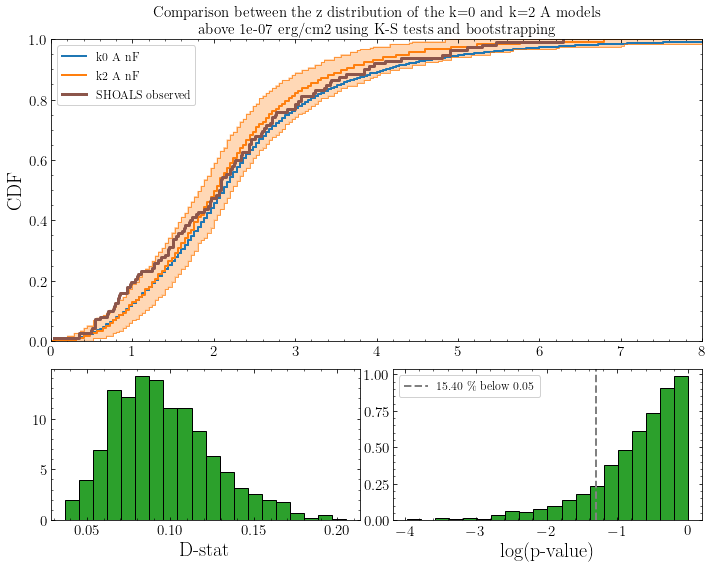

In [14]:
# Here we do the same thing but with the Amati-like scenarios
N_bs = 1000
N_sub = 117
thrsh = 1e-7
precision=500
st.subsample_and_KS(dfs['k0_A_nF'].properties[(dfs['k0_A_nF'].properties['erg_flnc_BAT']>=thrsh)],
                 dfs['k2_A_nF'].properties[(dfs['k2_A_nF'].properties['erg_flnc_BAT']>=thrsh)],
                 key='z',
                 precision=precision,
                 bins=np.linspace(0,20,precision+1),
                 N_sub=N_sub,
                 N_bs=N_bs,
                 label1='k0 A nF',
                 label2='k2 A nF',
                 show_plot=True, subsample1=False)
fig = plt.gcf()
axes = fig.axes
axes[0].set_xlim(0,8)
obs.plot_observed_SHOALS_z_distr(axes[0], color='C5', lw=3, label='SHOALS observed')
axes[0].legend()
axes[0].set_title('Comparison between the z distribution of the k=0 and k=2 A models\n above\
              {:.0e} erg/cm2 using K-S tests and bootstrapping'.format(thrsh), **{'size':15})
plt.show()

17:31:14.635 [INFO] Subsampling done in 30.914 s
17:32:16.941 [INFO] KS calculations done in 62.305 s
17:33:00.156 [INFO] CDF calculation done in 43.215 s


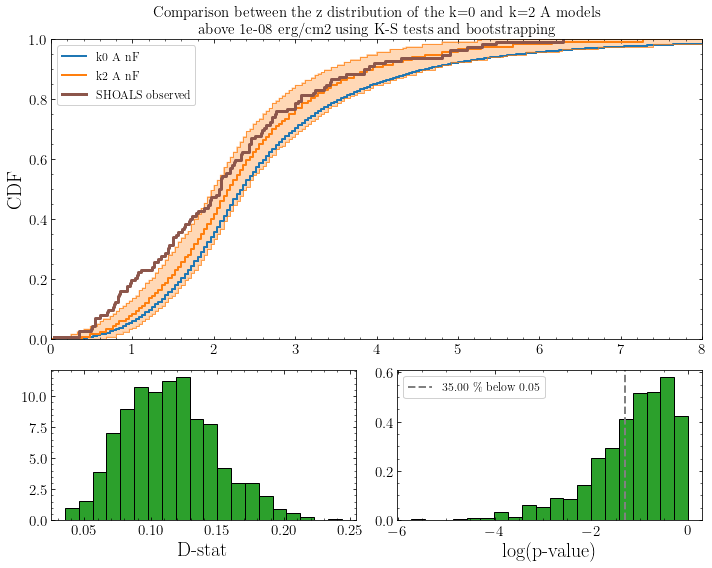

In [16]:
# It seems it is much harder to discriminate between the k=0 and k=2 models, even at deep fluence cuts for the
# Amati-like scenarios
thrsh = 1e-8
st.subsample_and_KS(dfs['k0_A_nF'].properties[(dfs['k0_A_nF'].properties['erg_flnc_BAT']>=thrsh)],
                 dfs['k2_A_nF'].properties[(dfs['k2_A_nF'].properties['erg_flnc_BAT']>=thrsh)],
                 key='z',
                 precision=precision,
                 bins=np.linspace(0,20,precision+1),
                 N_sub=N_sub,
                 N_bs=N_bs,
                 label1='k0 A nF',
                 label2='k2 A nF',
                 show_plot=True, subsample1=False)
fig = plt.gcf()
axes = fig.axes
axes[0].set_xlim(0,8)
obs.plot_observed_SHOALS_z_distr(axes[0], color='C5', lw=3, label='SHOALS observed')
axes[0].legend()
axes[0].set_title('Comparison between the z distribution of the k=0 and k=2 A models\n above\
              {:.0e} erg/cm2 using K-S tests and bootstrapping'.format(thrsh), **{'size':15})
plt.show()

In [37]:
# Now we want to explore the fluence cut vs sample size plane and see what is required to discriminate
# between k=0 and k=2. We create two arrays for the fluence cuts and the sample size we reasonably expect
# can be obtained and compute the fraction of bootstrap samples that have a p-value below 0.05
# We associate this fraction with the probability of discriminating between the k=0 and k=2 scenarios at the
# 95% confidence level.
flnc_cuts = np.array([1.8e-6, 1e-6, 5.6e-7, 3.2e-7, 1.8e-7, 1e-7, 5.7e-8])
size = np.array([56, 100, 178, 316, 562, 1000, 1780])
p_discr_z = {}
p_discr_L = {}
if load_files:
    for mod in ['LN','LN2','A','A2']:
        try:
            p_discr_z[mod] = pd.read_parquet(paths_to_dir['output']+ f'/p_discr_z_{mod}').to_numpy()
            p_discr_L[mod] = pd.read_parquet(paths_to_dir['output']+ f'/p_discr_L_{mod}').to_numpy()
        except Exception:
            pass

In [38]:
# WARNING: long computing time (at least 10 min)
# This is for the LogNormal models
precision=500
if not load_files:
    frac = np.zeros((len(size), len(flnc_cuts)))
    k=0
    for i, j in product(range(len(size)), range(len(flnc_cuts))):
        log.info("{:.1f}% Size, fluence cut = {} {}".format(100*k/(len(size)*len(flnc_cuts)), size[i], flnc_cuts[j]))
        frac[i,j]= st.subsample_and_KS(dfs['k0_LN_nF'].properties[(dfs['k0_LN_nF'].properties['erg_flnc_BAT']>=flnc_cuts[j])],
                         dfs['k2_LN_nF'].properties[(dfs['k2_LN_nF'].properties['erg_flnc_BAT']>=flnc_cuts[j])],
                         key='z',
                         precision=precision,
                         bins=np.linspace(0,20,precision+1),
                         N_sub=size[i],
                         N_bs=1000,
                         subsample1=False)
        log.info("Fraction of samples different at the 95% confidence level : {}".format(frac[i,j]))
        k+=1
    p_discr_z['LN'] = frac

12:21:44.208 [INFO] 0.0% Size, fluence cut = 56 1.8e-06
12:21:45.943 [INFO] Subsampling done in 1.684 s
12:21:48.151 [INFO] KS calculations done in 2.207 s
12:21:49.523 [INFO] CDF calculation done in 1.372 s
12:21:49.533 [INFO] Fraction of samples different at the 95% confidence level : 0.07
12:21:49.533 [INFO] 2.0408163265306123% Size, fluence cut = 56 1e-06
12:21:51.678 [INFO] Subsampling done in 2.081 s
12:21:55.101 [INFO] KS calculations done in 3.423 s
12:21:57.380 [INFO] CDF calculation done in 2.278 s
12:21:57.400 [INFO] Fraction of samples different at the 95% confidence level : 0.194
12:21:57.400 [INFO] 4.081632653061225% Size, fluence cut = 56 5.6e-07
12:22:01.151 [INFO] Subsampling done in 3.679 s
12:22:07.109 [INFO] KS calculations done in 5.958 s
12:22:10.625 [INFO] CDF calculation done in 3.515 s
12:22:10.655 [INFO] Fraction of samples different at the 95% confidence level : 0.391
12:22:10.655 [INFO] 6.122448979591836% Size, fluence cut = 56 3.2e-07
12:22:16.580 [INFO] Su

12:33:25.075 [INFO] CDF calculation done in 12.291 s
12:33:25.152 [INFO] Fraction of samples different at the 95% confidence level : 1.0
12:33:25.153 [INFO] 55.10204081632653% Size, fluence cut = 316 5.7e-08
12:33:36.628 [INFO] Subsampling done in 11.390 s
12:34:04.791 [INFO] KS calculations done in 28.162 s
12:34:21.593 [INFO] CDF calculation done in 16.802 s
12:34:21.691 [INFO] Fraction of samples different at the 95% confidence level : 1.0
12:34:21.692 [INFO] 57.142857142857146% Size, fluence cut = 562 1.8e-06
12:34:23.057 [INFO] Subsampling done in 1.334 s
12:34:25.271 [INFO] KS calculations done in 2.213 s
12:34:26.585 [INFO] CDF calculation done in 1.314 s
12:34:26.594 [INFO] Fraction of samples different at the 95% confidence level : 0.427
12:34:26.595 [INFO] 59.183673469387756% Size, fluence cut = 562 1e-06
12:34:28.685 [INFO] Subsampling done in 2.052 s
12:34:32.330 [INFO] KS calculations done in 3.645 s
12:34:34.397 [INFO] CDF calculation done in 2.066 s
12:34:34.416 [INFO] F

In [39]:
# WARNING: long computing time (at least 10 min)
# This is to check that results don't depend on whether we're subsampling from k=0 or k=2
if not load_files:
    frac = np.zeros((len(size), len(flnc_cuts)))
    k=0
    for i, j in product(range(len(size)), range(len(flnc_cuts))):
        log.info("{:.1f} %. Size, fluence cut = {} {}".format(100*k/(len(size)*len(flnc_cuts)), size[i], flnc_cuts[j]))
        frac[i,j]= st.subsample_and_KS(dfs['k0_LN_nF'].properties[(dfs['k0_LN_nF'].properties['erg_flnc_BAT']>=flnc_cuts[j])],
                         dfs['k2_LN_nF'].properties[(dfs['k2_LN_nF'].properties['erg_flnc_BAT']>=flnc_cuts[j])],
                         key='z',
                         precision=precision,
                         bins=np.linspace(0,20,precision+1),
                         N_sub=size[i],
                         N_bs=1000,
                         subsample2=False)
        log.info("Fraction of samples different at the 95% confidence level : {}".format(frac[i,j]))
        k+=1
    p_discr_z['LN2'] = frac

12:44:03.825 [INFO] 0.0 %. Size, fluence cut = 56 1.8e-06
12:44:04.613 [INFO] Subsampling done in 0.748 s
12:44:15.968 [INFO] KS calculations done in 11.355 s
12:44:23.100 [INFO] CDF calculation done in 7.131 s
12:44:23.136 [INFO] Fraction of samples different at the 95% confidence level : 0.086
12:44:23.137 [INFO] 2.0 %. Size, fluence cut = 56 1e-06
12:44:24.341 [INFO] Subsampling done in 1.143 s
12:44:43.717 [INFO] KS calculations done in 19.376 s
12:44:55.229 [INFO] CDF calculation done in 11.511 s
12:44:55.286 [INFO] Fraction of samples different at the 95% confidence level : 0.206
12:44:55.286 [INFO] 4.1 %. Size, fluence cut = 56 5.6e-07
12:44:56.867 [INFO] Subsampling done in 1.518 s
12:45:26.001 [INFO] KS calculations done in 29.133 s
12:45:42.652 [INFO] CDF calculation done in 16.651 s
12:45:42.724 [INFO] Fraction of samples different at the 95% confidence level : 0.403
12:45:42.725 [INFO] 6.1 %. Size, fluence cut = 56 3.2e-07
12:45:44.906 [INFO] Subsampling done in 2.120 s
12:

13:20:24.535 [INFO] CDF calculation done in 54.922 s
13:20:24.812 [INFO] Fraction of samples different at the 95% confidence level : 1.0
13:20:24.813 [INFO] 57.1 %. Size, fluence cut = 562 1.8e-06
13:20:25.495 [INFO] Subsampling done in 0.650 s
13:20:36.764 [INFO] KS calculations done in 11.268 s
13:20:43.152 [INFO] CDF calculation done in 6.388 s
13:20:43.178 [INFO] Fraction of samples different at the 95% confidence level : 0.456
13:20:43.179 [INFO] 59.2 %. Size, fluence cut = 562 1e-06
13:20:44.181 [INFO] Subsampling done in 0.963 s
13:21:02.501 [INFO] KS calculations done in 18.320 s
13:21:13.458 [INFO] CDF calculation done in 10.956 s
13:21:13.502 [INFO] Fraction of samples different at the 95% confidence level : 0.986
13:21:13.503 [INFO] 61.2 %. Size, fluence cut = 562 5.6e-07
13:21:15.058 [INFO] Subsampling done in 1.508 s
13:21:43.397 [INFO] KS calculations done in 28.338 s
13:21:59.995 [INFO] CDF calculation done in 16.598 s
13:22:00.061 [INFO] Fraction of samples different at

In [40]:
# WARNING: long computing time (at least 10 min)
# Same thing with Amati-like scenarios
if not load_files:
    frac = np.zeros((len(size), len(flnc_cuts)))
    k=0
    for i, j in product(range(len(size)), range(len(flnc_cuts))):
        log.info("{:.1f} %. Size, fluence cut = {} {}".format(100*k/(len(size)*len(flnc_cuts)), size[i], flnc_cuts[j]))
        frac[i,j]= st.subsample_and_KS(dfs['k0_A_nF'].properties[(dfs['k0_A_nF'].properties['erg_flnc_BAT']>=flnc_cuts[j])],
                                     dfs['k2_A_nF'].properties[(dfs['k2_A_nF'].properties['erg_flnc_BAT']>=flnc_cuts[j])],
                                     key='z',
                                     precision=precision,
                                     bins=np.linspace(0,20,precision+1),
                                     N_sub=size[i],
                                     N_bs=1000,
                                     subsample1=False)
        log.info("Fraction of samples different at the 95% confidence level : {}".format(frac[i,j]))
        k+=1
    p_discr_z['A2'] = frac

13:47:57.569 [INFO] 0.0 %. Size, fluence cut = 56 1.8e-06
13:47:59.111 [INFO] Subsampling done in 1.454 s
13:48:01.553 [INFO] KS calculations done in 2.441 s
13:48:03.115 [INFO] CDF calculation done in 1.561 s
13:48:03.128 [INFO] Fraction of samples different at the 95% confidence level : 0.049
13:48:03.129 [INFO] 2.0 %. Size, fluence cut = 56 1e-06
13:48:05.335 [INFO] Subsampling done in 2.165 s
13:48:09.219 [INFO] KS calculations done in 3.884 s
13:48:11.610 [INFO] CDF calculation done in 2.390 s
13:48:11.629 [INFO] Fraction of samples different at the 95% confidence level : 0.066
13:48:11.630 [INFO] 4.1 %. Size, fluence cut = 56 5.6e-07
13:48:15.322 [INFO] Subsampling done in 3.640 s
13:48:23.113 [INFO] KS calculations done in 7.790 s
13:48:27.729 [INFO] CDF calculation done in 4.615 s
13:48:27.757 [INFO] Fraction of samples different at the 95% confidence level : 0.086
13:48:27.758 [INFO] 6.1 %. Size, fluence cut = 56 3.2e-07
13:48:32.983 [INFO] Subsampling done in 5.164 s
13:48:44

14:02:17.289 [INFO] CDF calculation done in 20.187 s
14:02:17.388 [INFO] Fraction of samples different at the 95% confidence level : 0.734
14:02:17.389 [INFO] 57.1 %. Size, fluence cut = 562 1.8e-06
14:02:18.840 [INFO] Subsampling done in 1.417 s
14:02:21.419 [INFO] KS calculations done in 2.578 s
14:02:22.954 [INFO] CDF calculation done in 1.534 s
14:02:22.971 [INFO] Fraction of samples different at the 95% confidence level : 0.07
14:02:22.972 [INFO] 59.2 %. Size, fluence cut = 562 1e-06
14:02:25.153 [INFO] Subsampling done in 2.140 s
14:02:29.414 [INFO] KS calculations done in 4.260 s
14:02:31.923 [INFO] CDF calculation done in 2.509 s
14:02:31.942 [INFO] Fraction of samples different at the 95% confidence level : 0.316
14:02:31.943 [INFO] 61.2 %. Size, fluence cut = 562 5.6e-07
14:02:35.395 [INFO] Subsampling done in 3.403 s
14:02:42.536 [INFO] KS calculations done in 7.141 s
14:02:47.878 [INFO] CDF calculation done in 5.341 s
14:02:47.911 [INFO] Fraction of samples different at the

In [41]:
# WARNING: long computing time (at least 10 min)
# Same thing with Amati-like scenarios subsampling from k=0 instead of k=2
if not load_files:
    frac = np.zeros((len(size), len(flnc_cuts)))
    k=0
    for i, j in product(range(len(size)), range(len(flnc_cuts))):
        log.info("{:.1f} %. Size, fluence cut = {} {}".format(100*k/(len(size)*len(flnc_cuts)), size[i], flnc_cuts[j]))
        frac[i,j]= st.subsample_and_KS(dfs['k0_A_nF'].properties[(dfs['k0_A_nF'].properties['erg_flnc_BAT']>=flnc_cuts[j])],
                                     dfs['k2_A_nF'].properties[(dfs['k2_A_nF'].properties['erg_flnc_BAT']>=flnc_cuts[j])],
                                     key='z',
                                     precision=precision,
                                     bins=np.linspace(0,20,precision+1),
                                     N_sub=size[i],
                                     N_bs=1000,
                                     subsample2=False)
        log.info("Fraction of samples different at the 95% confidence level : {}".format(frac[i,j]))
        k+=1
    p_discr_z['A'] = frac

14:13:25.265 [INFO] 0.0 %. Size, fluence cut = 56 1.8e-06
14:13:26.051 [INFO] Subsampling done in 0.753 s
14:13:37.392 [INFO] KS calculations done in 11.340 s
14:13:44.358 [INFO] CDF calculation done in 6.965 s
14:13:44.386 [INFO] Fraction of samples different at the 95% confidence level : 0.048
14:13:44.387 [INFO] 2.0 %. Size, fluence cut = 56 1e-06
14:13:45.543 [INFO] Subsampling done in 1.115 s
14:14:05.660 [INFO] KS calculations done in 20.116 s
14:14:17.924 [INFO] CDF calculation done in 12.264 s
14:14:17.979 [INFO] Fraction of samples different at the 95% confidence level : 0.058
14:14:17.980 [INFO] 4.1 %. Size, fluence cut = 56 5.6e-07
14:14:19.757 [INFO] Subsampling done in 1.725 s
14:14:51.103 [INFO] KS calculations done in 31.346 s
14:15:09.855 [INFO] CDF calculation done in 18.751 s
14:15:09.977 [INFO] Fraction of samples different at the 95% confidence level : 0.108
14:15:09.978 [INFO] 6.1 %. Size, fluence cut = 56 3.2e-07
14:15:13.111 [INFO] Subsampling done in 3.036 s
14:

14:54:10.879 [INFO] CDF calculation done in 63.015 s
14:54:11.195 [INFO] Fraction of samples different at the 95% confidence level : 0.713
14:54:11.196 [INFO] 57.1 %. Size, fluence cut = 562 1.8e-06
14:54:11.975 [INFO] Subsampling done in 0.747 s
14:54:24.311 [INFO] KS calculations done in 12.336 s
14:54:31.511 [INFO] CDF calculation done in 7.199 s
14:54:31.543 [INFO] Fraction of samples different at the 95% confidence level : 0.064
14:54:31.544 [INFO] 59.2 %. Size, fluence cut = 562 1e-06
14:54:32.714 [INFO] Subsampling done in 1.128 s
14:54:54.971 [INFO] KS calculations done in 22.256 s
14:55:07.716 [INFO] CDF calculation done in 12.744 s
14:55:07.767 [INFO] Fraction of samples different at the 95% confidence level : 0.292
14:55:07.768 [INFO] 61.2 %. Size, fluence cut = 562 5.6e-07
14:55:09.763 [INFO] Subsampling done in 1.943 s
14:55:43.057 [INFO] KS calculations done in 33.294 s
14:56:02.078 [INFO] CDF calculation done in 19.021 s
14:56:02.162 [INFO] Fraction of samples different 

In [42]:
def plot_fluence_cut_vs_sample_size(size, flnc_cuts, frac, show_indiv_pts=False):
    fig, ax = plt.subplots(figsize=(10,8))
    log_size_2D, log_flnc_cuts_2D = np.meshgrid(np.log10(size), np.log10(flnc_cuts))
    N_colors = 10
    # WARNGING : must use the transpose of frac here because of the way contourf expects the input
    art = ax.contourf(log_size_2D, log_flnc_cuts_2D, frac.T, levels=9)
    cb = fig.colorbar(art)
    if show_indiv_pts:
        for i, j in product(range(len(size)), range(len(flnc_cuts))):
            ax.scatter(np.log10(size[i]), np.log10(flnc_cuts[j]), s=10, marker='.', color='k')
            ax.text(np.log10(size[i]), np.log10(flnc_cuts[j]), "{:.2f}".format(frac[i,j]))
    cb.set_label(r"$p^{2\sigma}_{\rm discr}$")
    ax.set_xlabel("log sample size")
    ax.set_ylabel("log Fluence cut [erg/cm$^2$]")
    return

LN


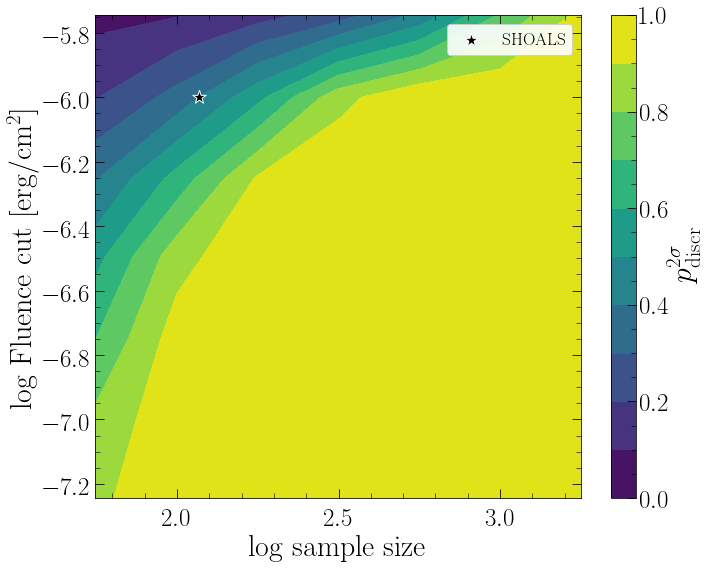

LN2


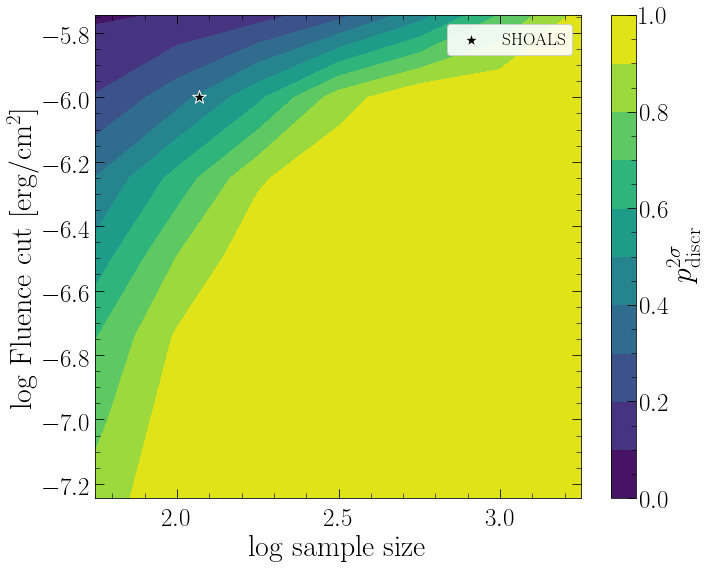

A2


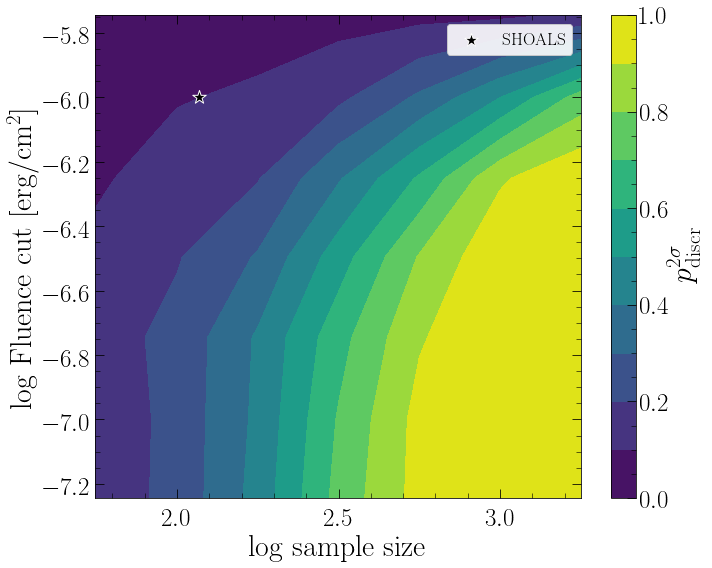

A


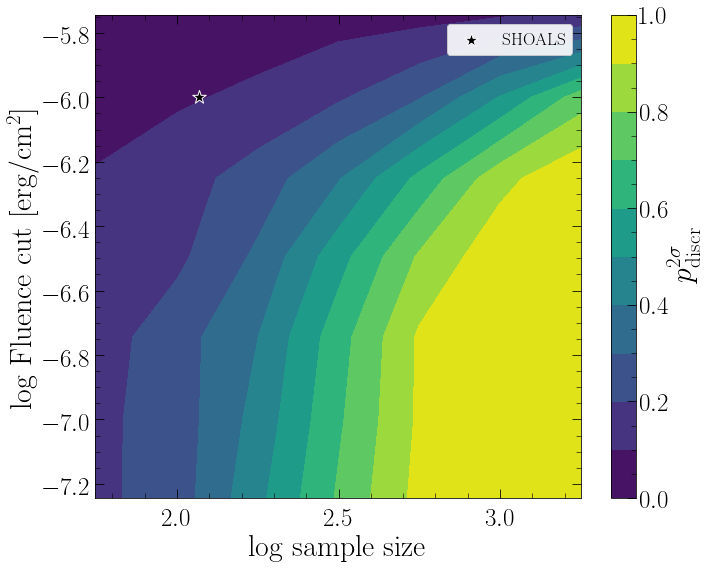

In [45]:
# Create the 2D plane 'fluence cut' vs 'sample size' and plot the probability of discriminating between
# k=0 and k=2 models at the 2 sigma confidence level for the LogNormal scenarios
for key, value in p_discr_z.items():
    print(key)
    plot_fluence_cut_vs_sample_size(size, flnc_cuts, value)
    ax = plt.gca()
    ax.scatter(np.log10(117), -6, s=200, marker='*', edgecolor='w', color='k', label='SHOALS')
    ax.legend(loc='best')
    plt.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/flnc_sampsize_{key}.pdf')
    plt.show()

In [44]:
# Turn the data into DataFrames and save them
if not load_files:
    for mod, frac in p_discr_z.items():
        df_temp = pd.DataFrame(data=frac, index=size.astype(str), columns=flnc_cuts.astype(str))
        df_temp.to_parquet(paths_to_dir['output']+ f'/p_discr_z_{mod}')


In [22]:
# Same thing but with the eBAT6 sample
pflx_cuts = np.logspace(np.log10(0.05), np.log10(3), 5)
size = np.array([56, 100, 178, 316, 562, 1000, 1780])
p_discr_z_BAT6 = {}
load_files=False
if load_files:
    for mod in ['LN','A']:
        try:
            p_discr_z_BAT6[mod] = pd.read_parquet(paths_to_dir['output']+ f'/p_discr_z_BAT6{mod}').to_numpy()
        except Exception:
            pass

10:55:40.210 [INFO] Subsampling done in 63.544 s
10:57:53.369 [INFO] KS calculations done in 133.159 s
10:59:10.945 [INFO] CDF calculation done in 77.575 s
10:59:10.994 [WARNING] No handles with labels found to put in legend.
10:59:11.001 [WARNING] No handles with labels found to put in legend.


(0, 10)

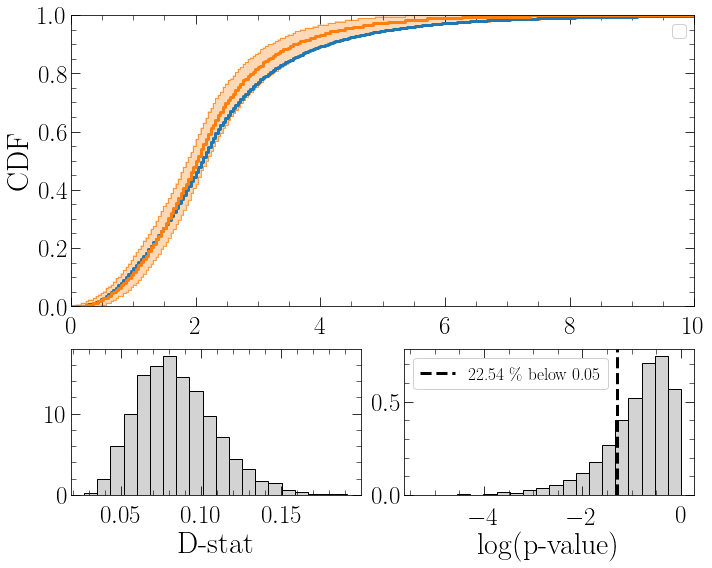

In [39]:
st.subsample_and_KS(dfs['k0_A_nF'].properties[(dfs['k0_A_nF'].properties['pht_pflx_BAT']>=0.14)],
                             dfs['k2_A_nF'].properties[(dfs['k2_A_nF'].properties['pht_pflx_BAT']>=0.14)],
                             key='z', create_CDF=True, show_plot=True,
                             precision=precision,
                             bins=np.linspace(0,20,precision+1),
                             N_sub=178,
                             N_bs=5000,
                             subsample1=False)
plt.gcf().axes[0].set_xlim(0,10)

10:50:28.651 [INFO] Subsampling done in 29.729 s
10:51:34.859 [INFO] KS calculations done in 66.207 s
10:52:14.465 [INFO] CDF calculation done in 39.605 s
10:52:14.512 [WARNING] No handles with labels found to put in legend.
10:52:14.630 [WARNING] No handles with labels found to put in legend.


(0, 10)

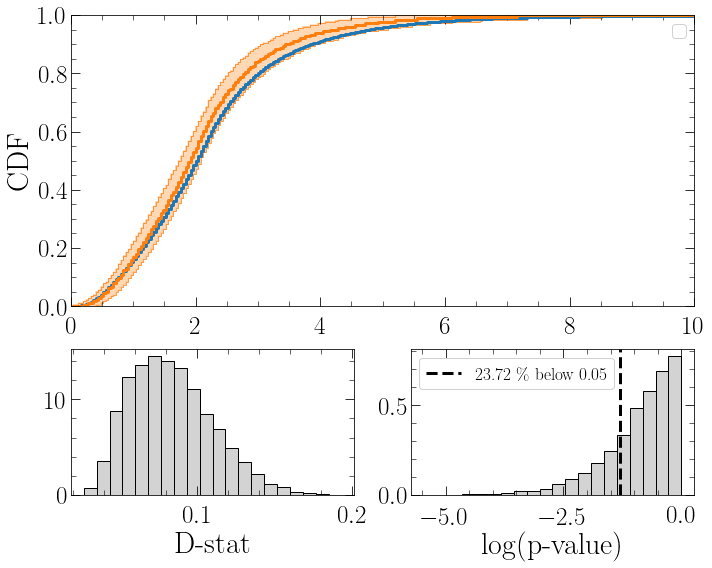

In [37]:
st.subsample_and_KS(dfs['k0_A_nF'].properties[(dfs['k0_A_nF'].properties['pht_pflx_BAT']>=0.387)],
                             dfs['k2_A_nF'].properties[(dfs['k2_A_nF'].properties['pht_pflx_BAT']>=0.387)],
                             key='z', create_CDF=True, show_plot=True,
                             precision=precision,
                             bins=np.linspace(0,20,precision+1),
                             N_sub=178,
                             N_bs=5000,
                             subsample1=False)
plt.gcf().axes[0].set_xlim(0,10)

In [23]:
precision=500
if not load_files:
    for mod in ['A']:
        frac = np.zeros((len(size), len(pflx_cuts)))
        k=0
        for i, j in product(range(len(size)), range(len(pflx_cuts))):
            log.info("{:.1f}% Size, pflx cut = {} {}".format(100*k/(len(size)*len(pflx_cuts)), size[i], pflx_cuts[j]))
            frac[i,j]= st.subsample_and_KS(dfs[f'k0_{mod}_nF'].properties[(dfs[f'k0_{mod}_nF'].properties['pht_pflx_BAT']>=pflx_cuts[j])],
                             dfs[f'k2_{mod}_nF'].properties[(dfs[f'k2_{mod}_nF'].properties['pht_pflx_BAT']>=pflx_cuts[j])],
                             key='z',
                             precision=precision,
                             bins=np.linspace(0,20,precision+1),
                             N_sub=size[i],
                             N_bs=1000,
                             subsample1=False)
            log.info("Fraction of samples different at the 95% confidence level : {}".format(frac[i,j]))
            k+=1
        p_discr_z_BAT6[mod] = frac


10:25:09.316 [INFO] 0.0% Size, pflx cut = 56 0.049999999999999996
10:25:31.125 [INFO] Subsampling done in 21.542 s
10:26:15.677 [INFO] KS calculations done in 44.551 s
10:26:42.290 [INFO] CDF calculation done in 26.612 s
10:26:42.443 [INFO] Fraction of samples different at the 95% confidence level : 0.047
10:26:42.444 [INFO] 2.9% Size, pflx cut = 56 0.13915788418568703
10:26:53.892 [INFO] Subsampling done in 11.343 s
10:27:18.511 [INFO] KS calculations done in 24.618 s
10:27:33.326 [INFO] CDF calculation done in 14.815 s
10:27:33.409 [INFO] Fraction of samples different at the 95% confidence level : 0.068
10:27:33.410 [INFO] 5.7% Size, pflx cut = 56 0.38729833462074165
10:27:40.002 [INFO] Subsampling done in 6.514 s
10:27:51.706 [INFO] KS calculations done in 11.704 s
10:27:58.941 [INFO] CDF calculation done in 7.234 s
10:27:58.982 [INFO] Fraction of samples different at the 95% confidence level : 0.11
10:27:58.983 [INFO] 8.6% Size, pflx cut = 56 1.0779123358892524
10:28:01.605 [INFO] 

KeyboardInterrupt: 

In [17]:
for mod, frac in p_discr_z_BAT6.items():
        df_temp = pd.DataFrame(data=frac, index=size.astype(str), columns=pflx_cuts.astype(str))
        df_temp.to_parquet(f'/Users/palmerio/Science_projects/GRB_population_model/model_outputs_non-dockerized/best_populations/p_discr_z_BAT6_{mod}')
        

LN


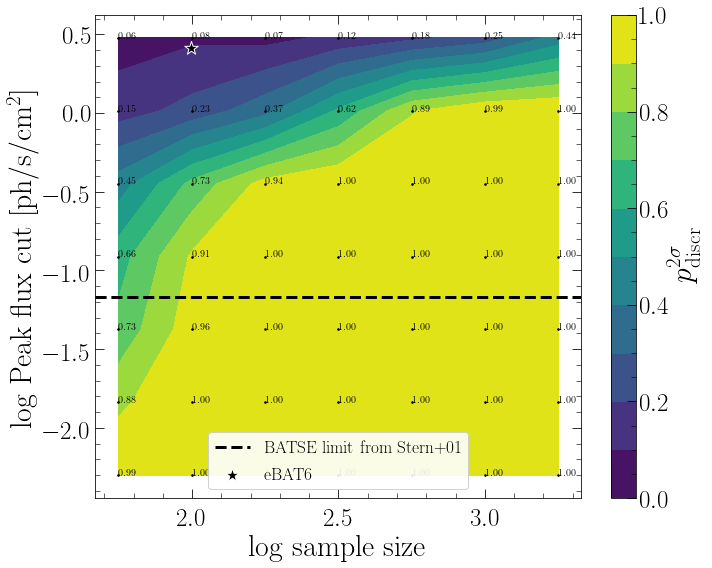

A


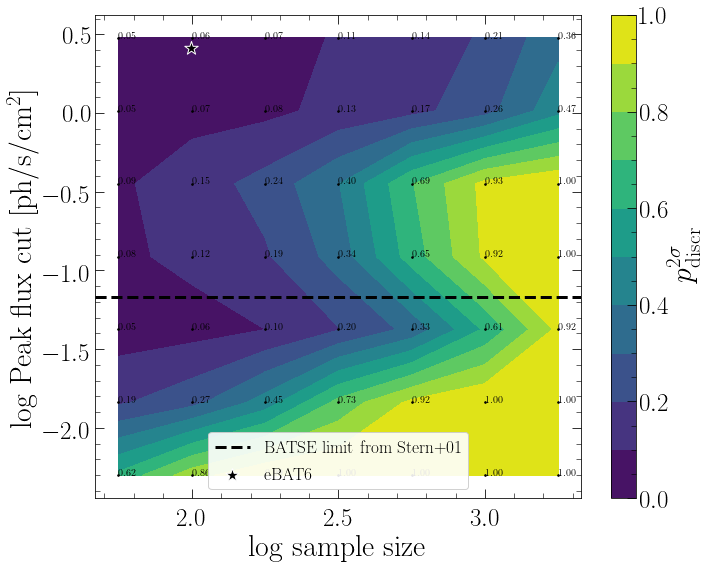

In [21]:
def plot_pflx_cut_vs_sample_size(size, pflx_cuts, frac, show_indiv_pts=False):
    fig, ax = plt.subplots(figsize=(10,8))
    log_size_2D, log_pflx_cuts_2D = np.meshgrid(np.log10(size), np.log10(pflx_cuts))
    N_colors = 10
    # WARNGING : must use the transpose of frac here because of the way contourf expects the input
    art = ax.contourf(log_size_2D, log_pflx_cuts_2D, frac.T, levels=9)
    cb = fig.colorbar(art)
    if show_indiv_pts:
        for i, j in product(range(len(size)), range(len(pflx_cuts))):
            ax.scatter(np.log10(size[i]), np.log10(pflx_cuts[j]), s=10, marker='.', color='k')
            ax.text(np.log10(size[i]), np.log10(pflx_cuts[j]), "{:.2f}".format(frac[i,j]))
    cb.set_label(r"$p^{2\sigma}_{\rm discr}$")
    ax.set_xlabel("log sample size")
    ax.set_ylabel("log Peak flux cut [ph/s/cm$^2$]")
    return

# Create the 2D plane 'pflx cut' vs 'sample size' and plot the probability of discriminating between
# k=0 and k=2 models at the 2 sigma confidence level for the LogNormal scenarios
for key, value in p_discr_z_BAT6.items():
    print(key)
    plot_pflx_cut_vs_sample_size(size, pflx_cuts, value, show_indiv_pts=True)
    ax = plt.gca()
    ax.scatter(np.log10(99), np.log10(2.6), s=200, marker='*', edgecolor='w', color='k', label='eBAT6')
    ax.axhline(np.log10(0.068), ls='--', color='k', label='BATSE limit from Stern+01')
    ax.legend(loc='best')
    plt.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/pflx_sampsize_{key}.pdf')
    plt.show()

################## k0_LN_nF #################
0.0006691734115097826
################## k2_LN_nF #################
0.0015978891940610837
################## k0_A_nF ##################
0.0018439687142259788
################## k2_A_nF ##################
0.0029319756882980924


Text(0.5, 0, 'log $E_{\\rm iso}$ [erg]')

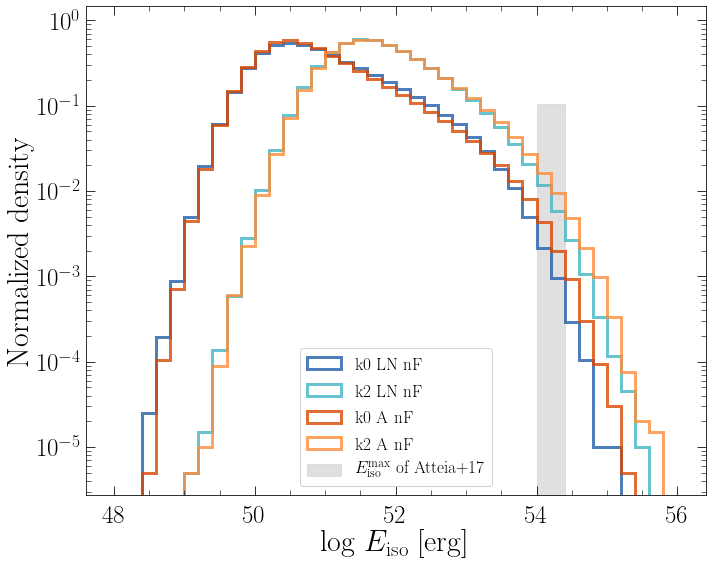

In [48]:
# Now we want to look at the Ep-Eiso plane and the Eiso distribution to compare with Atteia+17.
fig, ax = plt.subplots(figsize=(10,8))
from matplotlib.transforms import blended_transform_factory
tform = blended_transform_factory(ax.transData, ax.transAxes)
    
ax.fill_between([54,54.4], [0.8,0.8], transform=tform, color='lightgrey',
                alpha=0.7, label=r'$E^{\rm max}_{\rm iso}$ of Atteia+17')
for i, mod in enumerate(model_names_ks):
    print(f" {mod} ".center(45, '#'))
    ax.hist(np.log10(dfs[mod].properties['Eiso']), bins=np.linspace(48, 56, 41), histtype='step', linewidth=3,
            alpha=0.8, density=True, label=mod.replace('_',' '), color=colors[i])
    
    cond = (np.log10(dfs[mod].properties['Eiso']) > 54.4) & (dfs[mod].properties['pdet_Stern'] == 1)
    print(len(dfs[mod].properties[cond])/len(dfs[mod].properties[(dfs[mod].properties['pdet_Stern'] == 1)]))

ax.autoscale()
ax.legend(loc='lower center')
ax.set_yscale('log')
ax.set_ylabel(r'Normalized density')
ax.set_xlabel(r'log $E_{\rm iso}$ [erg]')
# fig.savefig('/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/Eiso_distr.pdf',
#             bbox_inches='tight')


/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


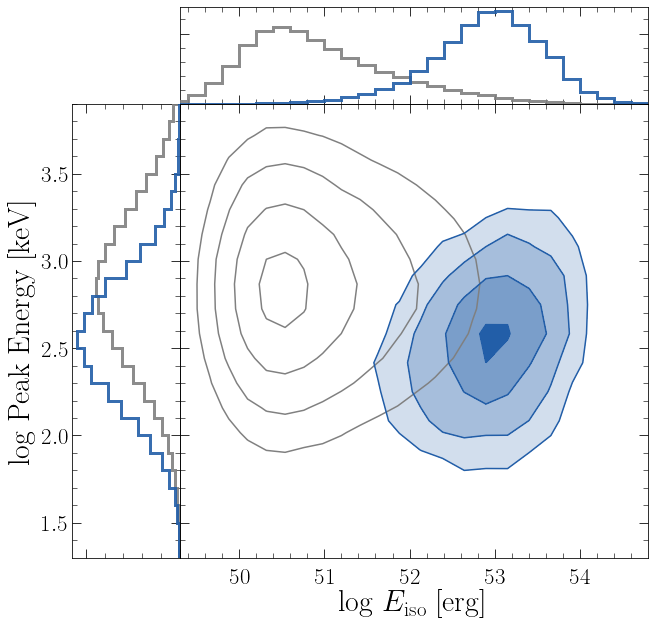

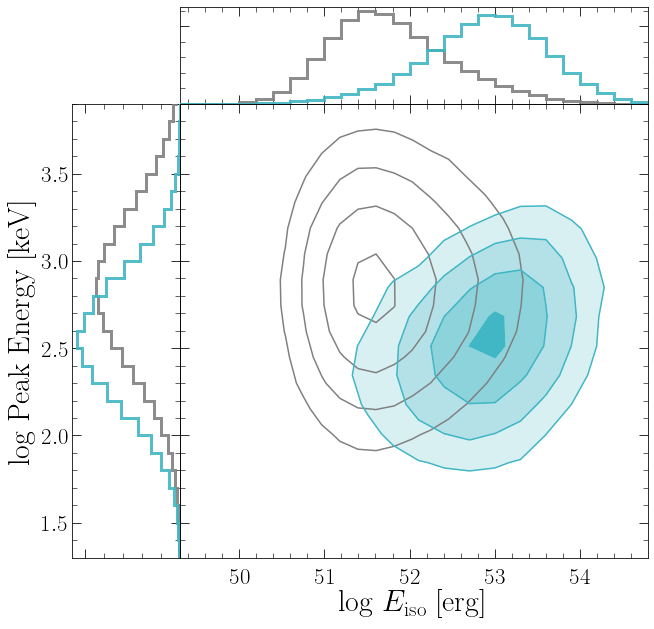

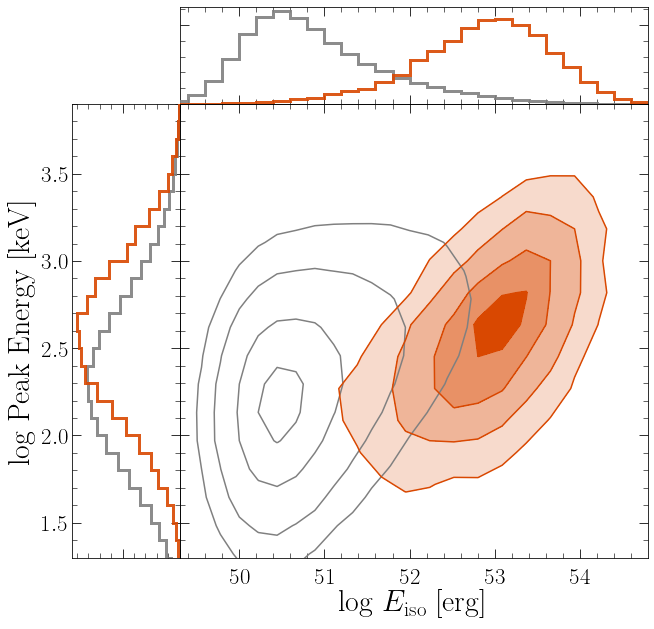

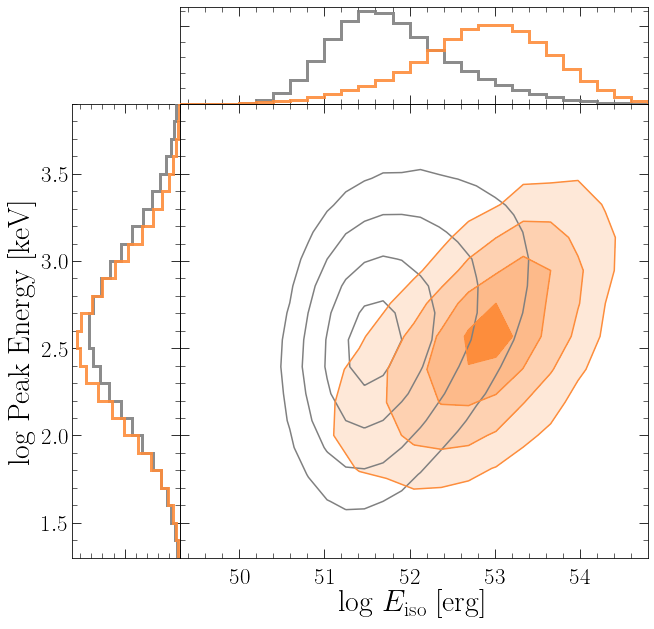

In [21]:
for i,mod in enumerate(model_names_ks):
    cond = dfs[mod].properties['pht_pflx_BAT'] >= 2.6
    fig, axes = pf.cool_hist2d(np.log10(dfs[mod].properties['Eiso'].to_numpy()), np.log10(dfs[mod].properties['Ep'].to_numpy()),
               mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False, cb=False,
               plot_left_hist=True, plot_top_hist=True,
               left_hist_kwargs={'label': None,
                                     'bins':np.linspace(1,4,31),
                                     'edgecolor':'gray',
                                     'linewidth':3,
                                     'zorder':5,
                                     'alpha':0.9,
                                     'histtype':'step'},
                top_hist_kwargs={'label': None,
                                    'bins': np.linspace(49,55,31),
                                    'edgecolor': 'gray',
                                    'linewidth':3,
                                    'zorder':5,
                                    'alpha':0.9,
                                    'histtype':'step'},
               hist2d_kwargs={'color':'gray', 'bins':30,
                              'contour_kwargs':{'linewidths':1.5, 'zorder':2},
                              'plot_datapoints':False, 
                              'plot_density':False, 
                              'plot_contours':True,
                              'fill_contours':False})
    pf.cool_hist2d(np.log10(dfs[mod].properties[cond]['Eiso'].to_numpy()), np.log10(dfs[mod].properties[cond]['Ep'].to_numpy()),
                   mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False, fig=fig, cb=False,
                   left_hist_kwargs={'label': None,
                                     'bins':np.linspace(1,4,31),
                                     'edgecolor':colors[i],
                                     'linewidth':3,
                                     'zorder':5,
                                     'alpha':0.9,
                                     'histtype':'step'},
                   top_hist_kwargs={'label': None,
                                    'bins': np.linspace(49,55,31),
                                    'edgecolor': colors[i],
                                    'linewidth':3,
                                    'zorder':5,
                                    'alpha':0.9,
                                    'histtype':'step'},
                   hist2d_kwargs={'color':colors[i], 
                                  'contour_kwargs':{'linewidths':1.5},
                                  'plot_datapoints':False, 
                                  'plot_density':False, 
                                  'plot_contours':True,
                                  'fill_contours':True})
    axes['left'].set_ylabel(r'log Peak Energy $\rm{[keV]}$')
    axes['center'].set_xlabel(r'log $E_{\rm iso}~\rm{[erg]}$')
    axes['center'].set_xlim(49.3,54.8)
    axes['center'].set_ylim(1.3, 3.9)
    axes['center'].tick_params(labelsize=23)
    axes['left'].tick_params(labelsize=23)

Sample size :1313
Sample size :78
Sample size :345


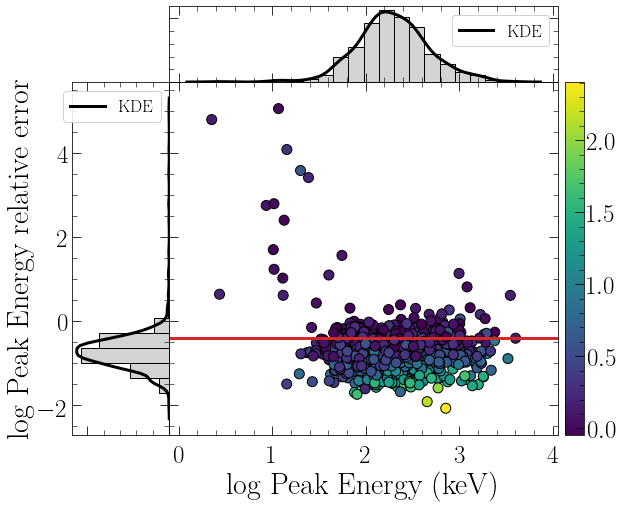

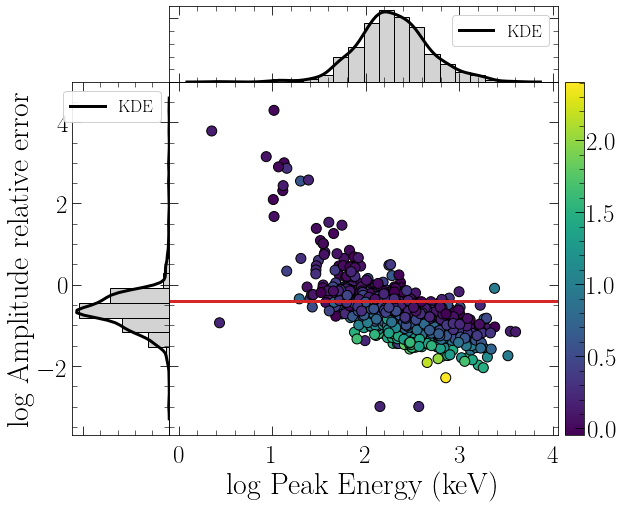

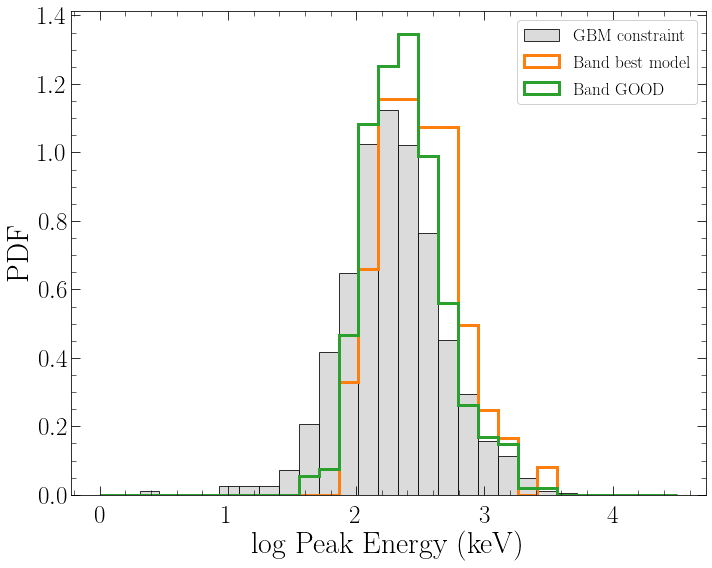

In [19]:
# This is to check if using the 'GOOD' criteria defined by Gruber+14 and Bhat+16 as low relative errors on Ep and on
# the amplitude of the Band spectrum fit introduces a bias against low or high Ep.
# Conclusion : YES the relative error on the amplitude is higher at low Ep than at high Ep

def calc_rel_errors_GBM_band(df_obs):
    # Calculate relative errors on Band parameters for later filtering
    keys =  ['pflx_band_epeak_pos_err','pflx_band_epeak', 'pflx_band_ampl_pos_err', 'pflx_band_ampl']
    for k in keys:
        df_obs[k] = pd.to_numeric(df_obs[k], errors='coerce')
    df_obs['pflx_band_epeak_rel_err'] = df_obs['pflx_band_epeak_pos_err']/df_obs['pflx_band_epeak']
    df_obs['pflx_band_ampl_rel_err'] = df_obs['pflx_band_ampl_pos_err']/df_obs['pflx_band_ampl']
    return df_obs

# Read the GBM data
df_obs = pd.read_csv('../catalogs/GBM_cat/fermi_GBM_cat_total.dat', sep='|', header=2, low_memory=False)
df_obs.rename(columns=lambda x:x.strip(), inplace=True)

# Filter out short and incomplete (low peak flux) GRBs
df_obs = msc.filter_df(df_obs, 't90', lim_min=2, errors='coerce')
df_obs = msc.filter_df(df_obs, 'pflx_band_phtfluxb', lim_min=0.9, errors='coerce')
# for i,col in enumerate(df_obs.columns):
#     print(i,col)
df_obs = calc_rel_errors_GBM_band(df_obs)
df_obs['pflx_band_ampl_rel_err'].replace(0,1e-3, inplace=True)

# Plot the Ep relative error vs Ep
fig, axes = pf.cool_hist2d(np.log10(df_obs['pflx_band_epeak']),
                           np.log10(df_obs['pflx_band_epeak_rel_err']),
                           c=np.log10(df_obs['pflx_band_phtfluxb']))
axes['center'].axhline(np.log10(0.4), color='C3')
axes['center'].set_xlabel('log Peak Energy (keV)')
axes['left'].set_ylabel('log Peak Energy relative error')

# Plot the Band amplitude relative error vs Ep
fig, axes = pf.cool_hist2d(np.log10(df_obs['pflx_band_epeak']),
                           np.log10(df_obs['pflx_band_ampl_rel_err']),
                           c=np.log10(df_obs['pflx_band_phtfluxb']))
axes['center'].axhline(np.log10(0.4), color='C3')
axes['center'].set_xlabel('log Peak Energy (keV)')
axes['left'].set_ylabel('log Amplitude relative error')



# Look at the GBM Ep distribution for different criteria :
# - all GRBs that are long and complete
# - when BAND is best fit model
# - all GRBs satisfying 'GOOD' criteria of Gruber+14 and Bhat+16 
# (i.e. with low errors on alpha and beta and low relative errors on Ep and the amplitude of the Band fit)
bins = np.linspace(0,4.5, 30)
fig, ax = plt.subplots(figsize=(10,8))
pf.plot_obs_property('../catalogs/GBM_cat/fermi_GBM_cat_total.dat',
                  key='pflx_band_epeak',
                  func=[msc.filter_df, msc.filter_df],
                  func_args=[{'filtering_key':'t90', 'lim_min':2, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_phtfluxb', 'lim_min':0.9, 'errors':'coerce'}],
                  log=True, verbose=True, kde=False,
                  bins=bins,
                  ax=ax, density=True, label='GBM constraint', alpha=0.8,
                  color='lightgray', errors='coerce')
pf.plot_obs_property('../catalogs/GBM_cat/fermi_GBM_cat_total.dat',
                  key='pflx_band_epeak',
                  func=[msc.filter_df for i in range(3)],
                  func_args=[{'filtering_key':'t90', 'lim_min':2, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_phtfluxb', 'lim_min':0.9, 'errors':'coerce'},
                             {'filtering_key':'pflx_best_fitting_model', 'equal':'pflx_band', 'string':True}],
                  log=True, verbose=True, kde=False,
                  bins=bins,
                  ax=ax, density=True, label='Band best model', linewidth=3, histtype='step',
                  color='C1', errors='coerce')
func_list = [calc_rel_errors_GBM_band]
func_list += [msc.filter_df for i in range(7)]
pf.plot_obs_property('../catalogs/GBM_cat/fermi_GBM_cat_total.dat',
                  key='pflx_band_epeak',
                  func=func_list,
                  func_args=[{},
                             {'filtering_key':'t90', 'lim_min':2, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_phtfluxb', 'lim_min':0.9, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_alpha_pos_err', 'lim_max':0.4, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_beta_pos_err', 'lim_max':1.0, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_beta_pos_err', 'lim_max':1.0, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_epeak_rel_err', 'lim_max':0.4, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_ampl_rel_err', 'lim_max':0.4, 'errors':'coerce'}],
                  log=True, verbose=True, kde=False,
                  bins=bins,
                  ax=ax, density=True, label='Band GOOD', linewidth=3, histtype='step',
                  color='C2', errors='coerce')
ax.legend()
ax.set_xlabel('log Peak Energy (keV)')
ax.set_ylabel('PDF')

plt.show()


Sample size :1313
Sample size :132


/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Sample size :124
Sample size :819


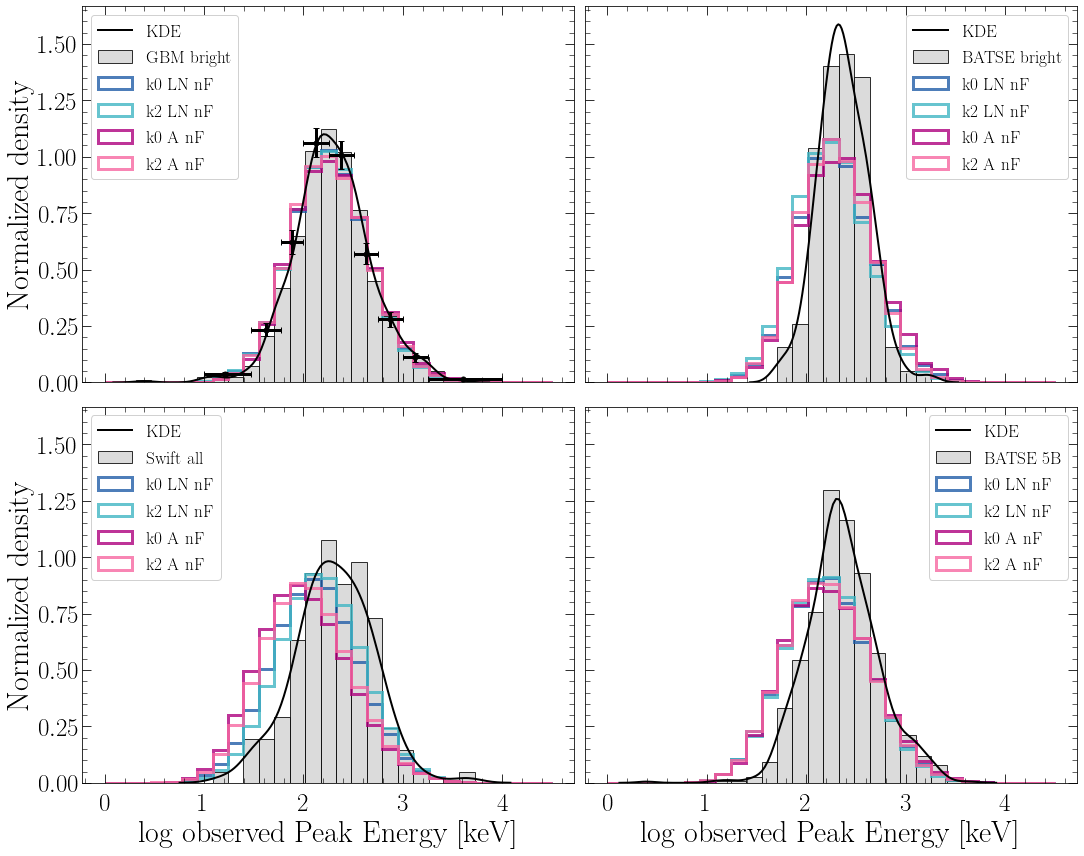

In [21]:
# Now look at Ep-L plane and Ep distributions of various observed samples to try to distinguish between
# Amati-like (intrinsic correlation) scenarios and LogNormal scenarios
bins = np.linspace(0,4.5, 30)
fig, axes = plt.subplots(2,2, figsize=(15,12), sharex='all', sharey='all')
ax = axes[0,0]
ax2 = axes[1,0]
ax3 = axes[0,1]
ax4 = axes[1,1]

# GBM bright
pf.plot_obs_property('../catalogs/GBM_cat/fermi_GBM_cat_total.dat',
                  key='pflx_band_epeak',
                  func=[msc.filter_df, msc.filter_df],
                  func_args=[{'filtering_key':'t90', 'lim_min':2, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_phtfluxb', 'lim_min':0.9, 'errors':'coerce'}],
                  log=True, verbose=True, kde=True,
                  bins=bins,
                  ax=ax, density=True, label='GBM bright', alpha=0.8,
                  color='lightgray', errors='coerce')
for i,mod in enumerate(model_names_ks):
    cond = dfs[mod]['pdet_EpGBM'] == 1
    ax.hist(np.log10(dfs[mod][cond]['Epobs']), alpha=0.8, density=True,
            bins=bins, color=colors[i], histtype='step', linewidth=3, label=mod.replace('_',' '))

ax.set_ylabel(r'Normalized density')
ax.legend(loc='upper left')


# Observational constraint
pf.plot_EpGBM(fname=paths_to_dir['root']/'observational_constraints/EpGBM_for_plotting.txt',
              ax=ax, density=True, log=True,
              linewidth=3, color='k', fmt='.', capsize=3)


# Swift
pf.plot_obs_property('../catalogs/Swift_cat/Swift_cat_complete.txt',
                  key='bat_epeak',
                  func=[msc.filter_df, msc.filter_df],
                  func_args=[{'filtering_key':'bat_t90', 'lim_min':2, 'errors':'coerce'},
                             {'filtering_key':'bat_peakfluxp', 'lim_min':0.2, 'errors':'coerce'}],
                  log=True, verbose=True, kde=True,
                  bins=bins,
                  ax=ax2, density=True, label='Swift all', alpha=0.8,
                  color='lightgray', errors='coerce')
for i,mod in enumerate(model_names_ks):
    cond = dfs[mod]['pht_pflx_BAT'] >= 0.2
    ax2.hist(np.log10(dfs[mod][cond]['Epobs']), alpha=0.8, density=True,
            bins=bins, color=colors[i], histtype='step', linewidth=3, label=mod.replace('_',' '))


ax2.set_xlabel(r'log observed Peak Energy $\rm{[keV]}$')
ax2.set_ylabel(r'Normalized density')
ax2.legend(loc='upper left')

# BATSE bright
pf.plot_obs_property('../catalogs/BATSE_cat/BATSE_bright_cat.txt',
                  key='peak_energy',
                  func=msc.filter_df,
                  func_args={'filtering_key':'spectral_model', 'equal':'BAND', 'string':True},
                  log=True, verbose=True, kde=True,
                  bins=np.linspace(0,4.5, 30),
                  ax=ax3, density=True, label='BATSE bright', alpha=0.8,
                  color='lightgray', errors='coerce')

for i,mod in enumerate(model_names_ks):
    cond = dfs[mod]['pht_pflx_BATSE'] >= 3.0
    ax3.hist(np.log10(dfs[mod][cond]['Epobs']), alpha=0.8, density=True,
            bins=bins, color=colors[i], histtype='step', linewidth=3, label=mod.replace('_',' '))


ax3.legend()

# BATSE 20 - 2000 keV
pf.plot_obs_property('../catalogs/BATSE_cat/BATSE_cat_complete_5B.txt',
                  key='pflx_band_epeak',
                  func=msc.filter_df,
                  func_args={'filtering_key':'pflx_band_phtflux', 'lim_min':2.},
                  log=True, verbose=True, kde=True,
                  bins=np.linspace(0,4.5, 30),
                  ax=ax4, density=True, label='BATSE 5B', alpha=0.8,
                  color='lightgray', errors='coerce')

for i,mod in enumerate(model_names_ks):
    cond = dfs[mod]['pht_pflx_BATSE_5B'] >= 2.0
    ax4.hist(np.log10(dfs[mod][cond]['Epobs']), alpha=0.8, density=True,
            bins=bins, color=colors[i], histtype='step', linewidth=3, label=mod.replace('_',' '))


ax4.set_xlabel(r'log observed Peak Energy $\rm{[keV]}$')
ax4.legend()

fig.subplots_adjust(hspace=0, wspace=0)
plt.show()



/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:51: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:52: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:53: RuntimeWarning: invalid value encountered in log10
  log_x[2] = log_x[0] - np.log10(x[0] - x[2])
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:51: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:52: Runti

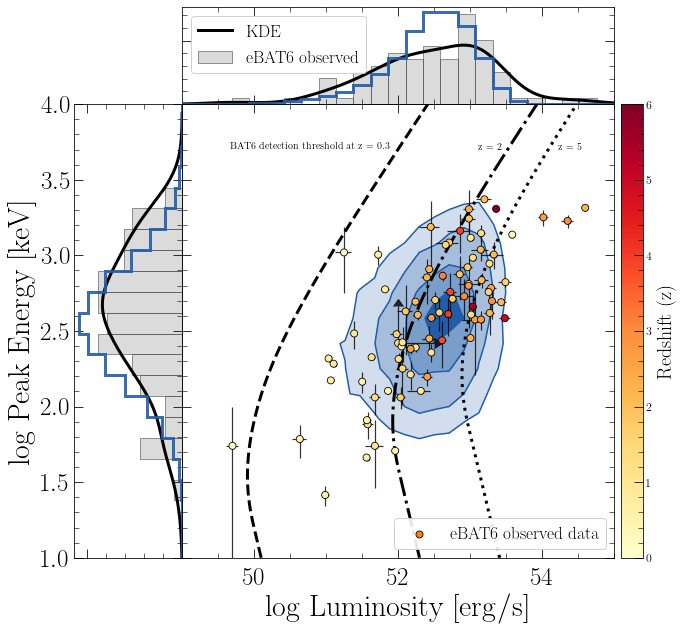

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


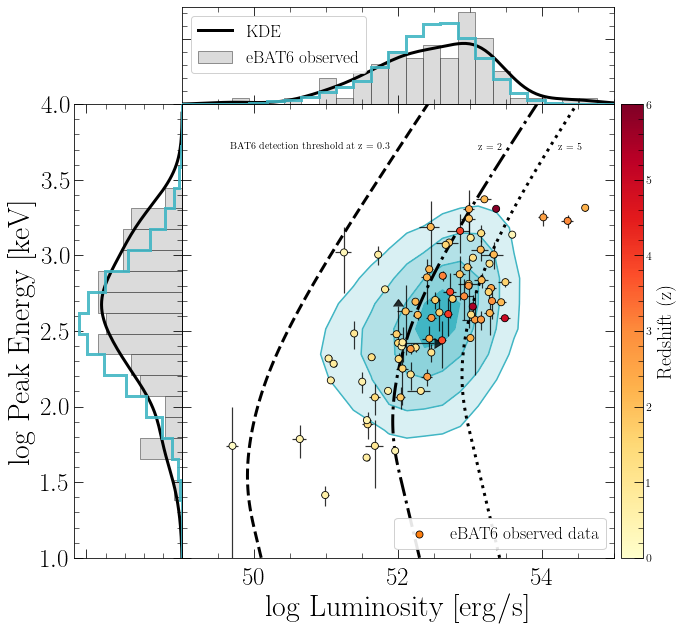

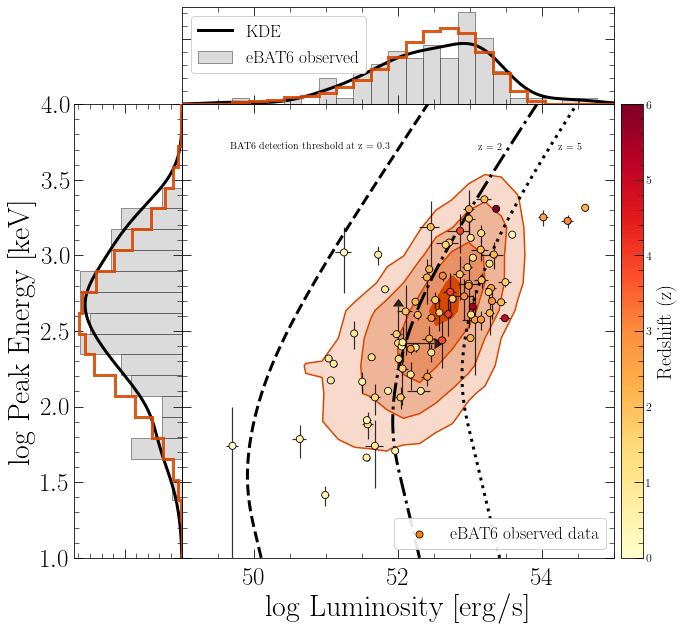

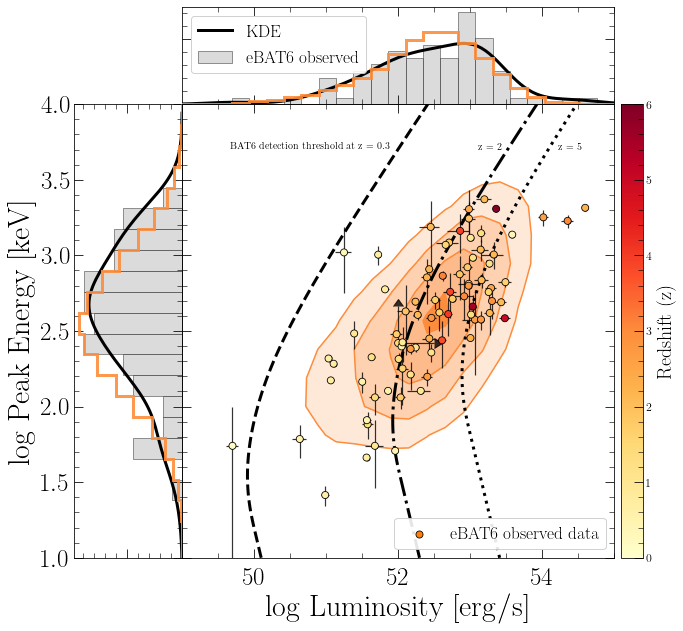

In [22]:
for i,mod in enumerate(model_names_ks):
    cond = dfs[mod].properties['pht_pflx_BAT'] >= 2.6
    fig, axes = pf.cool_hist2d(np.log10(dfs[mod].properties[cond]['L'].to_numpy()), np.log10(dfs[mod].properties[cond]['Ep'].to_numpy()),
                   mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False,
                   left_hist_kwargs={'label': None,
                                     'bins': np.linspace(0,4,30),
                                     'edgecolor':colors[i],
                                     'linewidth':3,
                                     'zorder':5,
                                     'alpha':0.9,
                                     'histtype':'step'},
                   top_hist_kwargs={'label': None,
                                    'bins': np.linspace(48,55,30),
                                    'edgecolor': colors[i],
                                    'linewidth':3,
                                    'zorder':5,
                                    'alpha':0.9,
                                    'histtype':'step'},
                   hist2d_kwargs={'color':colors[i], 
                                  'contour_kwargs':{'linewidths':1.5},
                                  'plot_datapoints':False, 
                                  'plot_density':False, 
                                  'plot_contours':True,
                                  'fill_contours':True})
    pf.plot_eBAT6_EpL(axes=axes, mini_cax=False)


/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


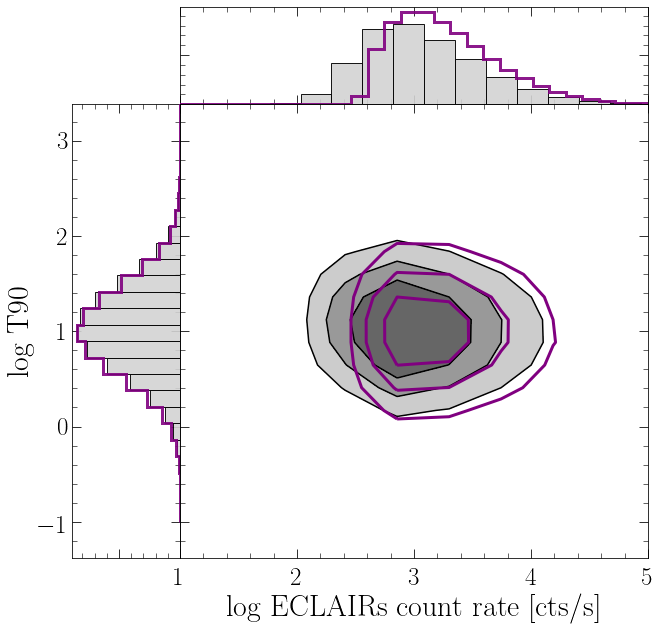

In [25]:
# Now lets look at the predictions for SVOM in more detail

# for mod in model_names_ks:
# fig, ax = plt.subplots(figsize=(10,9))
# bins_t90 = np.linspace(-1,4,30)
# ax.hist(np.log10(dfs[mod]['t90']), bins=bins_t90, weights=dfs[mod]['pdet_ECLAIRs_tot'],
#         color='lightgray', label='ECLAIRs population')
# ax.hist(np.log10(dfs[mod]['t90']), bins=bins_t90, weights=dfs[mod]['pdet_ECLAIRs_pht_flnc'],
#         color='darkorange', label='Fluence', alpha=0.5)
# ax.hist(np.log10(dfs[mod]['t90']), bins=bins_t90, weights=dfs[mod]['pdet_ECLAIRs_pht_cts'],
#         color='purple', label='Peak flux', alpha=0.5)
# ax.legend()
fig, axes = pf.cool_hist2d(np.log10(dfs[mod].properties['pht_cts_ECLAIRs'].to_numpy()),
                           np.log10(dfs[mod].properties['t90'].to_numpy()),
                   mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False, cb=False,
                   left_hist_kwargs={'label': None,'weights':dfs[mod].properties['pdet_ECLAIRs_tot'],
                                     'bins': np.linspace(-1,4,30),
                                     'color':'lightgray',
                                     'zorder':5,
                                     'alpha':0.9},
                   top_hist_kwargs={'label': None,'weights':dfs[mod].properties['pdet_ECLAIRs_tot'],
                                    'bins': np.linspace(-3,6,35),
                                    'color':'lightgray',
                                    'zorder':5,
                                    'alpha':0.9},
                   hist2d_kwargs={'color':'k',
                                  'weights':dfs[mod].properties['pdet_ECLAIRs_tot'],
                                  'contour_kwargs':{'linewidths':1.5},
                                  'plot_datapoints':False, 
                                  'plot_density':False, 
                                  'plot_contours':True,
                                  'fill_contours':True})

pf.cool_hist2d(np.log10(dfs[mod].properties['pht_cts_ECLAIRs'].to_numpy()),
                           np.log10(dfs[mod].properties['t90'].to_numpy()),
               fig=fig,
                   mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False, cb=False,
                   left_hist_kwargs={'label': None,
                                     'bins': np.linspace(-1,4,30),
                                     'edgecolor':'purple', 'linewidth':3,
                                     'weights':dfs[mod].properties['pdet_ECLAIRs_pht_cts'],
                                     'zorder':5,
                                     'alpha':0.9, 'histtype':'step'},
                   top_hist_kwargs={'label': None,
                                    'bins': np.linspace(-0.5,5,40),
                                    'edgecolor':'purple', 'linewidth':3,
                                    'weights':dfs[mod].properties['pdet_ECLAIRs_pht_cts'],
                                    'zorder':5,
                                    'alpha':0.9, 'histtype':'step'},
                   hist2d_kwargs={'color':'purple', 'alpha':0.3,
                                  'weights':dfs[mod].properties['pdet_ECLAIRs_pht_cts'],
                                  'contour_kwargs':{'linewidths':3},
                                  'plot_datapoints':False, 
                                  'plot_density':False, 
                                  'plot_contours':True,
                                  'fill_contours':False,'no_fill_contours':True})
axes['center'].set_xlim(1, 5)
axes['left'].set_ylabel('log T90')
axes['center'].set_xlabel('log ECLAIRs count rate [cts/s]')

plt.show()


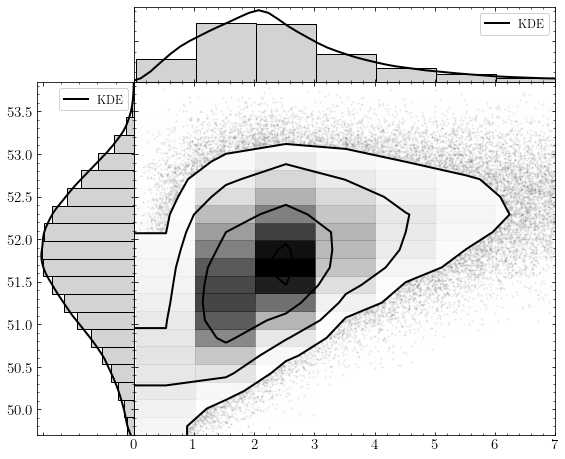

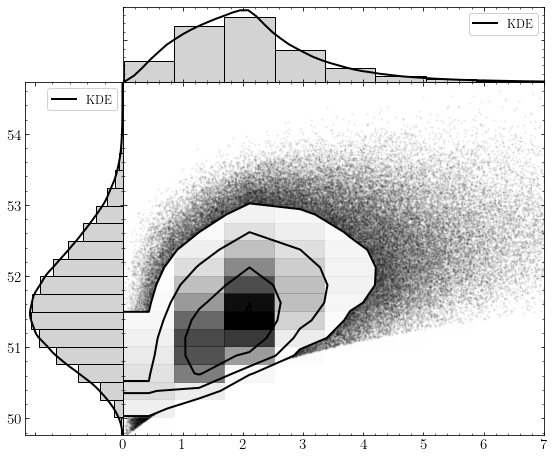

16:31:42.189 [INFO] 0.0 %. Size, fluence cut = 1000 1e-07
16:31:44.457 [INFO] Subsampling done in 0.678 s
16:31:52.942 [INFO] KS calculations done in 8.484 s
16:31:58.554 [INFO] CDF calculation done in 5.611 s
16:31:58.633 [WARNING] No handles with labels found to put in legend.
16:31:58.641 [WARNING] No handles with labels found to put in legend.
16:31:58.694 [INFO] Fraction of samples different at the 95% confidence level : 0.49
################# k0_LN_nF #####################
D-stat, p_value = 0.072, 0.610
################# k2_LN_nF #####################
D-stat, p_value = 0.076, 0.541
################# k0_A_nF #####################
D-stat, p_value = 0.066, 0.708
################# k2_A_nF #####################
D-stat, p_value = 0.073, 0.581
################# k0_LN_nF #####################
D-stat, p_value = 0.072, 0.610
################# k2_LN_nF #####################
D-stat, p_value = 0.076, 0.541
################# k0_A_nF #####################
D-stat, p_value = 0.066, 0.708
########

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


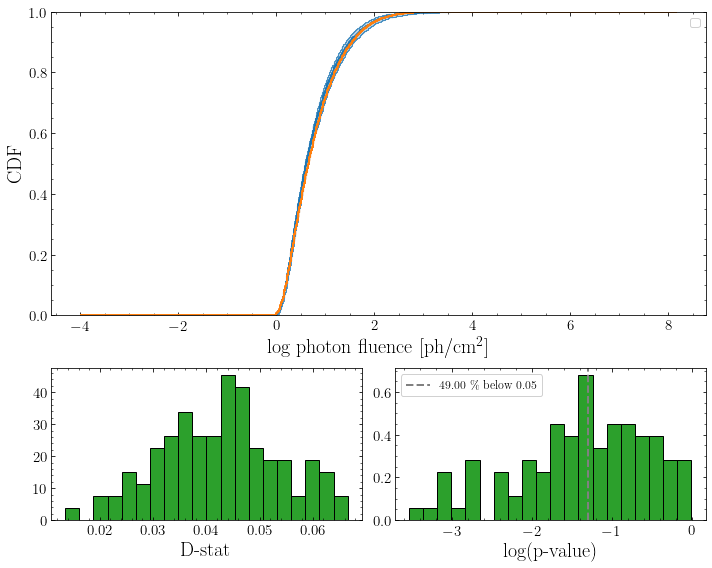

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


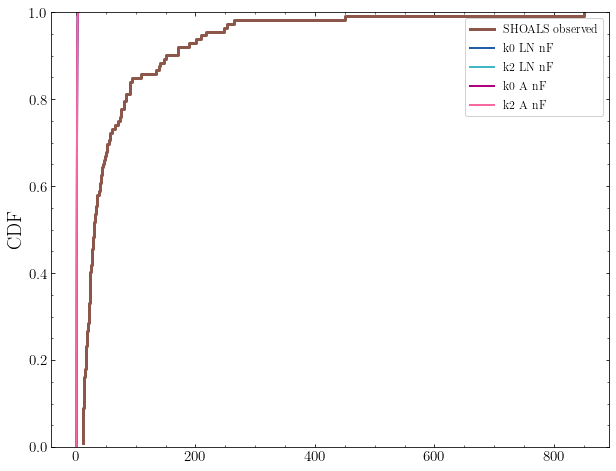

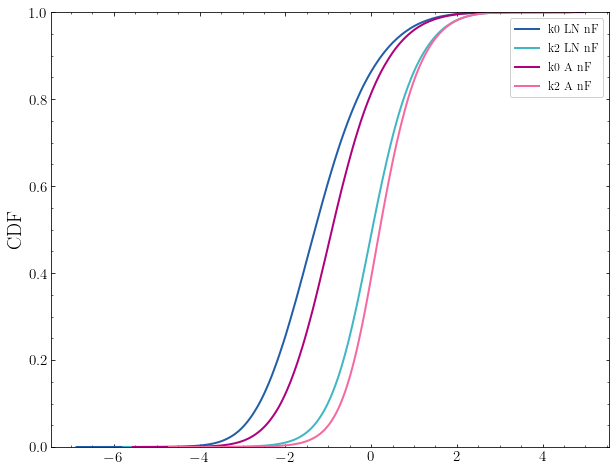

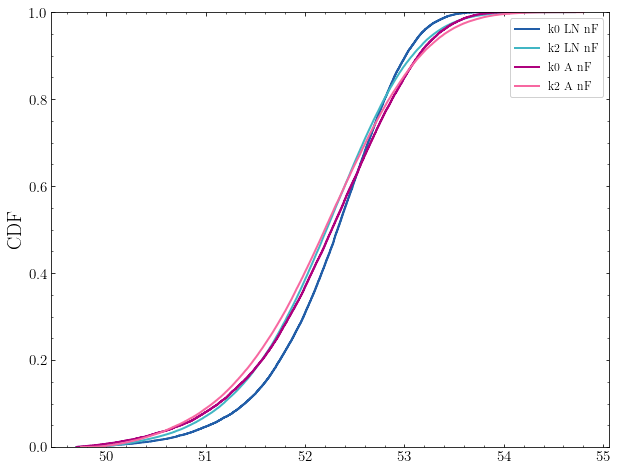

In [60]:
# All the things below are tests that didn't pan out
# Since just the redshift distribution of SHOALS doesn't help to discriminate much, maybe the L-z plane will
mod = 'k0_LN_nF'
cond = (dfs[mod].properties['erg_flnc_BAT']>=1e-7)
pf.cool_hist2d(dfs[mod].properties[cond]['z'].to_numpy(),
               np.log10(dfs[mod].properties[cond]['L'].to_numpy()),
               mode='hist2d', cb=False)
fig = plt.gcf()
axes = fig.axes
axes[0].set_xlim(0,7)
plt.show()



mod = 'k2_LN_nF'
cond = (dfs[mod].properties['erg_flnc_BAT']>=1e-7)
pf.cool_hist2d(dfs[mod].properties[cond]['z'].to_numpy(),
               np.log10(dfs[mod].properties[cond]['L'].to_numpy()),
               mode='hist2d', cb=False)
fig = plt.gcf()
axes = fig.axes
axes[0].set_xlim(0,7)
plt.show()

frac = np.zeros((len(size), len(flnc_cuts)))
k=0
# for i, j in product(range(len(size)), range(len(flnc_cuts))):
i=-1
j=-1
log.info("{} %. Size, fluence cut = {} {}".format(100*k/(len(size)*len(flnc_cuts)), size[i], flnc_cuts[j]))
frac[i,j]= st.subsample_and_KS(np.log10(dfs['k0_A_nF'].properties[(dfs['k0_A_nF'].properties['erg_flnc_BAT']>=flnc_cuts[j])]),
                             np.log10(dfs['k2_A_nF'].properties[(dfs['k2_A_nF'].properties['erg_flnc_BAT']>=flnc_cuts[j])]),
                             key='pht_flnc_BAT',
                             precision=precision,
                             bins=np.linspace(-4,4,precision+1),
                             N_sub=size[i],
                             N_bs=100,
                             subsample2=False, show_plot=True)
log.info("Fraction of samples different at the 95% confidence level : {}".format(frac[i,j]))
k+=1
plt.gcf().axes[0].set_xlabel('log photon fluence [ph/cm$^2$]')

p_discr_L['A'] = frac

# Plot the photon fluence distribution expected for SHOALS in the case of k=0 and k=2 for LogNormal and Amati models
# Also compute the KS tests between these fluence distributions and the observed SHOALS fluence distribution
fig, ax = plt.subplots(figsize=(10,8))
df_obs = io.read_SHOALS_file()
colors = ['#225ea8', '#41b6c4', '#ae017e', '#f768a1']
for i,mod in enumerate(model_names_ks):
    print(f"################# {mod} #####################")
    pf.plot_SHOALS_distr(dfs[mod].properties,
                          key='S_BAT',
                          plot_obs=(i==0),
                          cumul=True,
                          fig=fig,
                          mod_color=colors[i],
                          mod_label=mod.replace('_',' '))
    D_stat, p_value = ks_2samp(dfs[mod].properties[dfs[mod].properties['pdet_SHOALS']==1]['pht_flnc_BAT'], df_obs['S_BAT'])
    print("D-stat, p_value = {:.3f}, {:.3f}".format(D_stat, p_value))

# Plot the photon fluence distribution expected for SHOALS in the case of k=0 and k=2 for LogNormal and Amati models
# Also compute the KS tests between these fluence distributions and the observed SHOALS fluence distribution
fig, ax = plt.subplots(figsize=(10,8))
df_obs = obs.read_SHOALS_file()
colors = ['#225ea8', '#41b6c4', '#ae017e', '#f768a1']
for i,mod in enumerate(model_names_ks):
    print(f"################# {mod} #####################")
    pf.plot_SHOALS_distr(dfs[mod].properties['pht_flnc_BAT'],
                          key='S_BAT',
                          plot_obs=False,
                          cumul=True,
                          fig=fig,
                          mod_color=colors[i],
                          mod_label=mod.replace('_',' '))
    D_stat, p_value = ks_2samp(dfs[mod].properties[dfs[mod].properties['pdet_SHOALS']==1]['pht_flnc_BAT'], df_obs['S_BAT'])
    print("D-stat, p_value = {:.3f}, {:.3f}".format(D_stat, p_value))

# Plot the luminosity distribution expected for SHOALS in the case of k=0 and k=2 for LogNormal and Amati models
fig, ax = plt.subplots(figsize=(10,8))
df_obs = io.read_SHOALS_file()
colors = ['#225ea8', '#41b6c4', '#ae017e', '#f768a1']
for i,mod in enumerate(model_names_ks):
    print(f"################# {mod} #####################")
    pf.plot_SHOALS_distr(np.log10(dfs[mod].properties[dfs[mod].properties['pdet_SHOALS']==1]['L']),
                          key='L',
                          plot_obs=False,
                          cumul=True,
                          fig=fig,
                          mod_color=colors[i],
                          mod_label=mod.replace('_',' '))
